# Analysis of neuron networks, as they change over time

In [1]:
from analysis import analysis_utils as au
from analysis import resampling as rs
from analysis import graph_analysis_utils as gau
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from scipy import stats
import seaborn as sns
import SigProc
import sys

In [2]:
%matplotlib inline
InteractiveShell.ast_node_interactivity = "all"

In [3]:
sns.set_style("darkgrid")

In [4]:
mouse_directory = os.path.join(os.path.expanduser("~"), "Hen_Lab/Mice/EPM")

if not os.path.exists(mouse_directory):
    print("The mouse directory does not exist", file=sys.stderr)

file_num = 0
raw_files = list()
for dir_name, subdir_list, file_list in os.walk(mouse_directory):
    for file_name in file_list:
        if file_name.endswith(".csv"):
            print("{}. full path of: {} is: {}".format(file_num, file_name, os.path.join(dir_name, file_name)))
            file_num += 1
            raw_files.append(os.path.join(dir_name, file_name))

0. full path of: behavior_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/behavior_drd87.csv
1. full path of: Raw_EPM_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/Raw_EPM_drd87.csv
2. full path of: Raw_EPM_drd73.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73/Raw_EPM_drd73.csv
3. full path of: behavior_drd73.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73/behavior_drd73.csv
4. full path of: Raw_EPM_drd77.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd77/Raw_EPM_drd77.csv
5. full path of: behavior_drd77.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd77/behavior_drd77.csv
6. full path of: behavior_drd46.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46/behavior_drd46.csv
7. full path of: Raw_EPM_drd46.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46/Raw_EPM_drd46.csv


In [5]:
data = pd.read_csv(raw_files[1], header=None)
_, AUC_dataframe, cell_transients_dataframe = SigProc.detect_ca_transients_mossy(data, 2, 0.5, 0.2, 10)

In [6]:
behavior_column_names = ["Trial_time", 'Recording_time', 'X_center', 'Y_center', 'Area', 'Areachange', 
                         'Elongation', 'Distance_moved', 'Velocity', 'Arena_centerpoint',
                         'Open1_centerpoint', 'Open2_centerpoint',
                         'Closed1_centerpoint', 'Closed2_centerpoint',
                         'OpenArms_centerpoint', 'ClosedArms_centerpoint', 'Result_1']

behavior_df = pd.read_csv(raw_files[0], header=None)
behavior_df.columns = behavior_column_names
behavior_df = au.downsample_dataframe(behavior_df, 3)

# Define what constitutes as a running frame
VELOCITY_CUTOFF = 4;

# Adds "Running_frames" column to the end of the behavior Dataframe 
behavior_df["Running_frames"] = np.where(behavior_df["Velocity"] > VELOCITY_CUTOFF, 1, 0)

# Rename all the columns from "neuron_x" --> "x". This makes the graphs neater by making sure the neuron names fit into the nodes
cell_transients_dataframe.columns = [i for i in range(1, len(cell_transients_dataframe.columns)+1)]

In [7]:
neuron_concated_behavior = AUC_dataframe.join(behavior_df, how="left")

In [8]:
def bin_by_time(dataframe, **kwargs):
    """Split dataframe by frequency
    
    Split up the time series data into specified time bins. 
    
    Args: 
        dataframe: DataFrame
        
            a pandas DataFrame of the signal data for 
            all the imaged neurons of a given animal activity.
        
        freq: string, optional
            
            If specified, this is the frequency by which the 
            passed DataFrame will be split. The default is 
            1Min.
    
    Returns: 
        time_bins: dictionary
            
            All of the DataFrames that encompasse the passed-in
            DataFrame.
    """
    
    # Create copy of the dataframe for a certain behavior
    time_binned_df = dataframe.copy()
    time_binned_df.reset_index(drop=True, inplace=True)
    
    # Add a column of the trial time in the form of time deltas
    x = pd.to_timedelta("0.1s")
    time_binned_df.loc[:, "TIME"] = pd.Series(x*i for i in (time_binned_df.index))
    
    # Group the dataframe by 1 minute intervals
    grouped = time_binned_df.set_index("TIME").groupby(pd.Grouper(freq=kwargs.get("freq", "1Min")))
    
    # Place each dataframe that contains the data for every 1 minute intervals into a dictionary
    time_bins = {}
    freq = 0
    for name, group in grouped:
        time_bins[freq] = grouped.get_group(name)
        freq += 1
        
    return time_bins

# We begin by plotting the networks, over time, for activity recorded in the **OpenArms**, and in the **ClosedArms**

## In accordance with Network neuroscience (Bassett & Sporns 2017), we plot the state of the network of neurons for DRD87 for the duration of the EPM experiment.

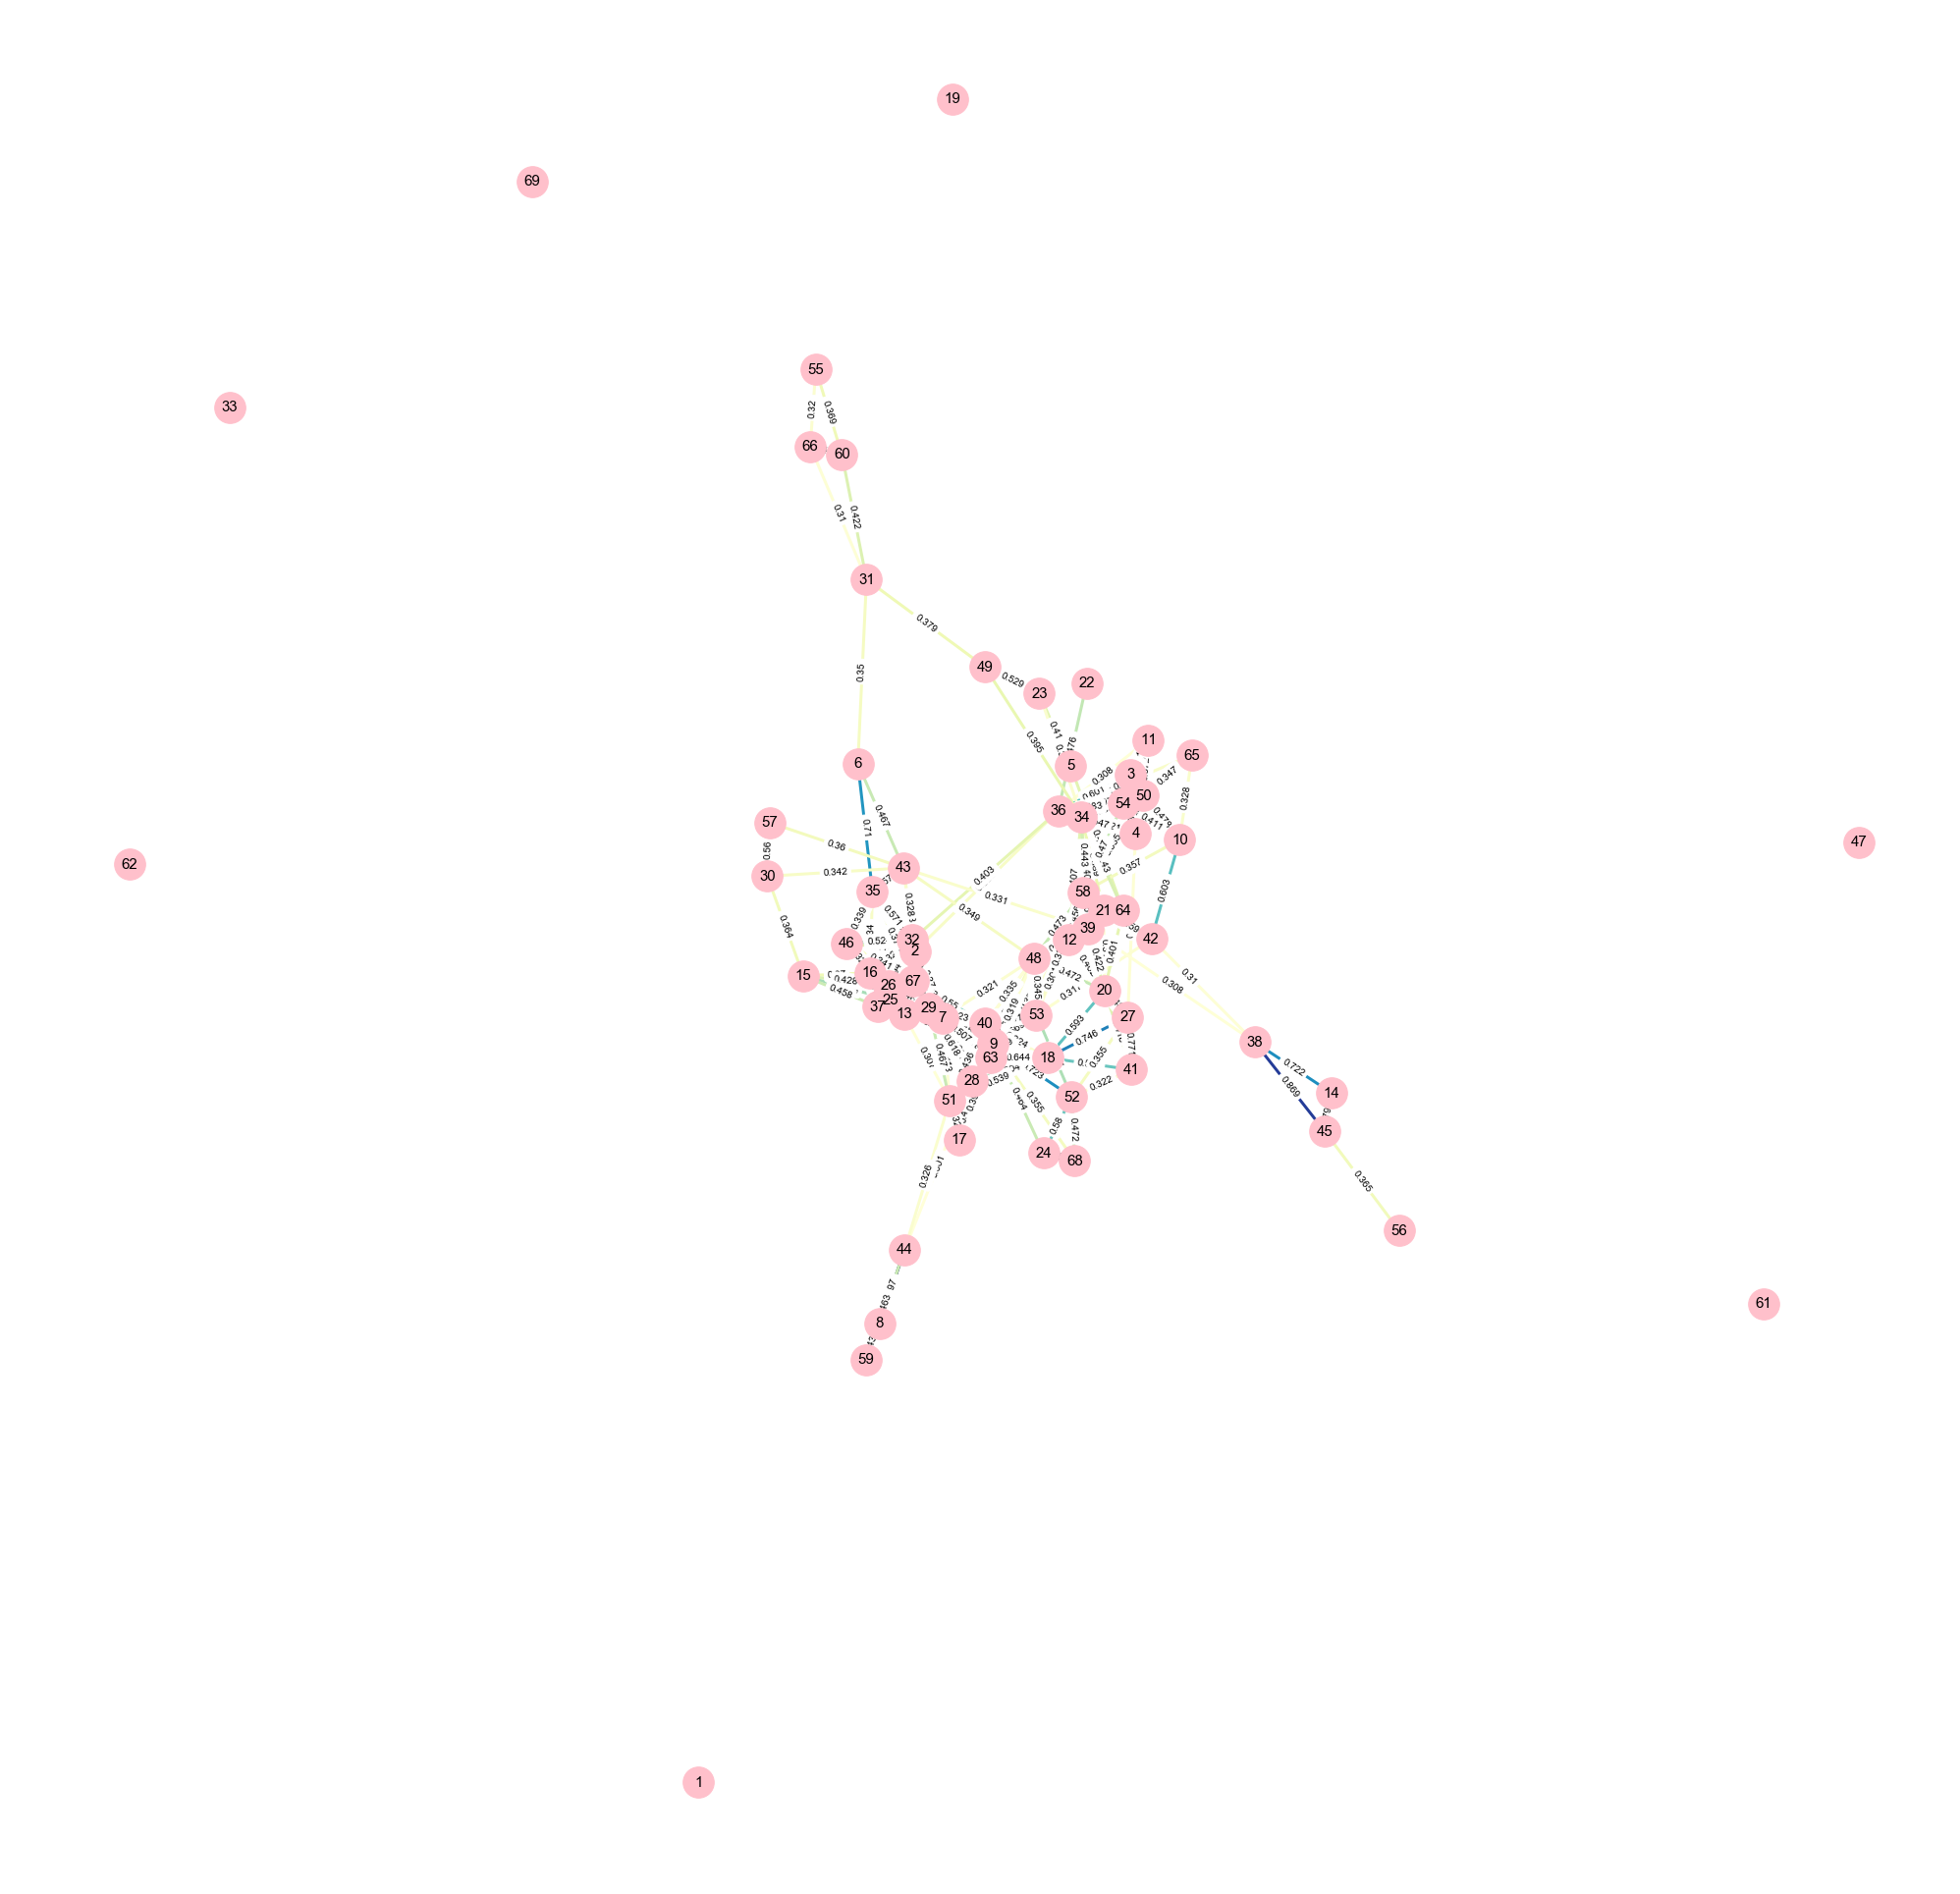

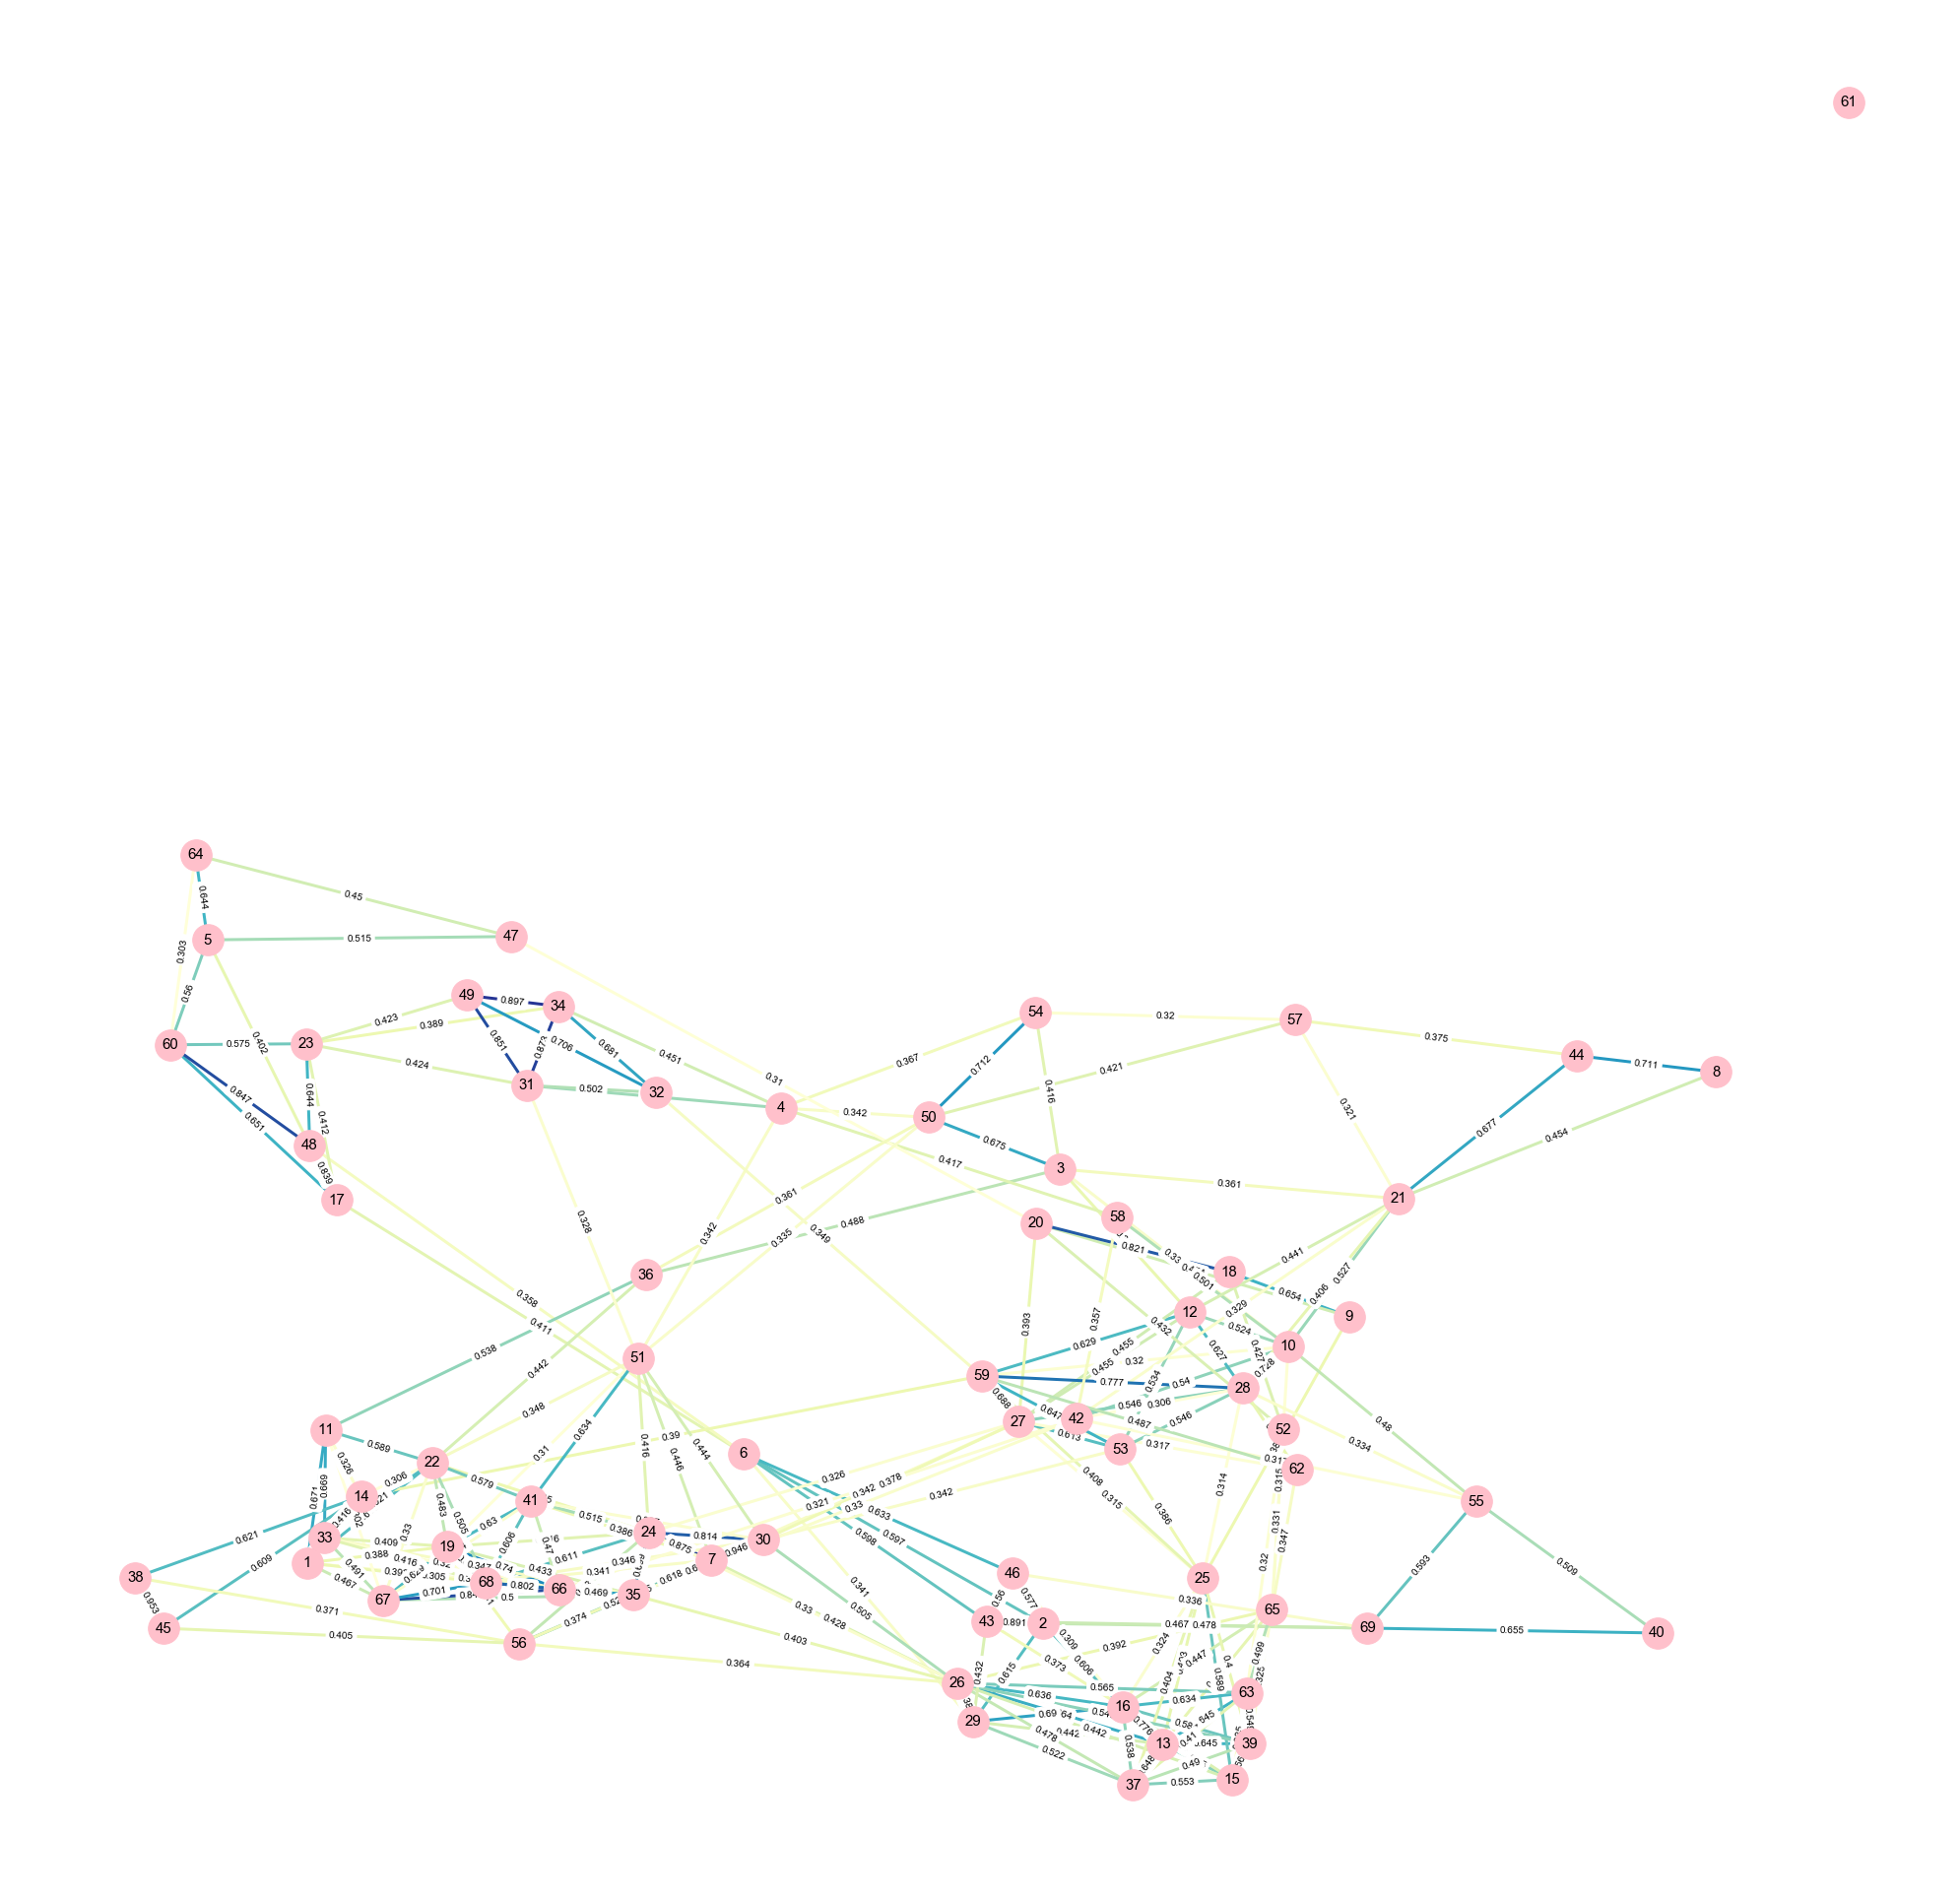

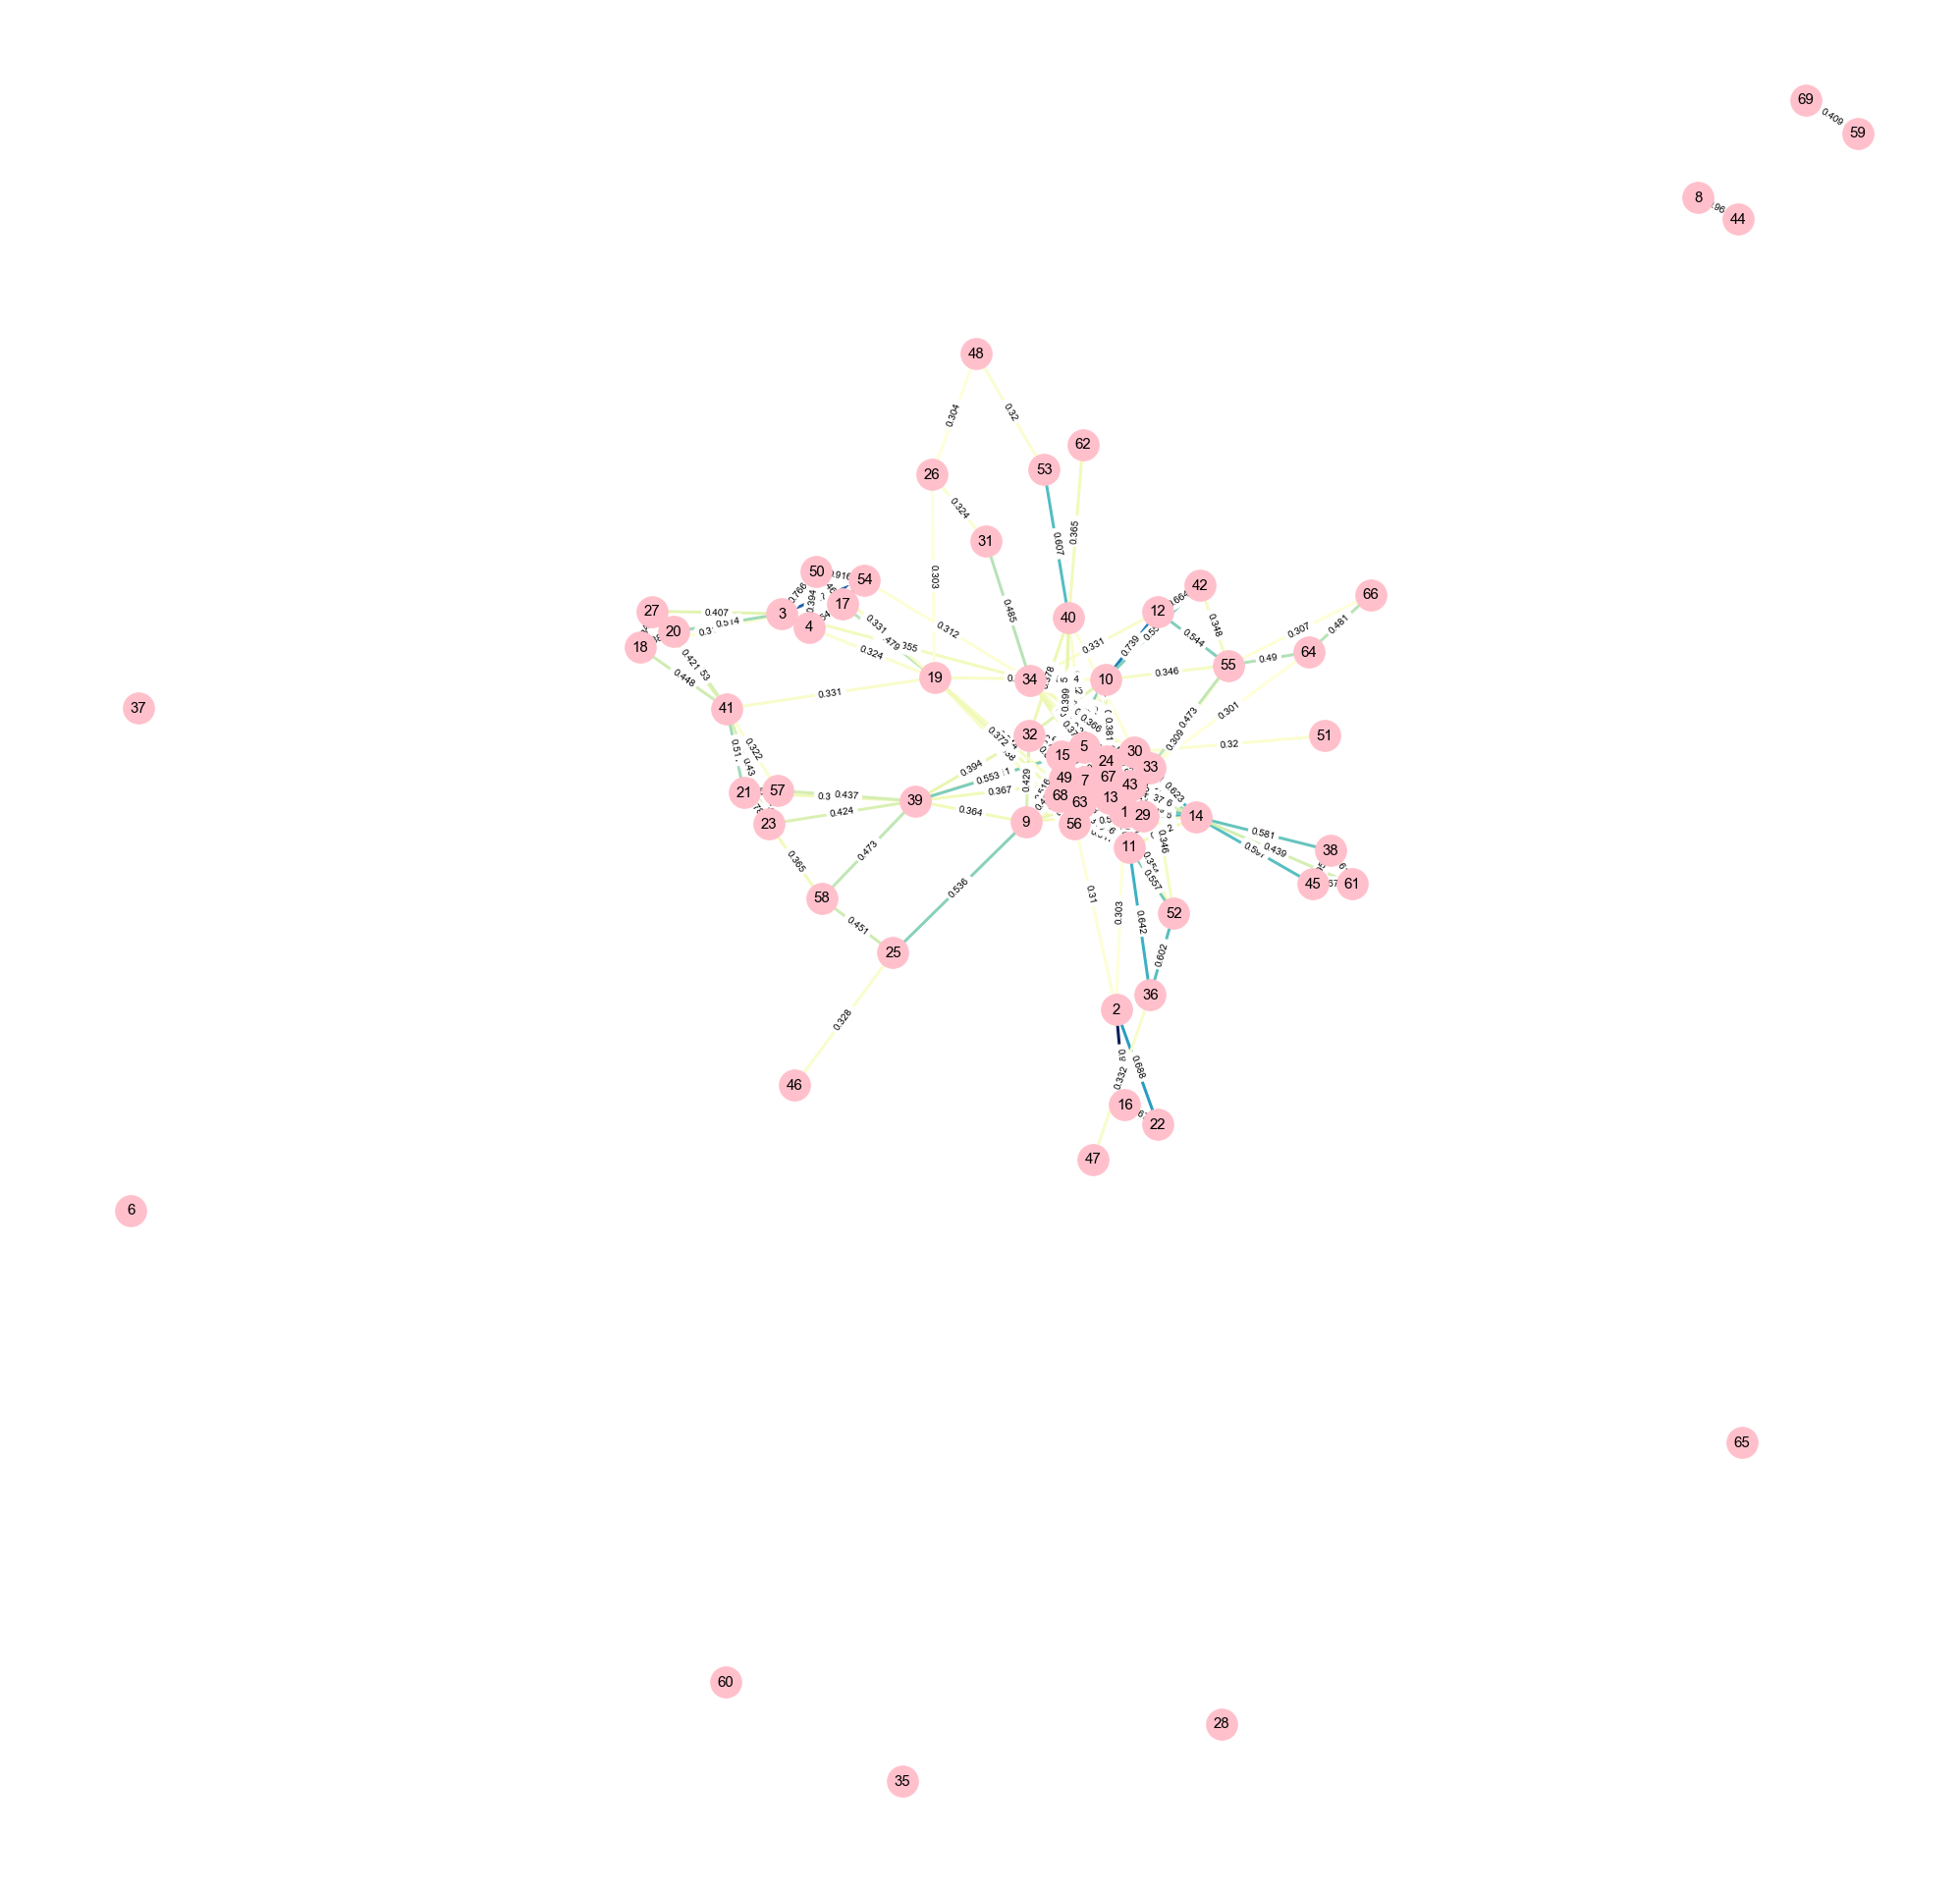

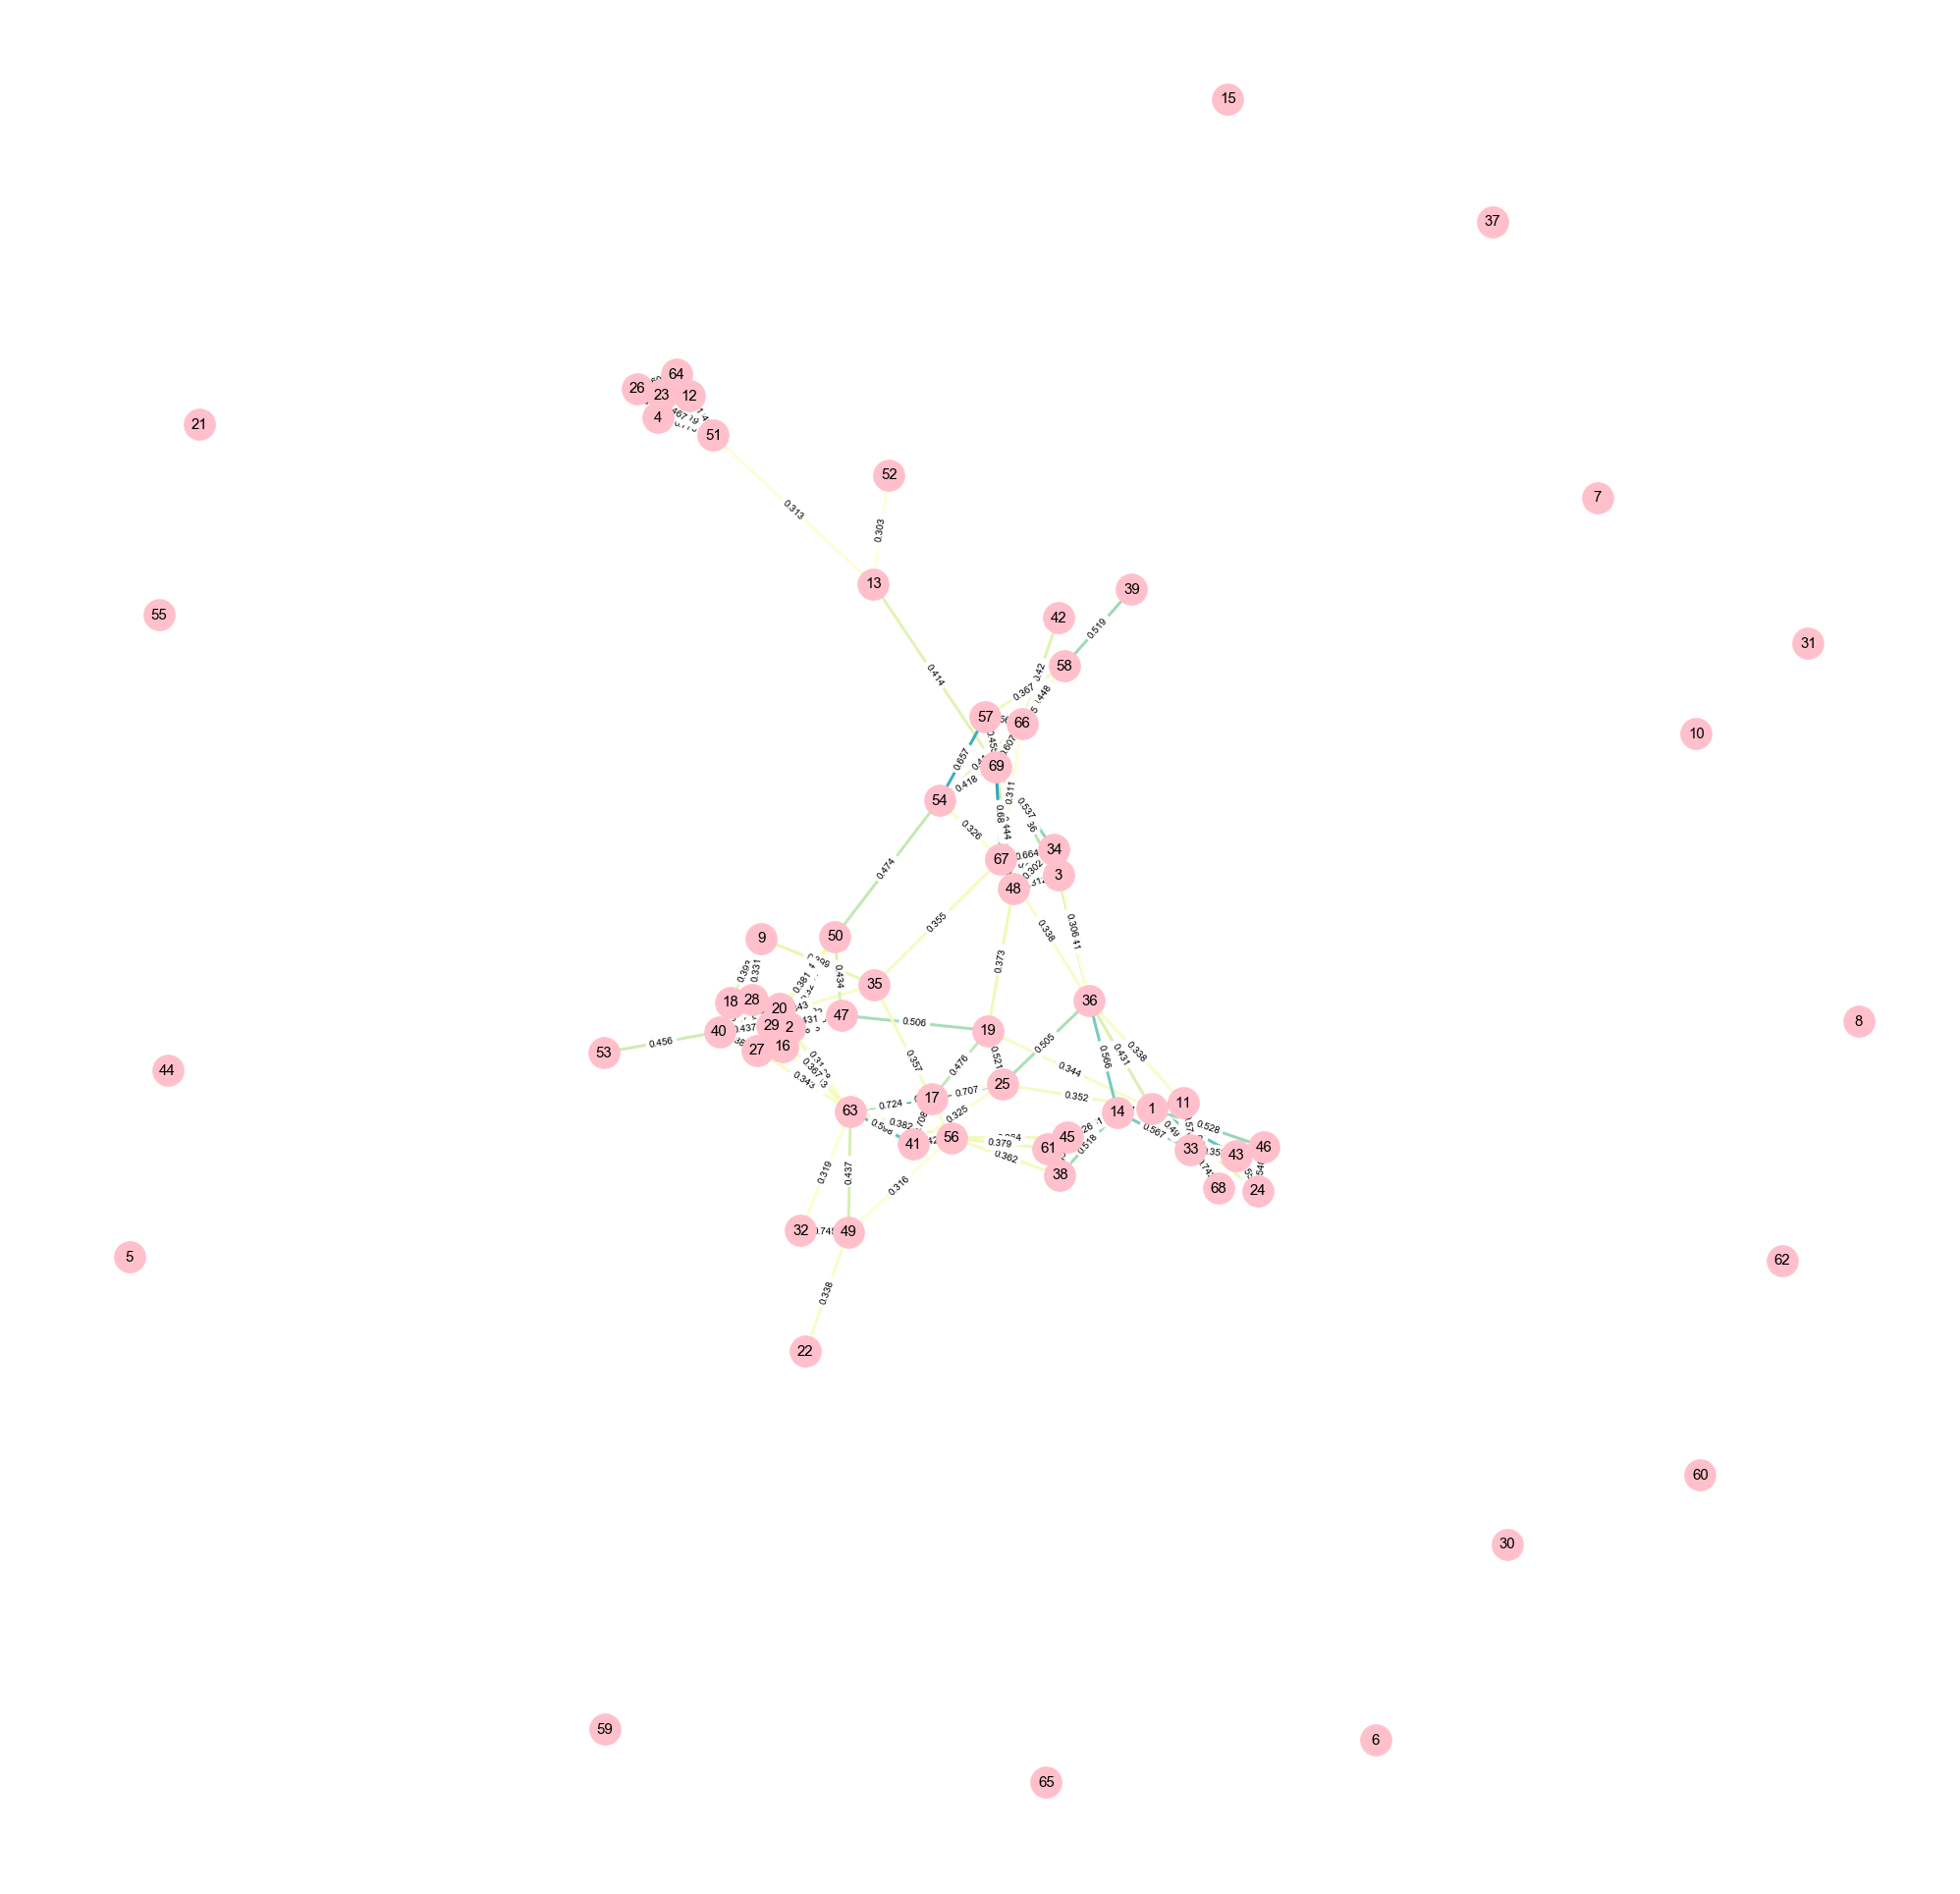

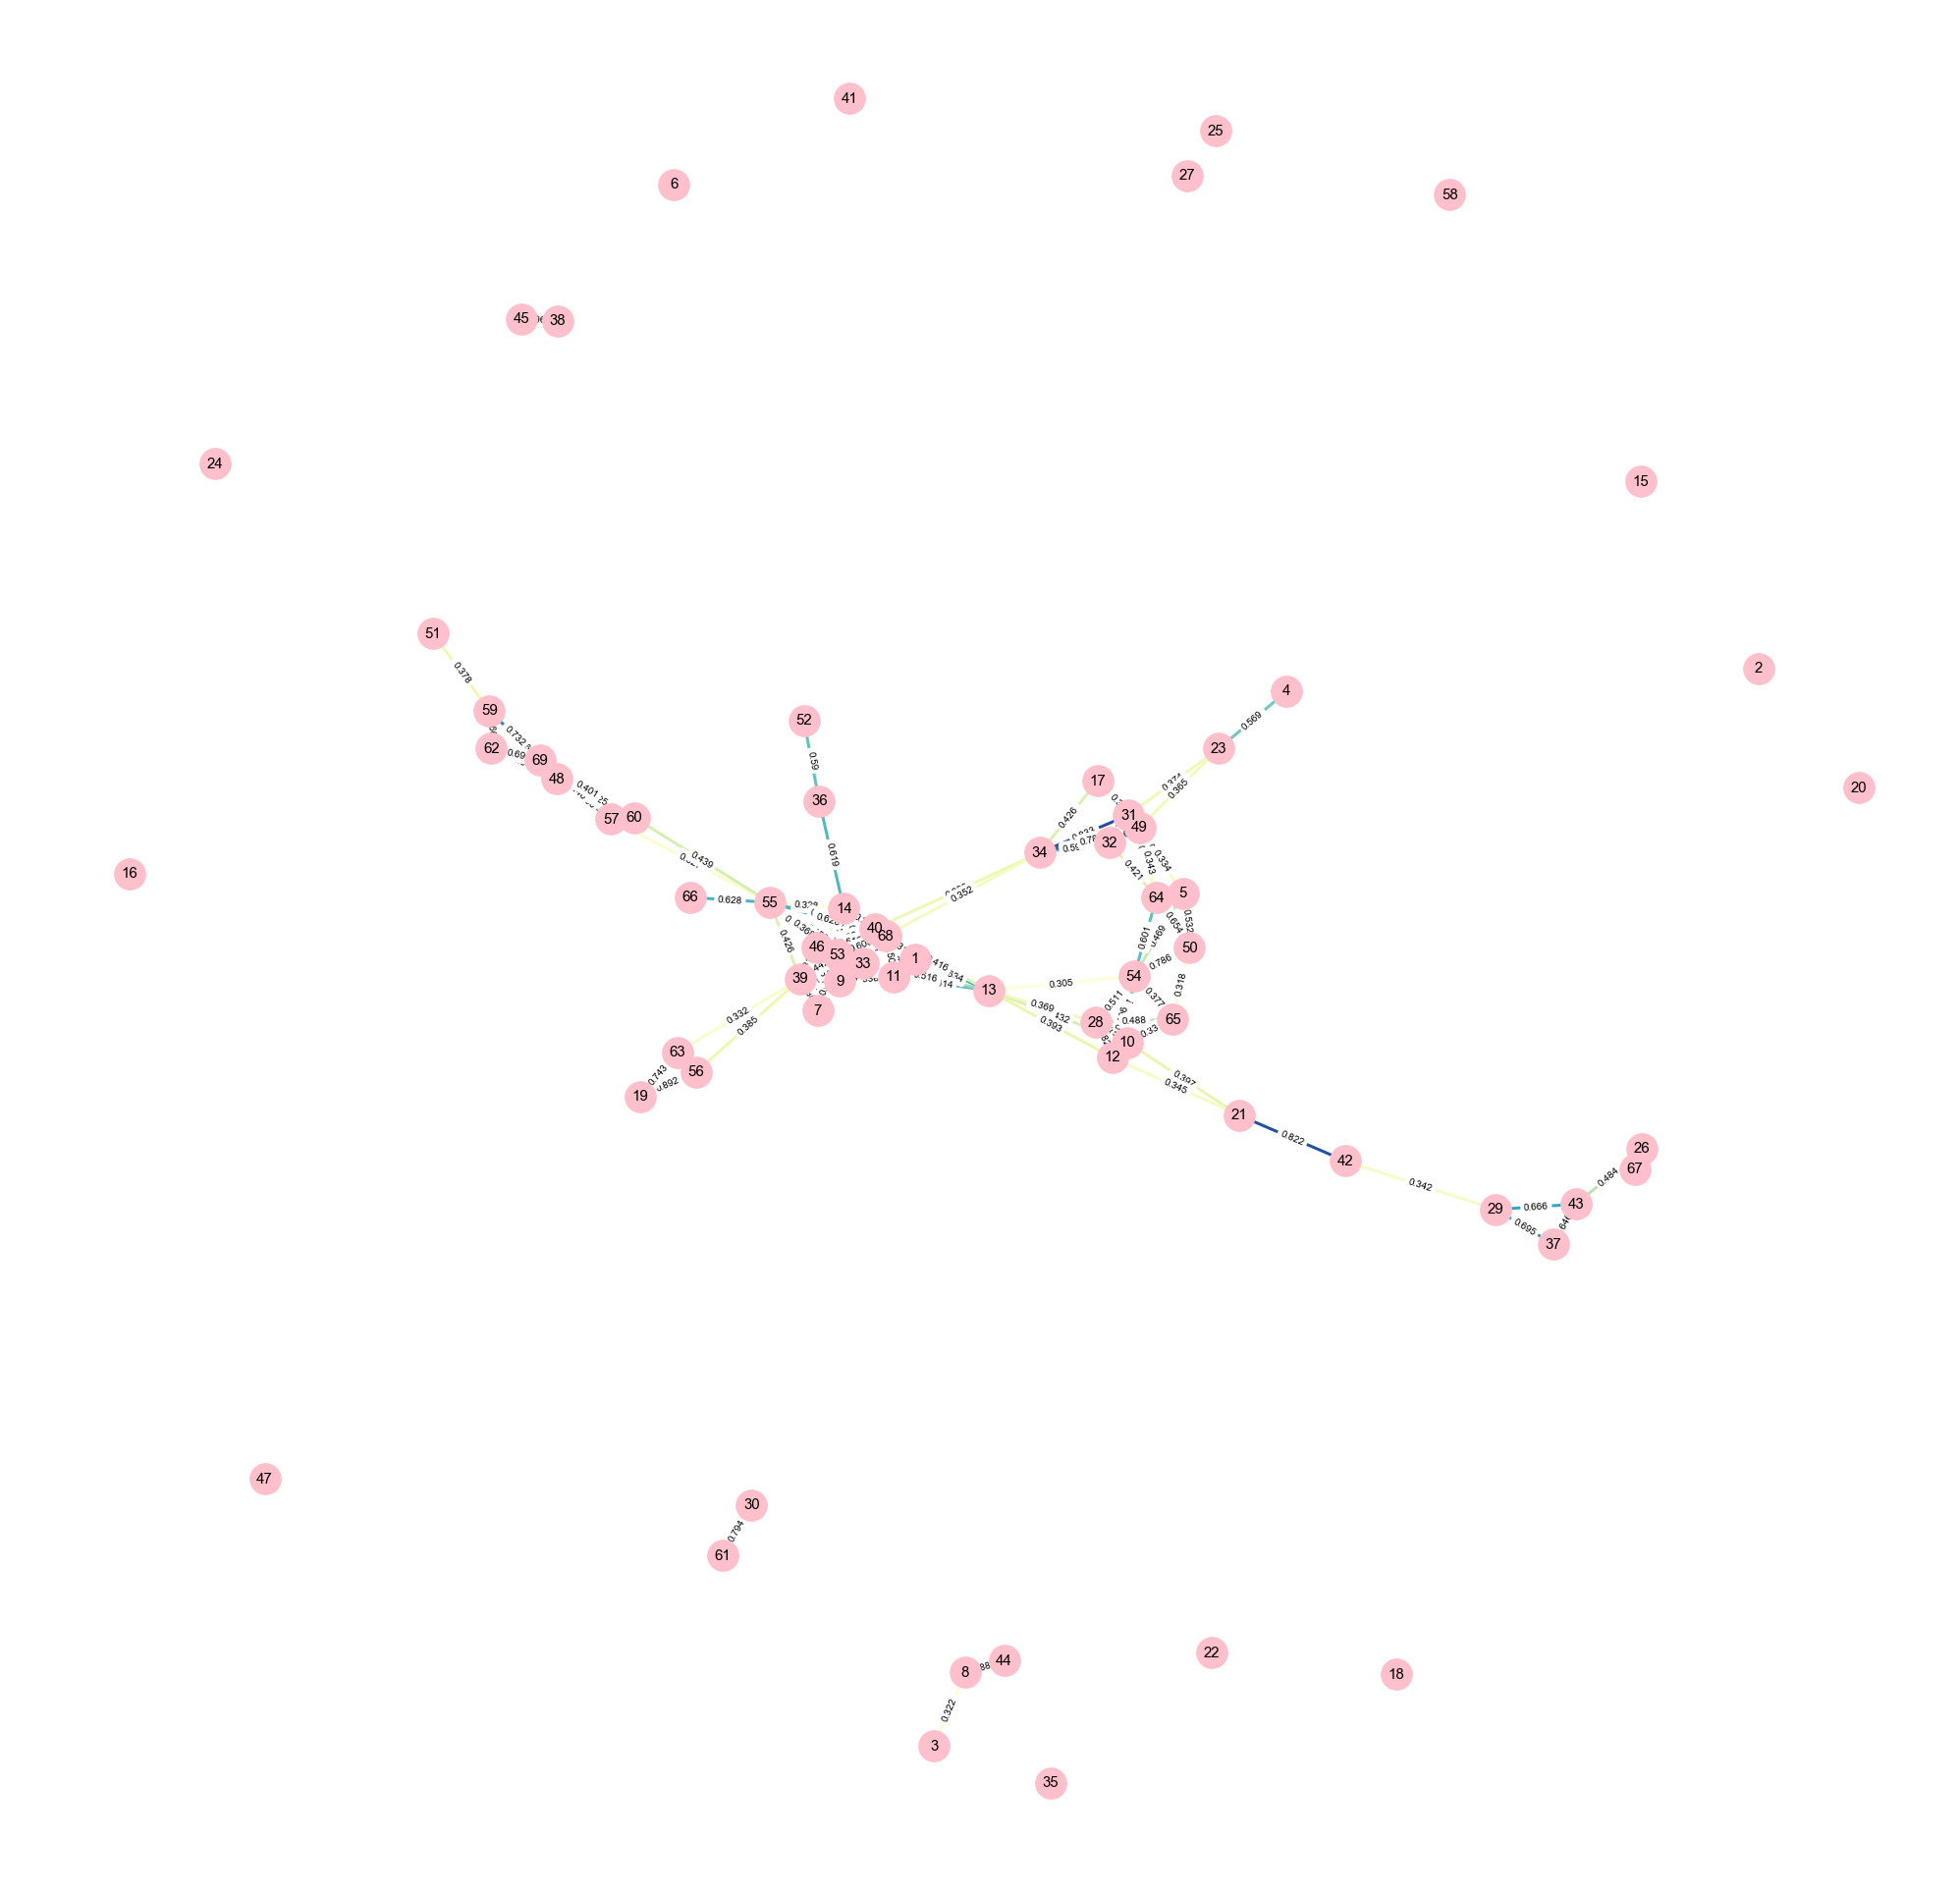

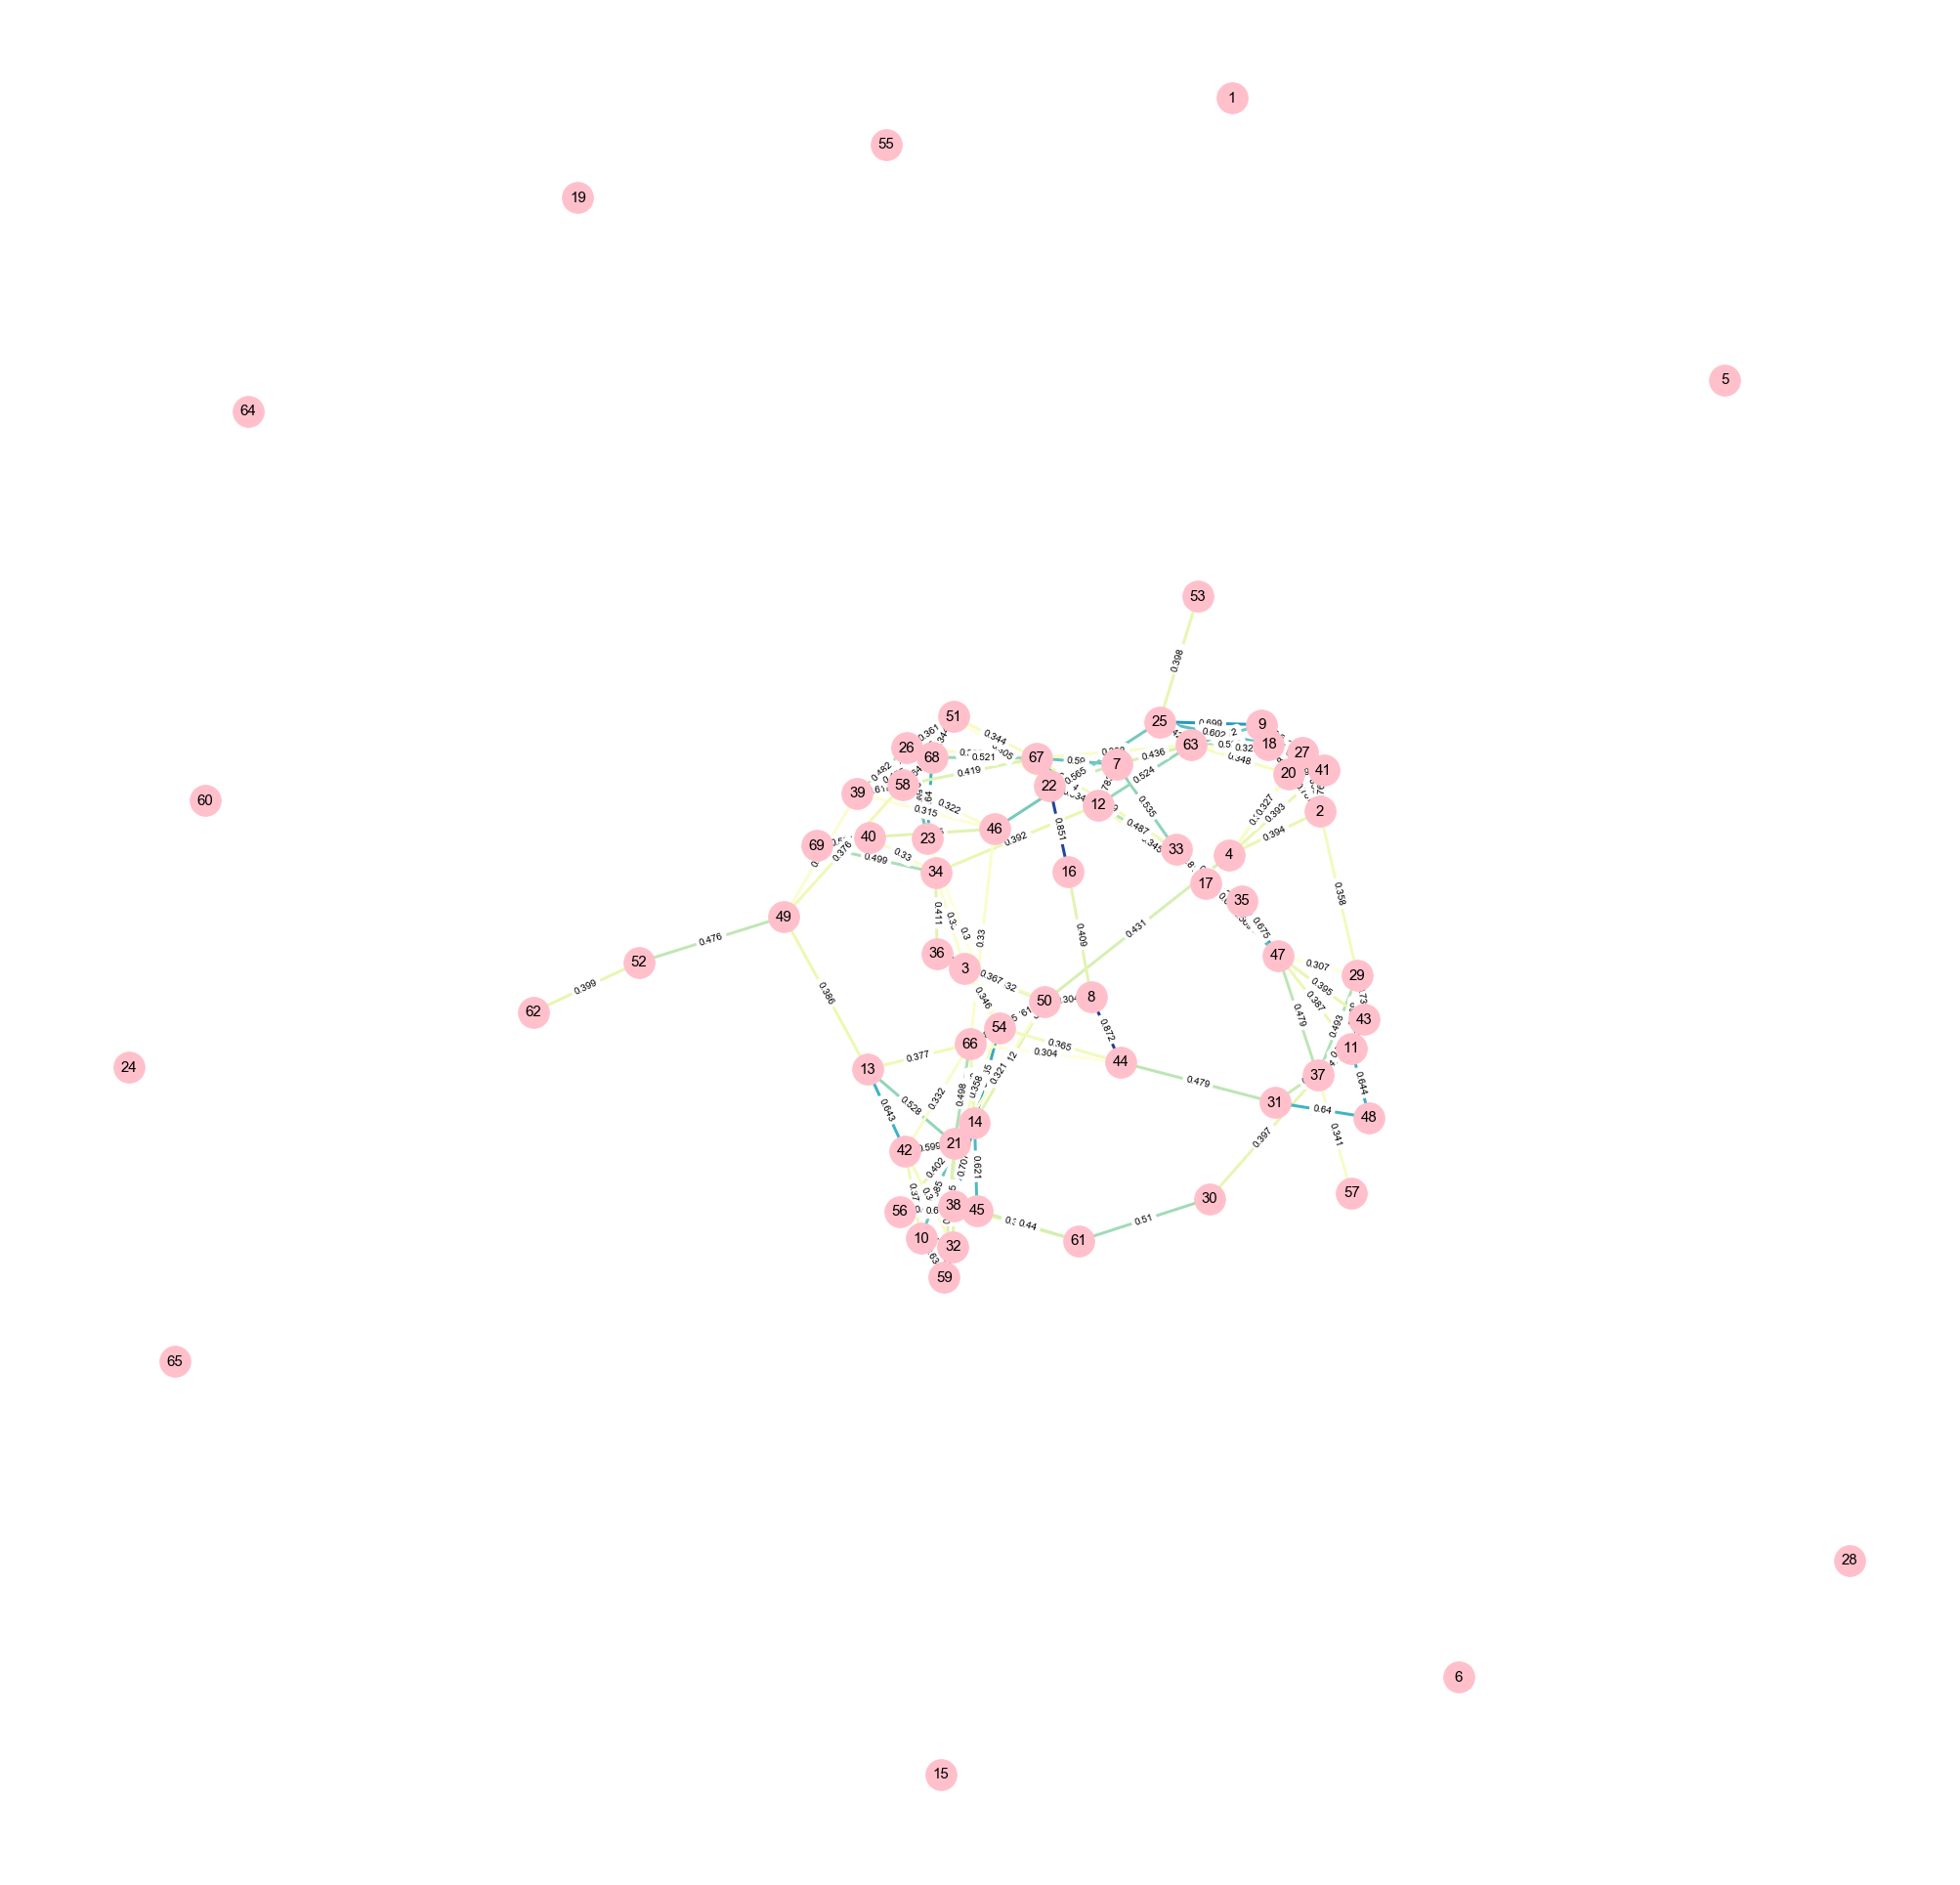

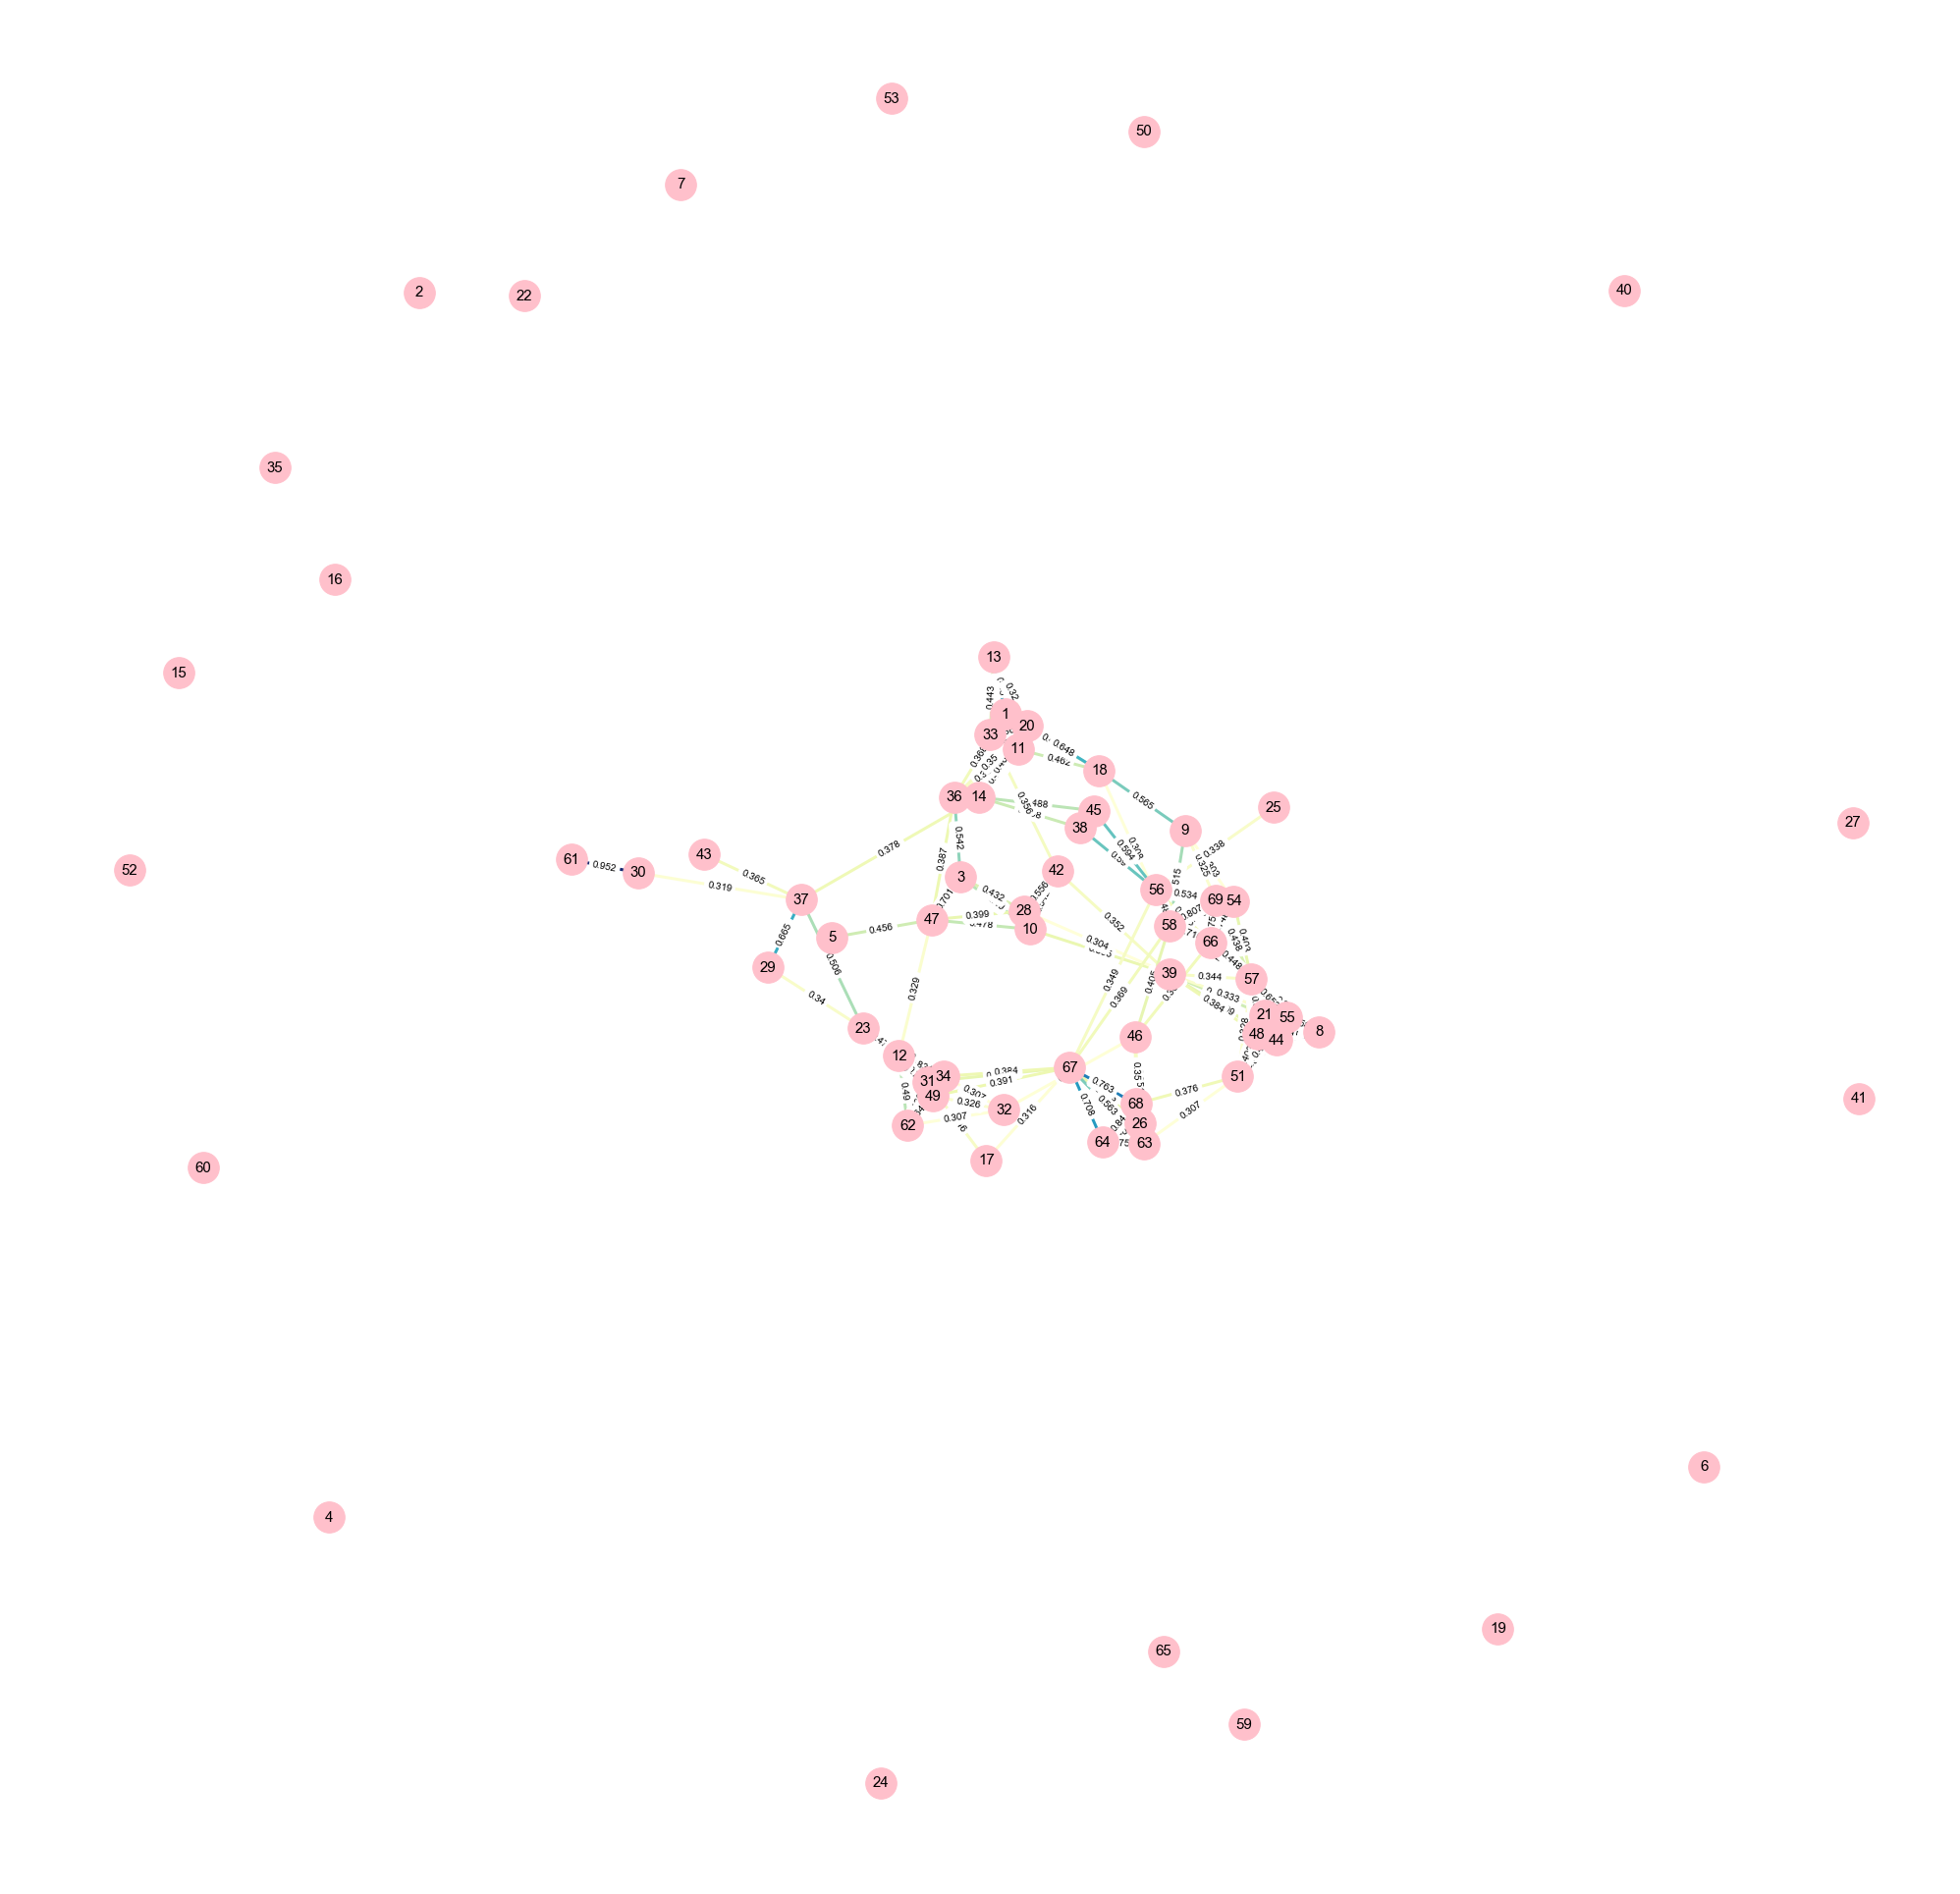

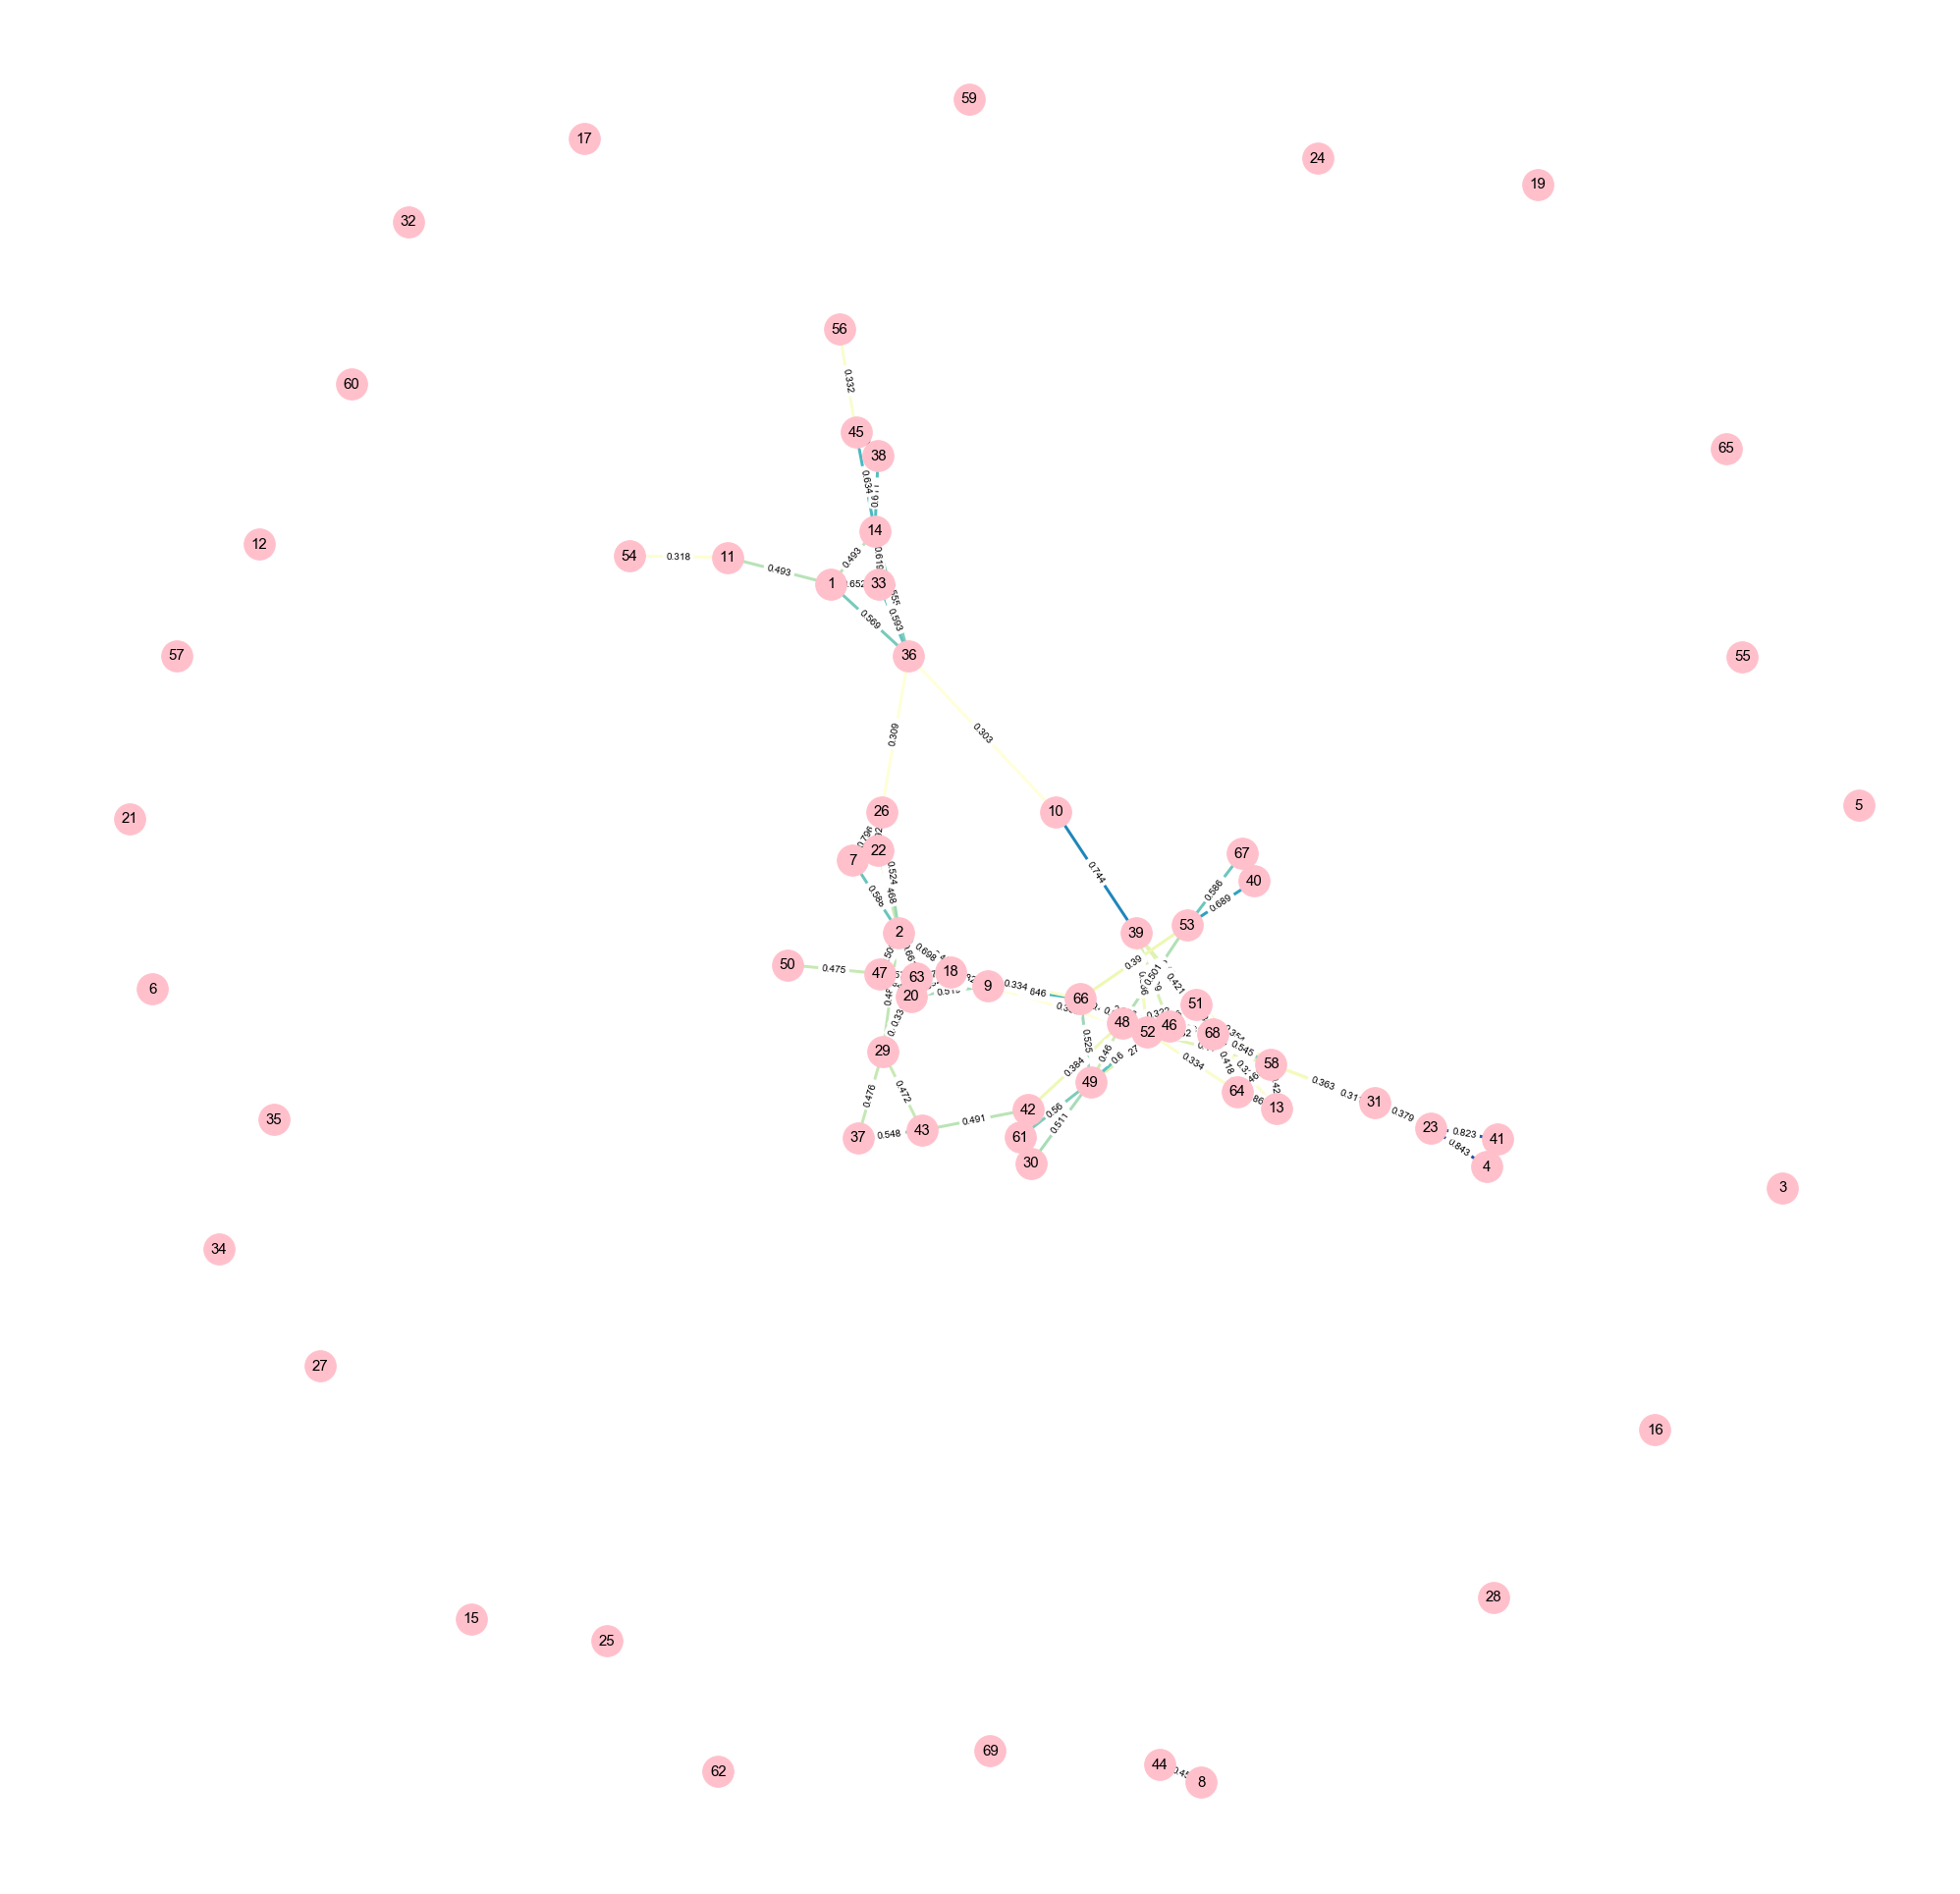

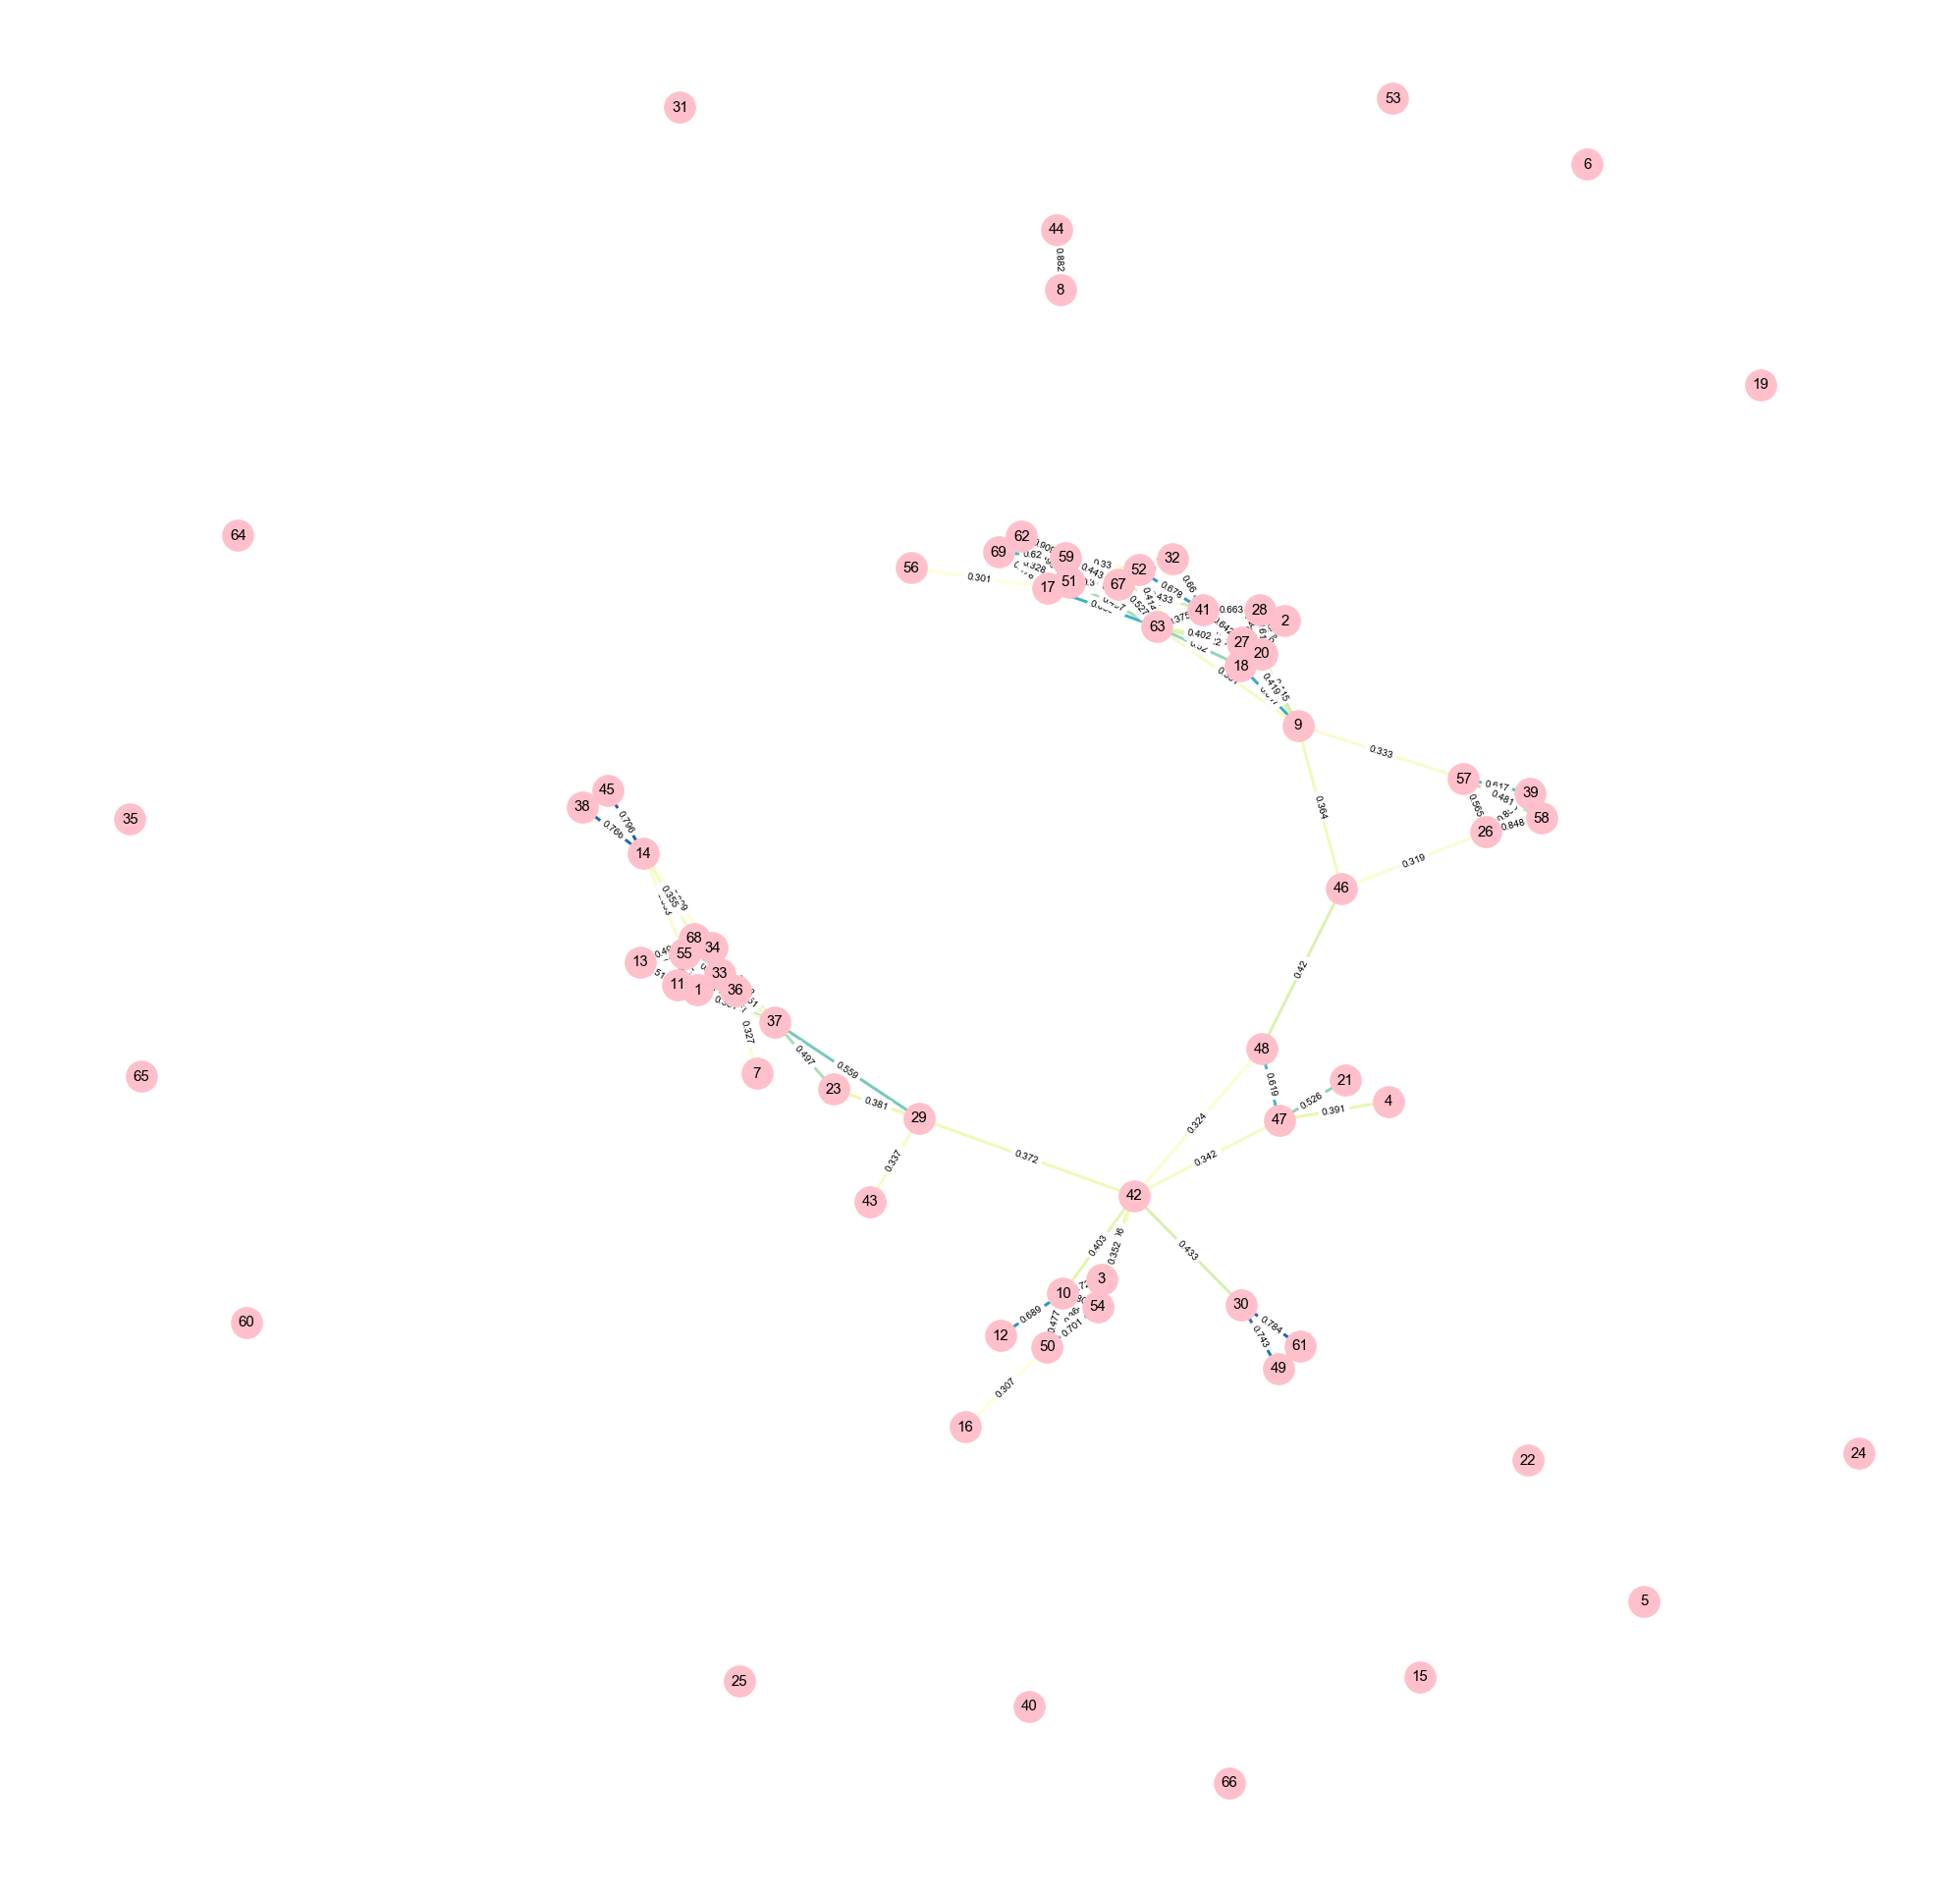

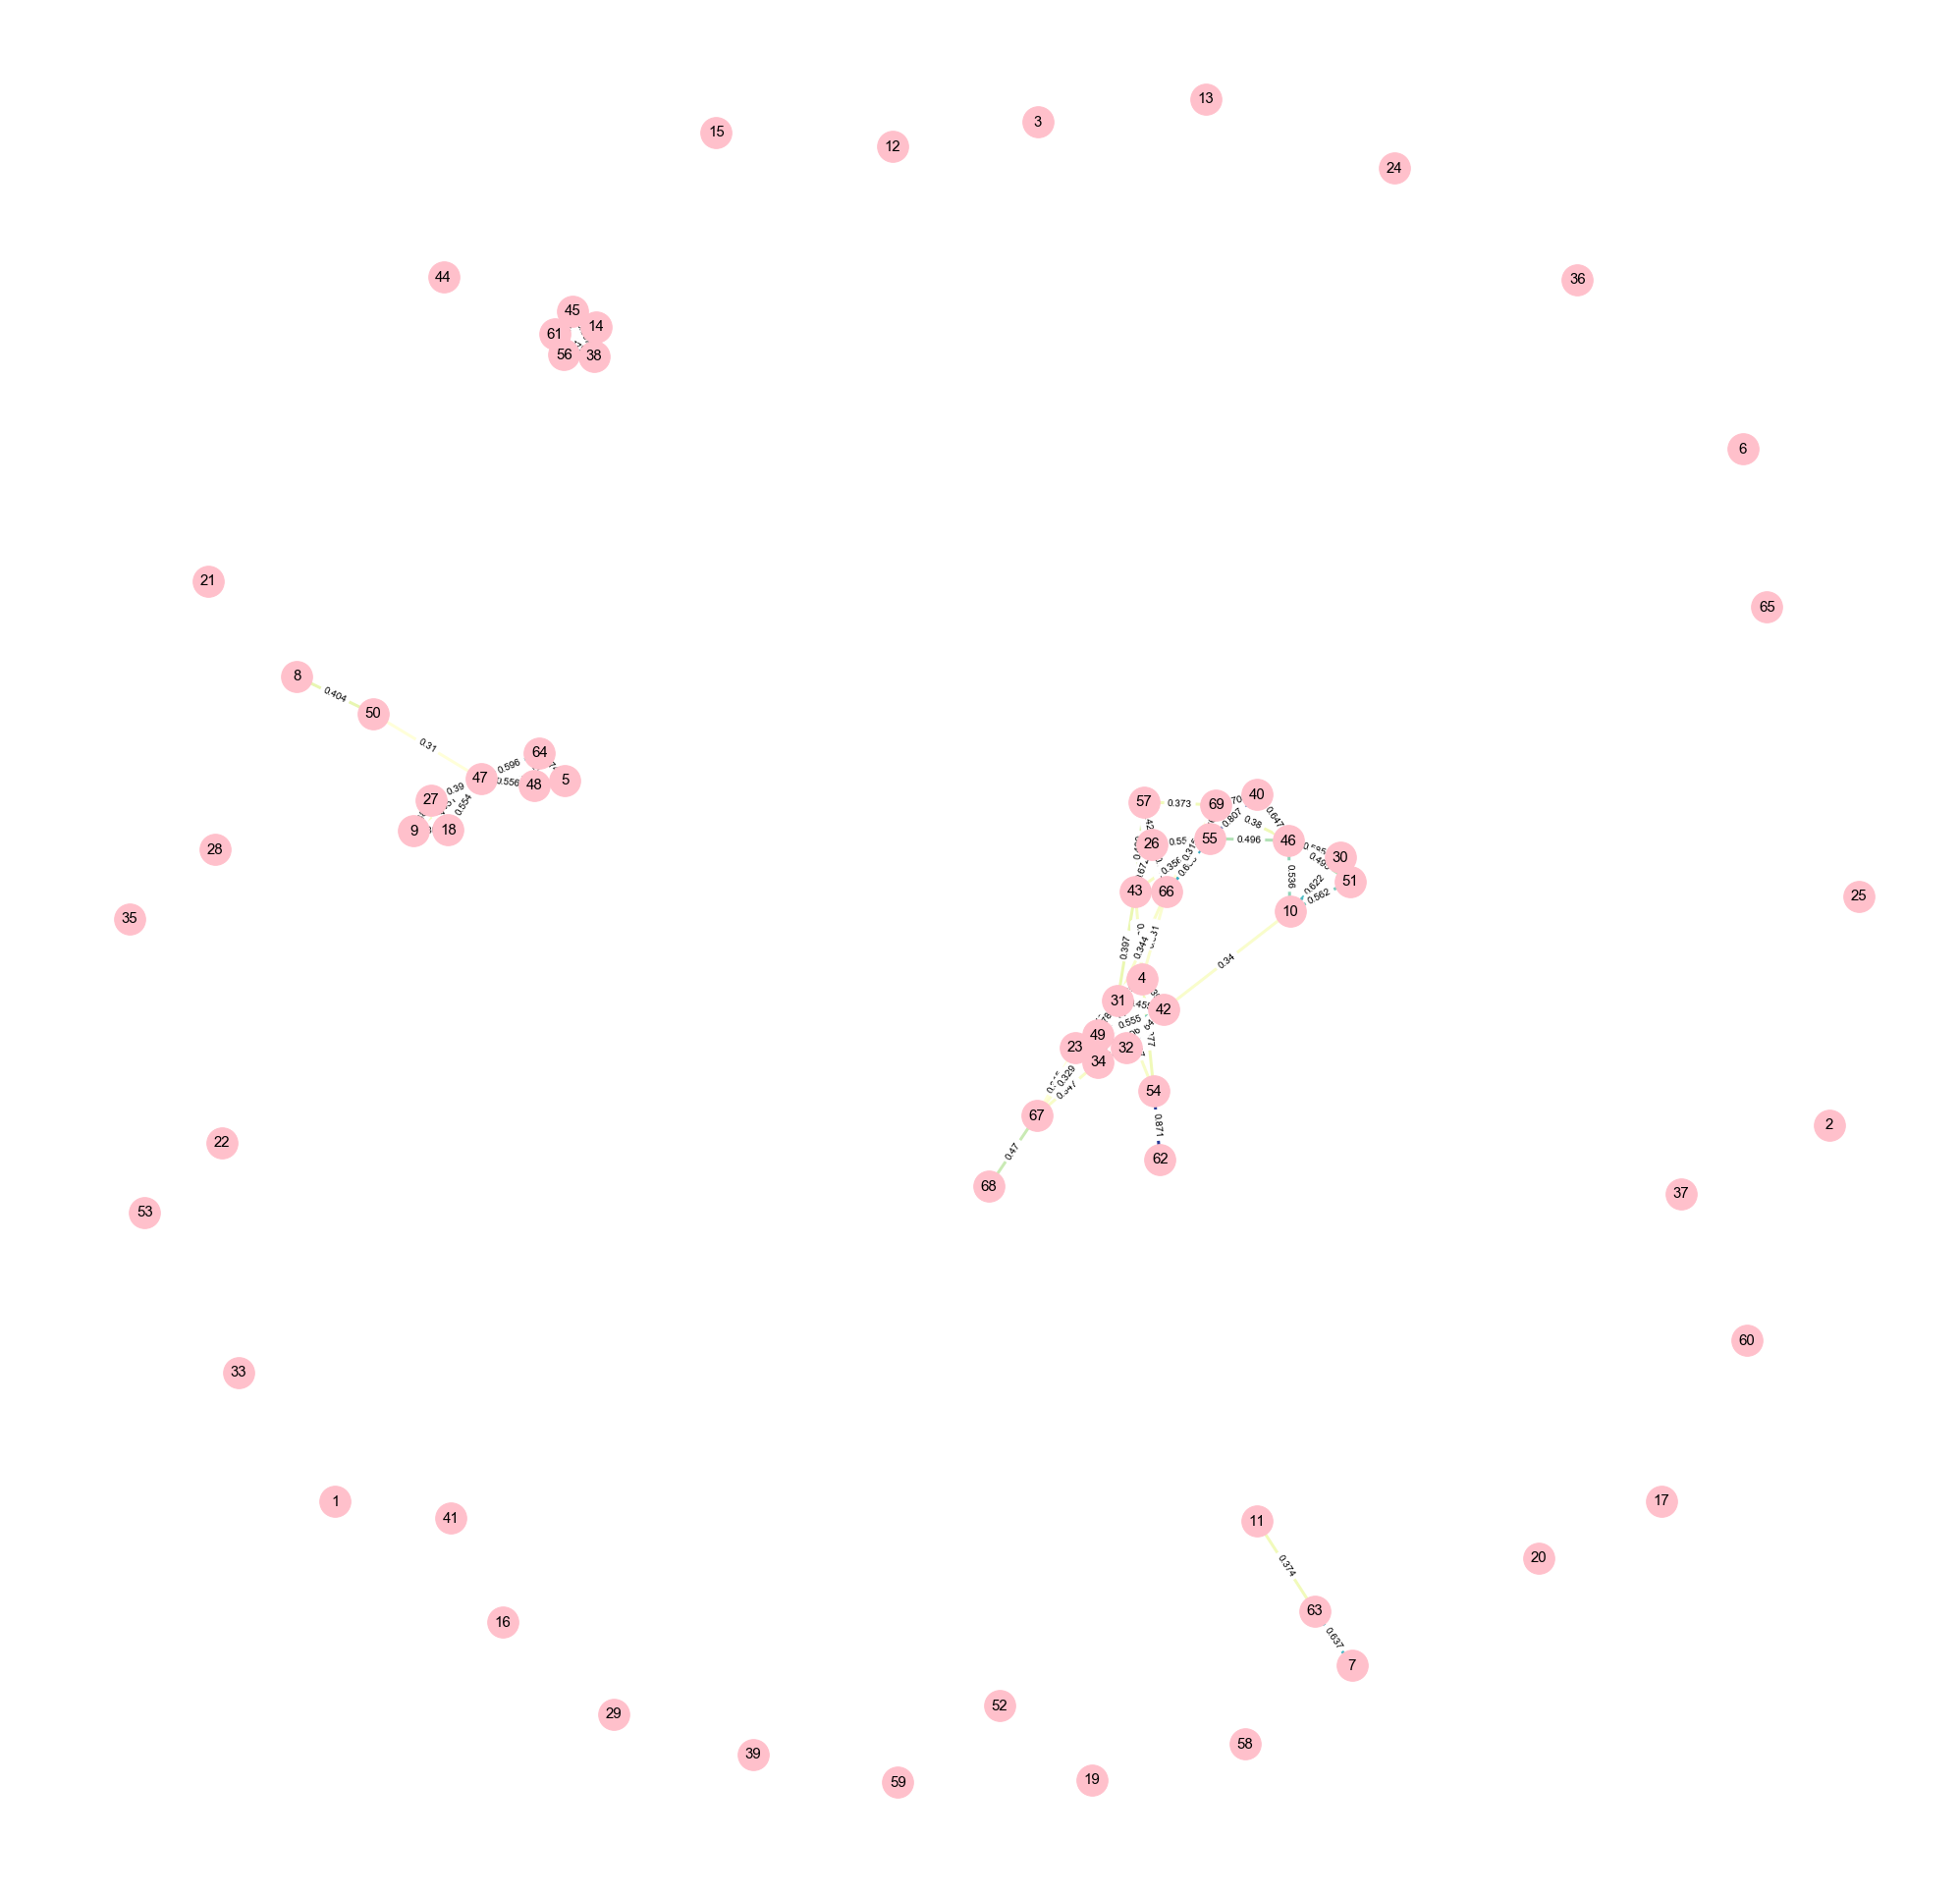

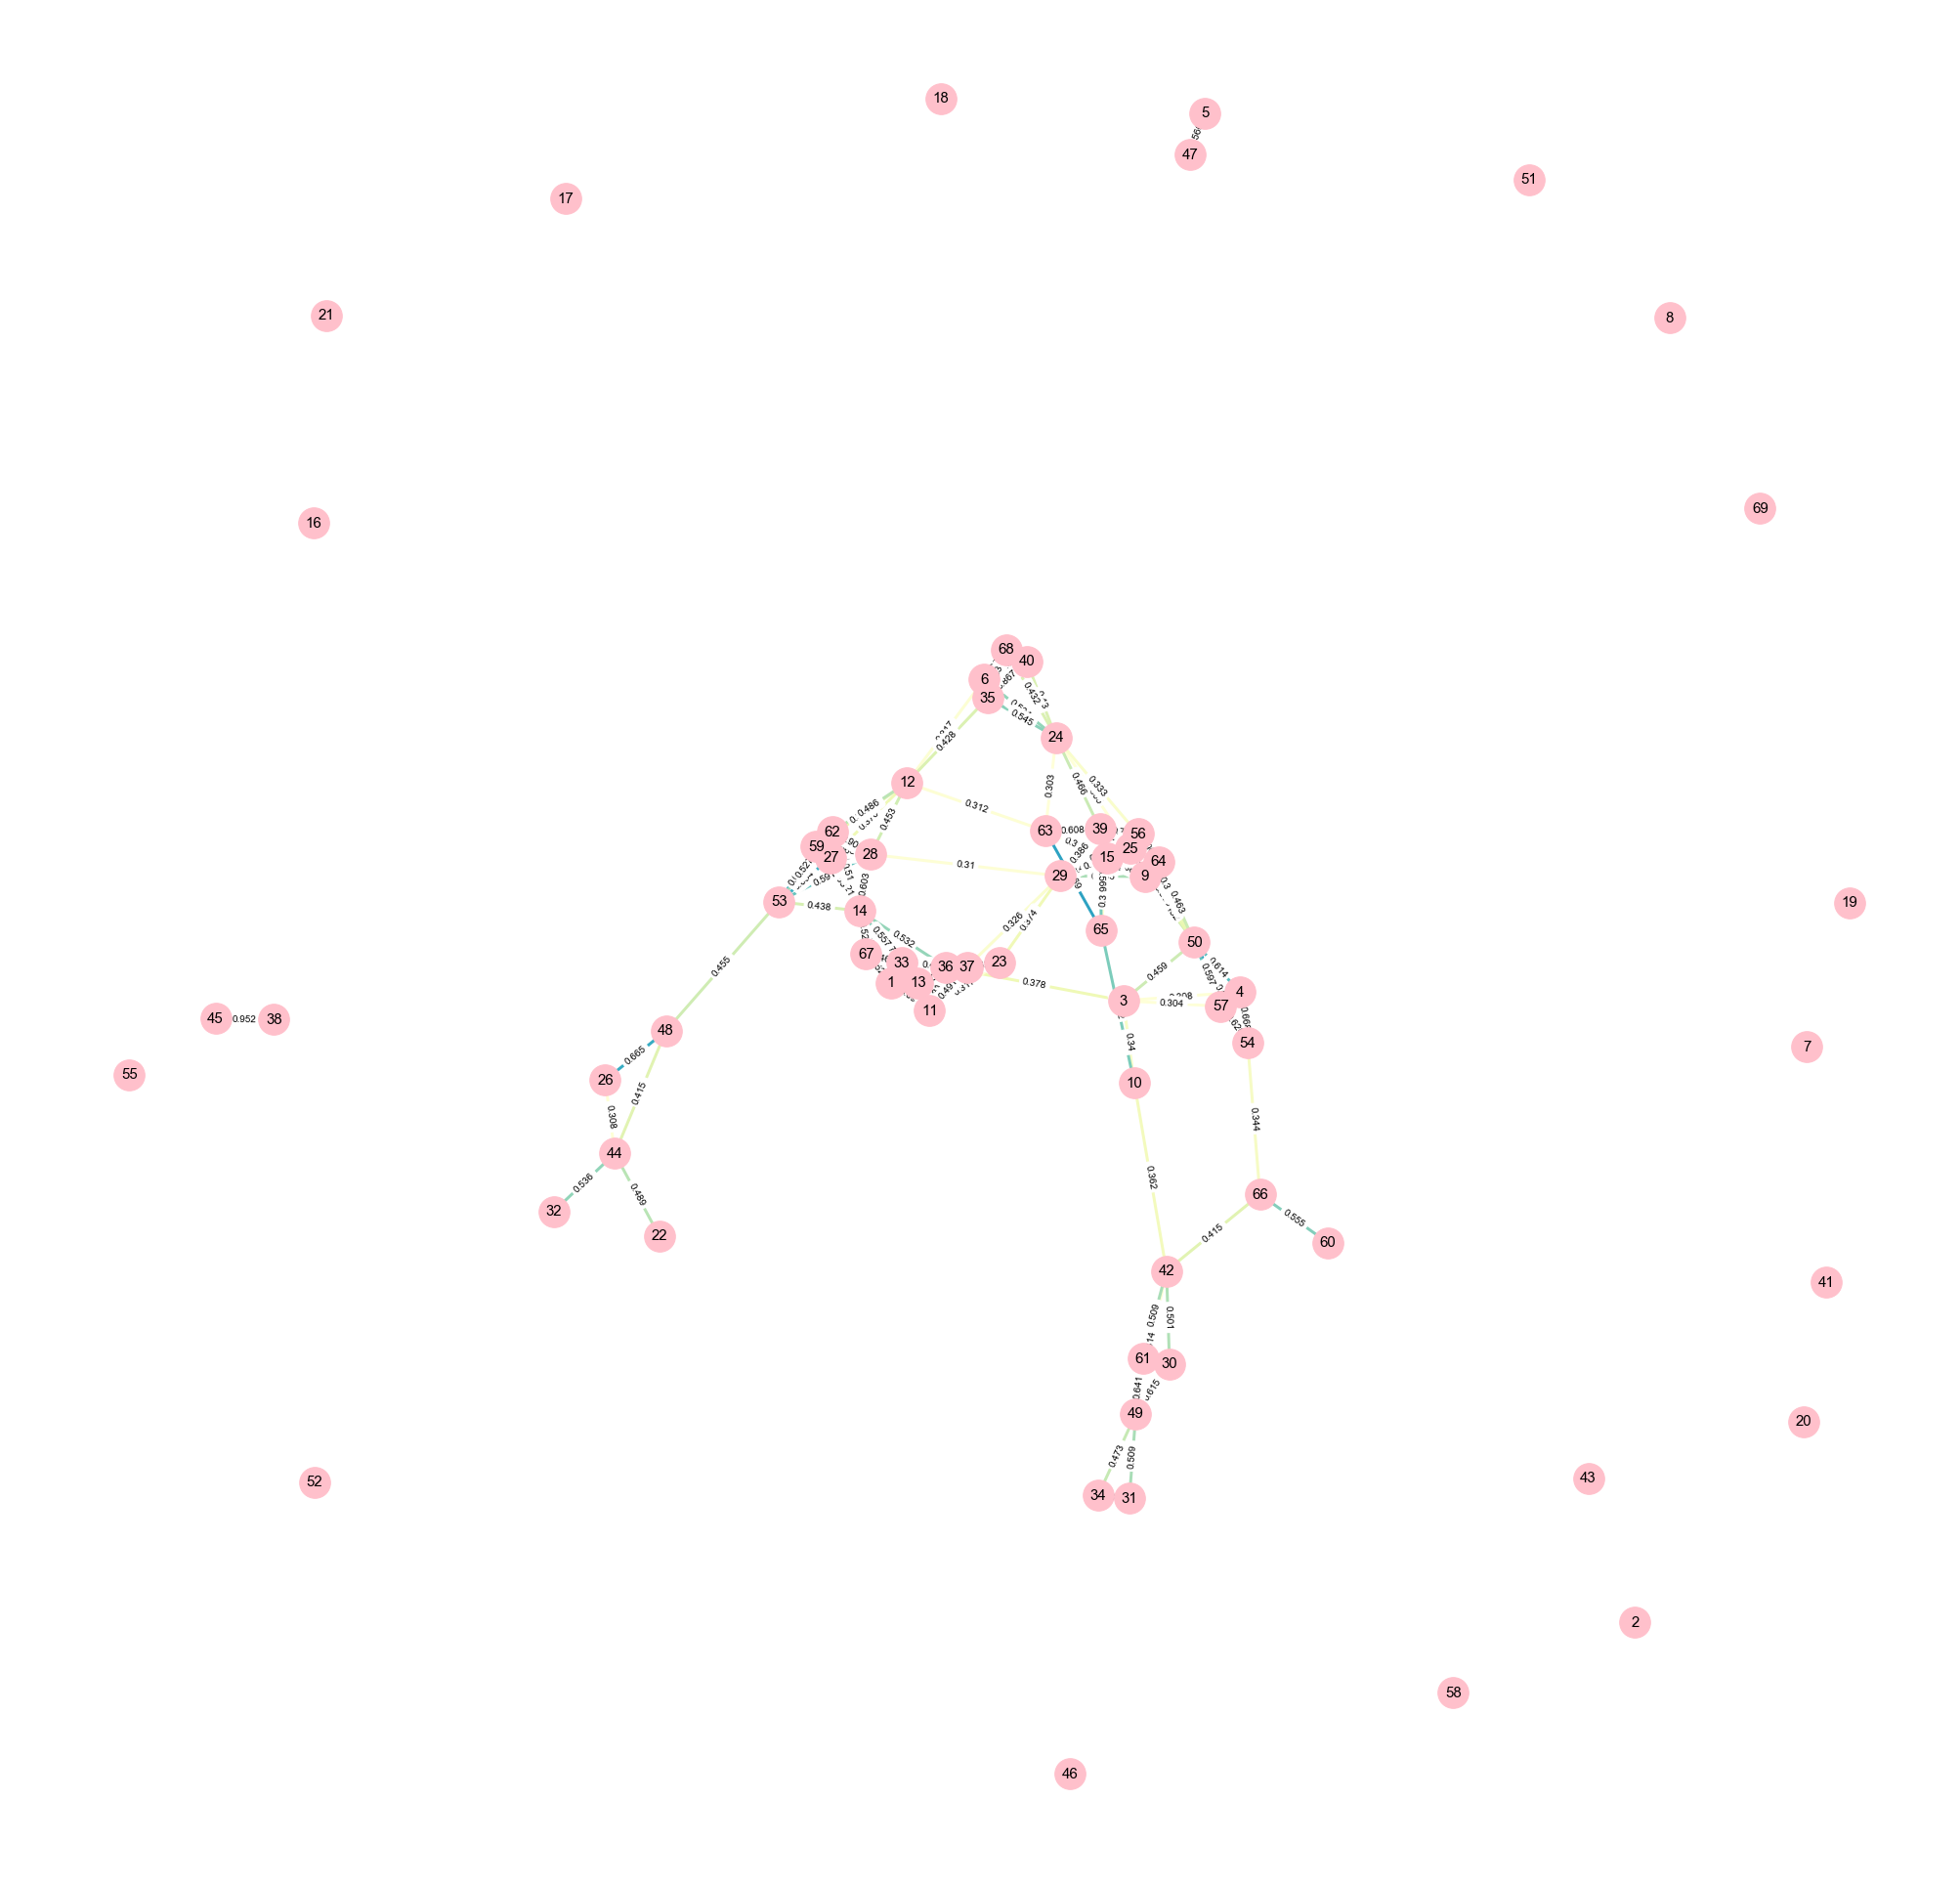

In [72]:
time_binned_dfs = bin_by_time(cell_transients_dataframe, freq="1Min")

for i in range(len(time_binned_dfs)):
    open_graph = gau.create_graph(time_binned_dfs[i].reset_index(drop=True))
    gau.plot_cluster_graph(open_graph, figsize=(35,35), node_color="pink", node_size=1000)

## We get all of the indices in which DRD87 was marked as in the **OpenArms**, and we establish all the 1 minute intervals of that behavior. Namely, we create a separate dataframe for each minute of activity in the **OpenArms**.

## Then, we loop through all of the dataframes we created, and we plot their representations as graphs. Note: we reset (and drop the old) index prior to passing it to the `create_graph()` function.

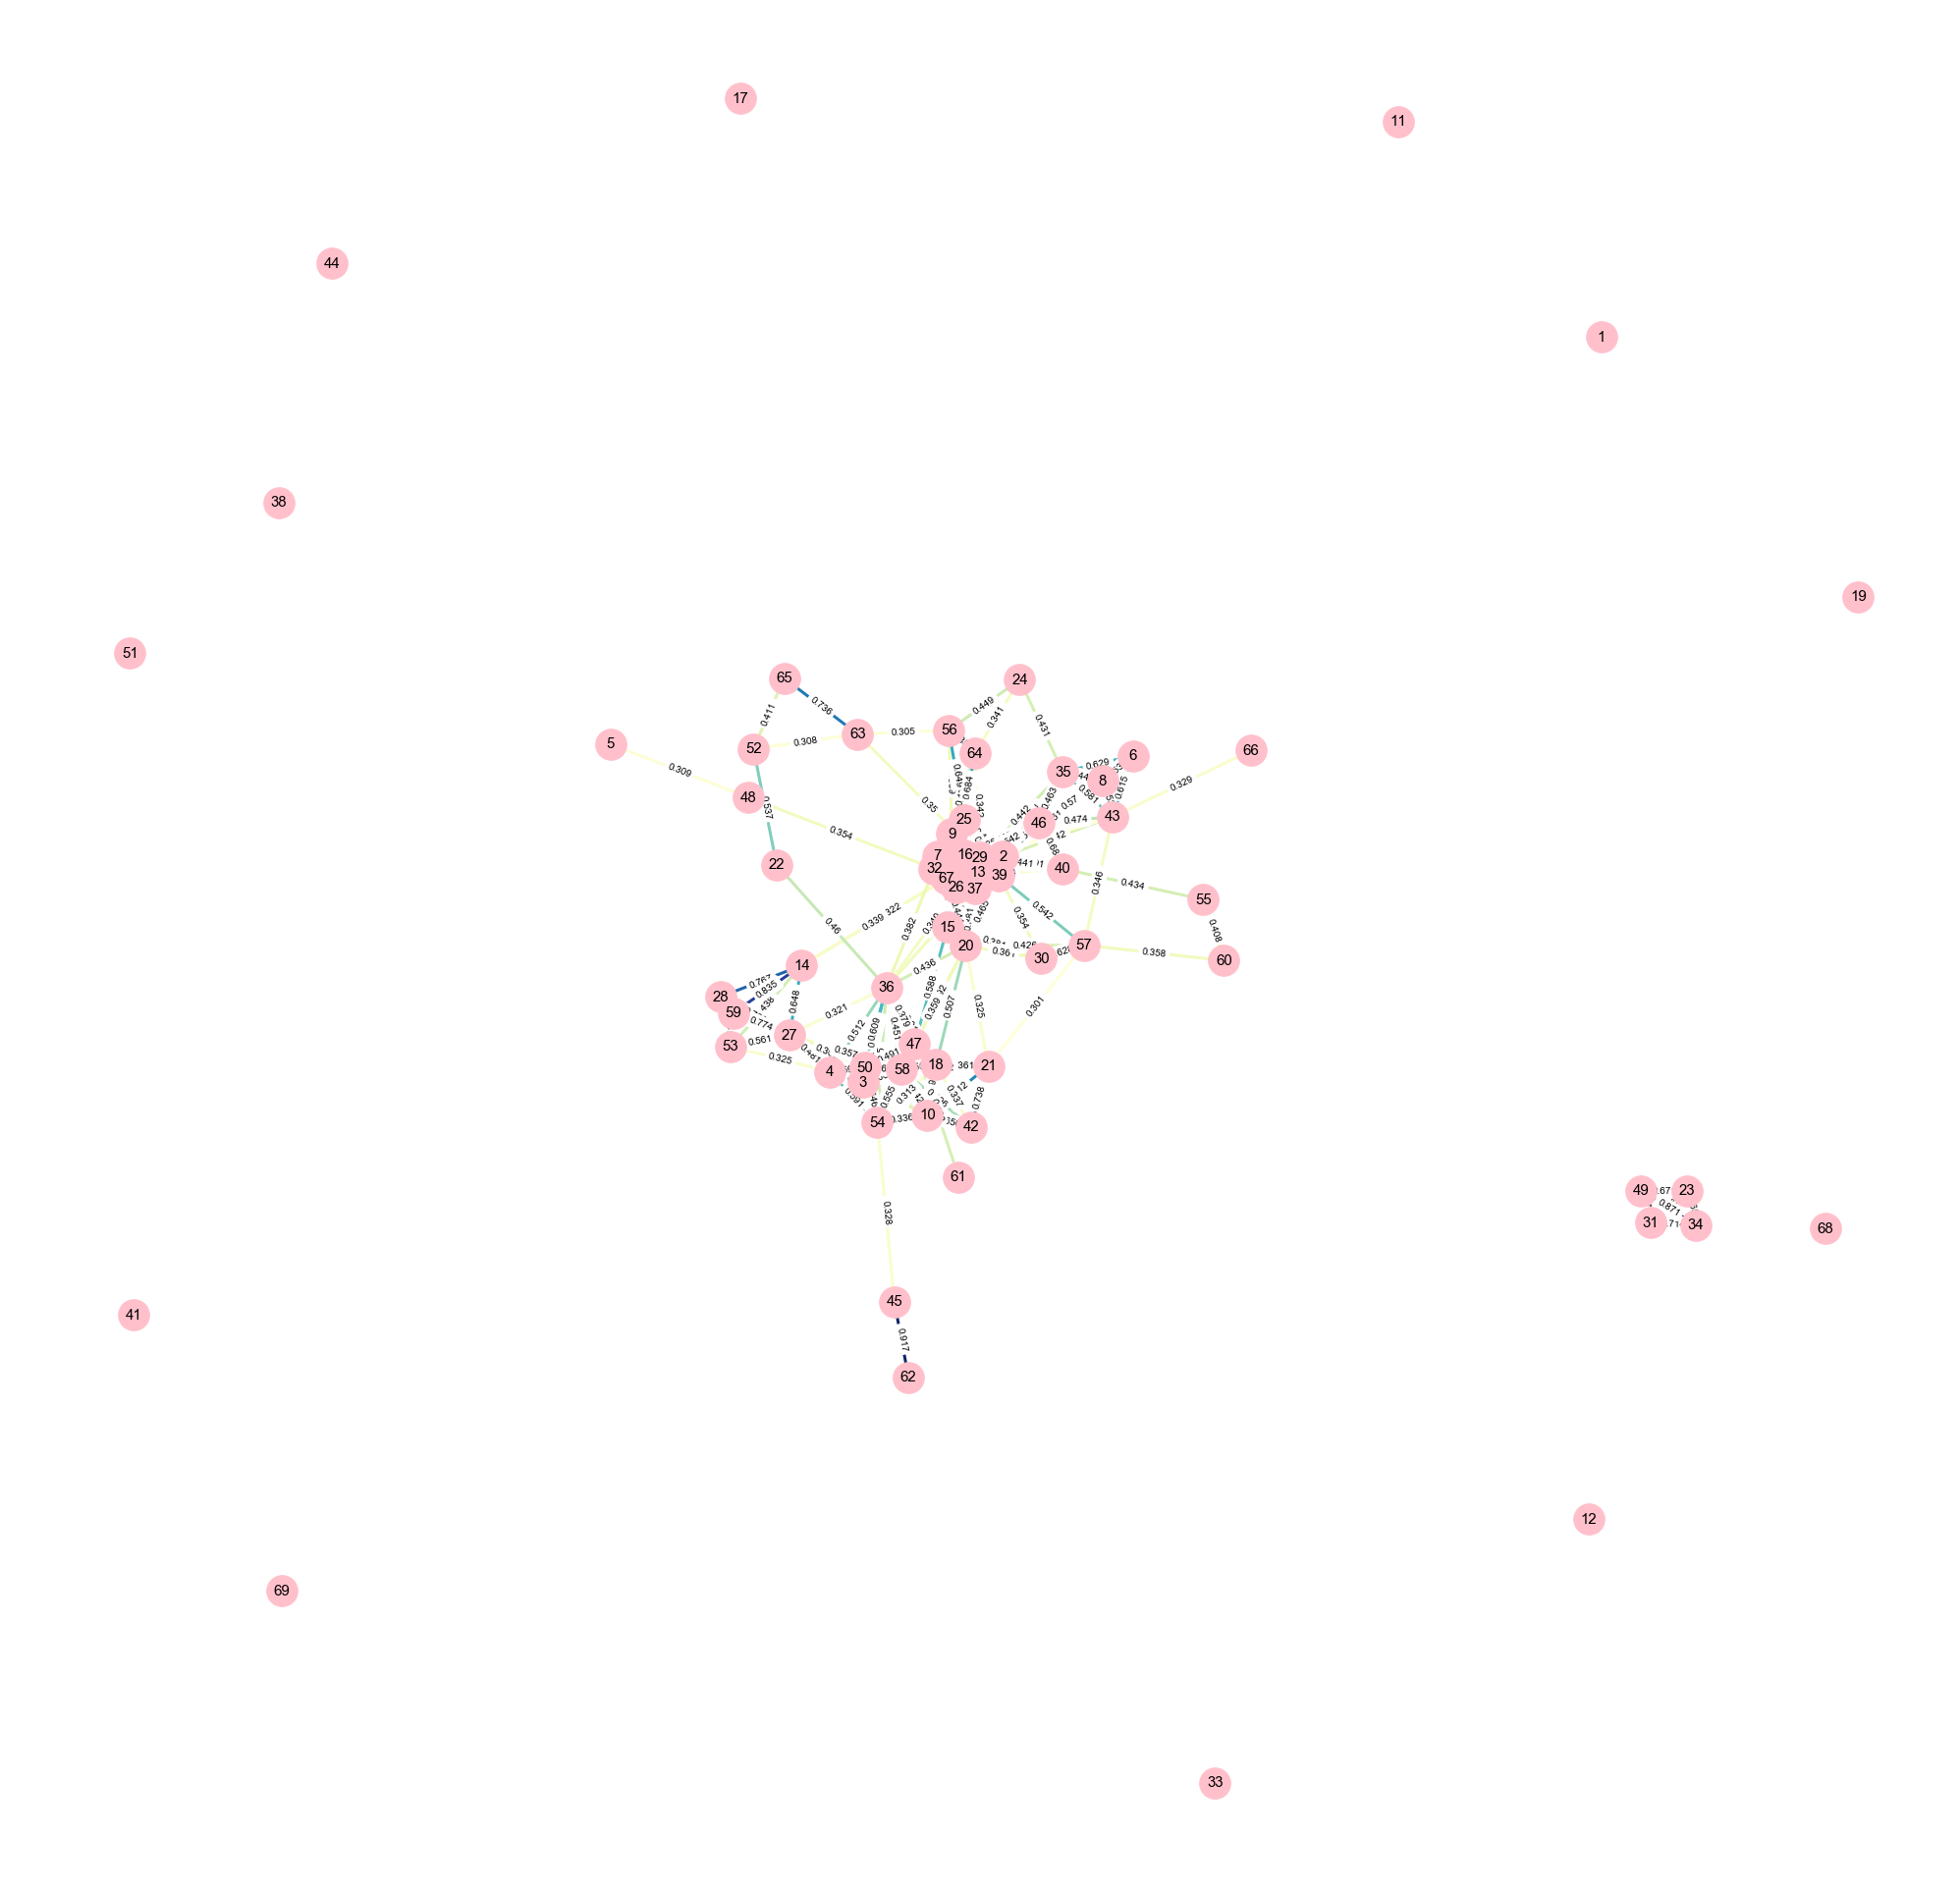

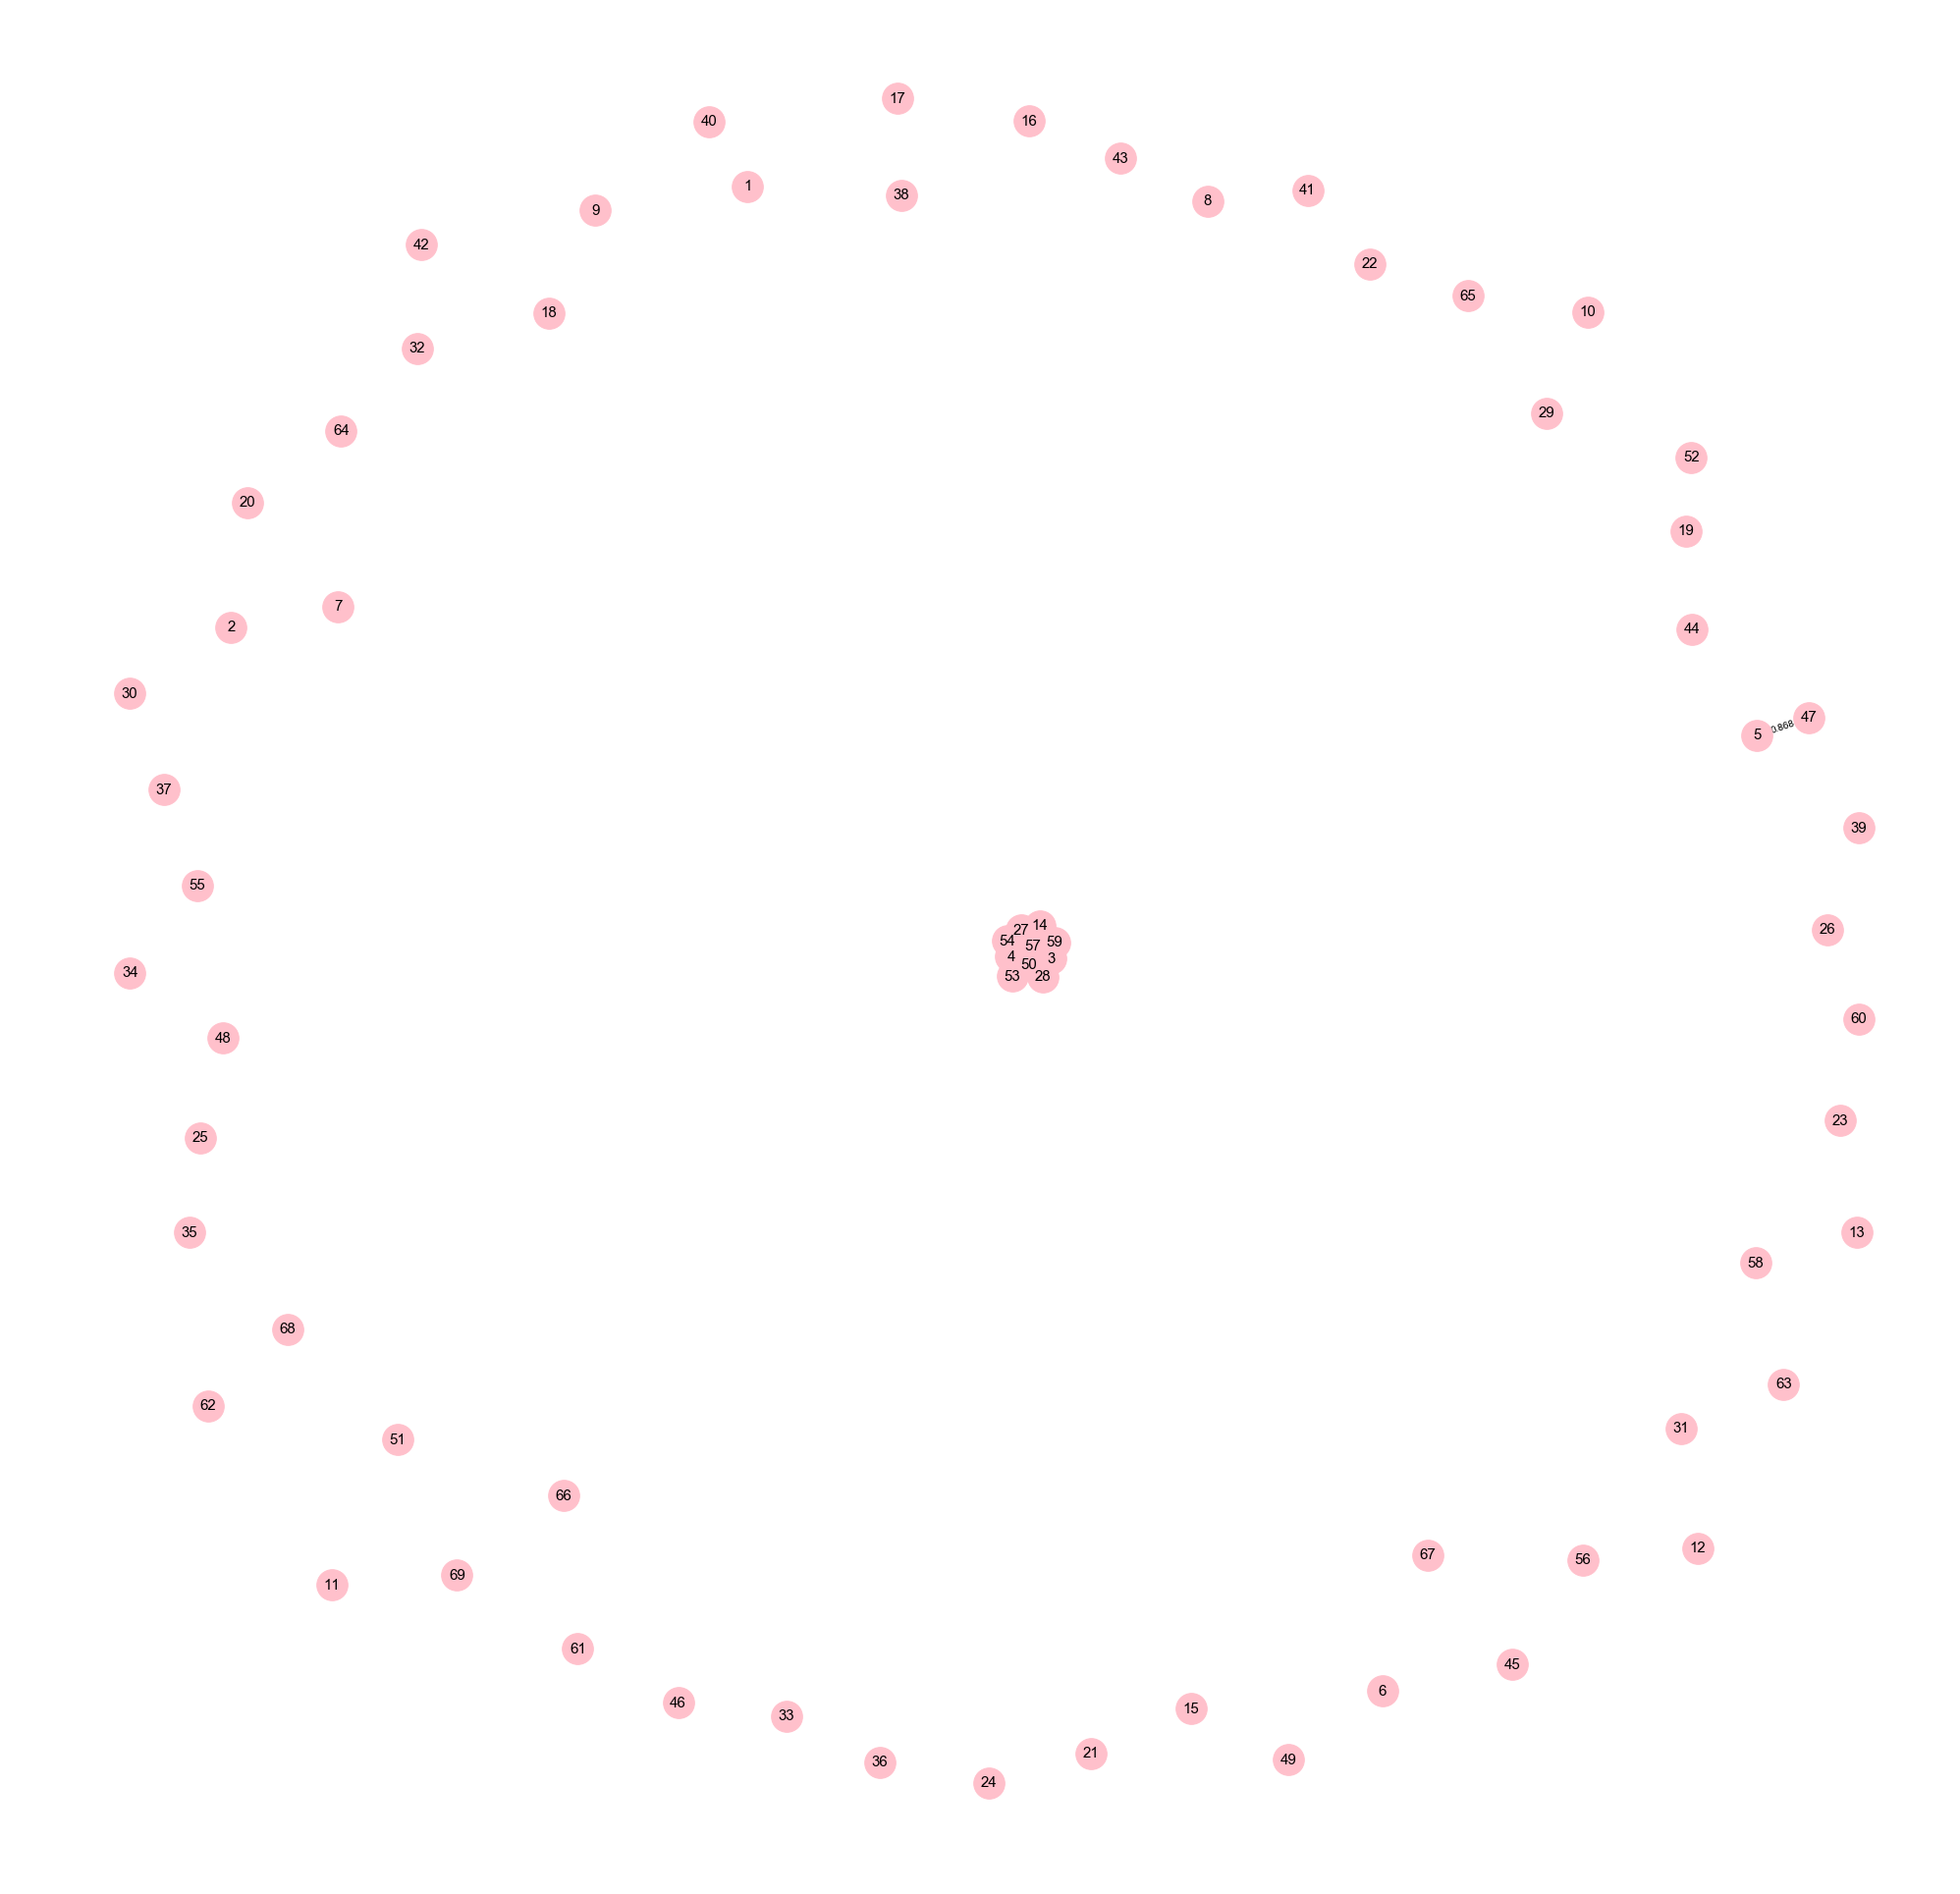

In [78]:
indices = neuron_concated_behavior.loc[neuron_concated_behavior["OpenArms_centerpoint"] != 0].index
time_binned_dfs = bin_by_time(cell_transients_dataframe.iloc[indices])

for i in range(len(time_binned_dfs)):
    open_graph = gau.create_graph(time_binned_dfs[i].reset_index(drop=True))
    gau.plot_cluster_graph(open_graph, figsize=(35,35), node_color="pink", node_size=1000)

## Now we repeat the same exact procedure, but for the **ClosedArms**

In [ ]:
indices = neuron_concated_behavior.loc[neuron_concated_behavior["ClosedArms_centerpoint"] != 0].index
time_binned_dfs = bin_by_time(cell_transients_dataframe.iloc[indices], freq="15s")

for i in range(len(time_binned_dfs)):
    open_graph = gau.create_graph(time_binned_dfs[i].reset_index(drop=True))
    gau.plot_cluster_graph(open_graph, figsize=(35,35), node_color="lightgreen", node_size=1000)

# Now, we plot the networks, over time, for *continous* activity, for certain behaviors. E.g., $5$ seconds of activity in the **OpenArms**

In [35]:
def get_nodes_with_degree(graph):
    nodes = set()
    
    for node in graph.degree():
        if node[1] > 0:
            nodes.add(node[0])
            
    return nodes

537:642
{5, 7, 8, 9, 12, 13, 14, 17, 18, 20, 21, 24, 25, 27, 28, 29, 36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 48, 51, 52, 53, 54, 56, 57, 58, 59, 63, 66, 67, 68, 69}


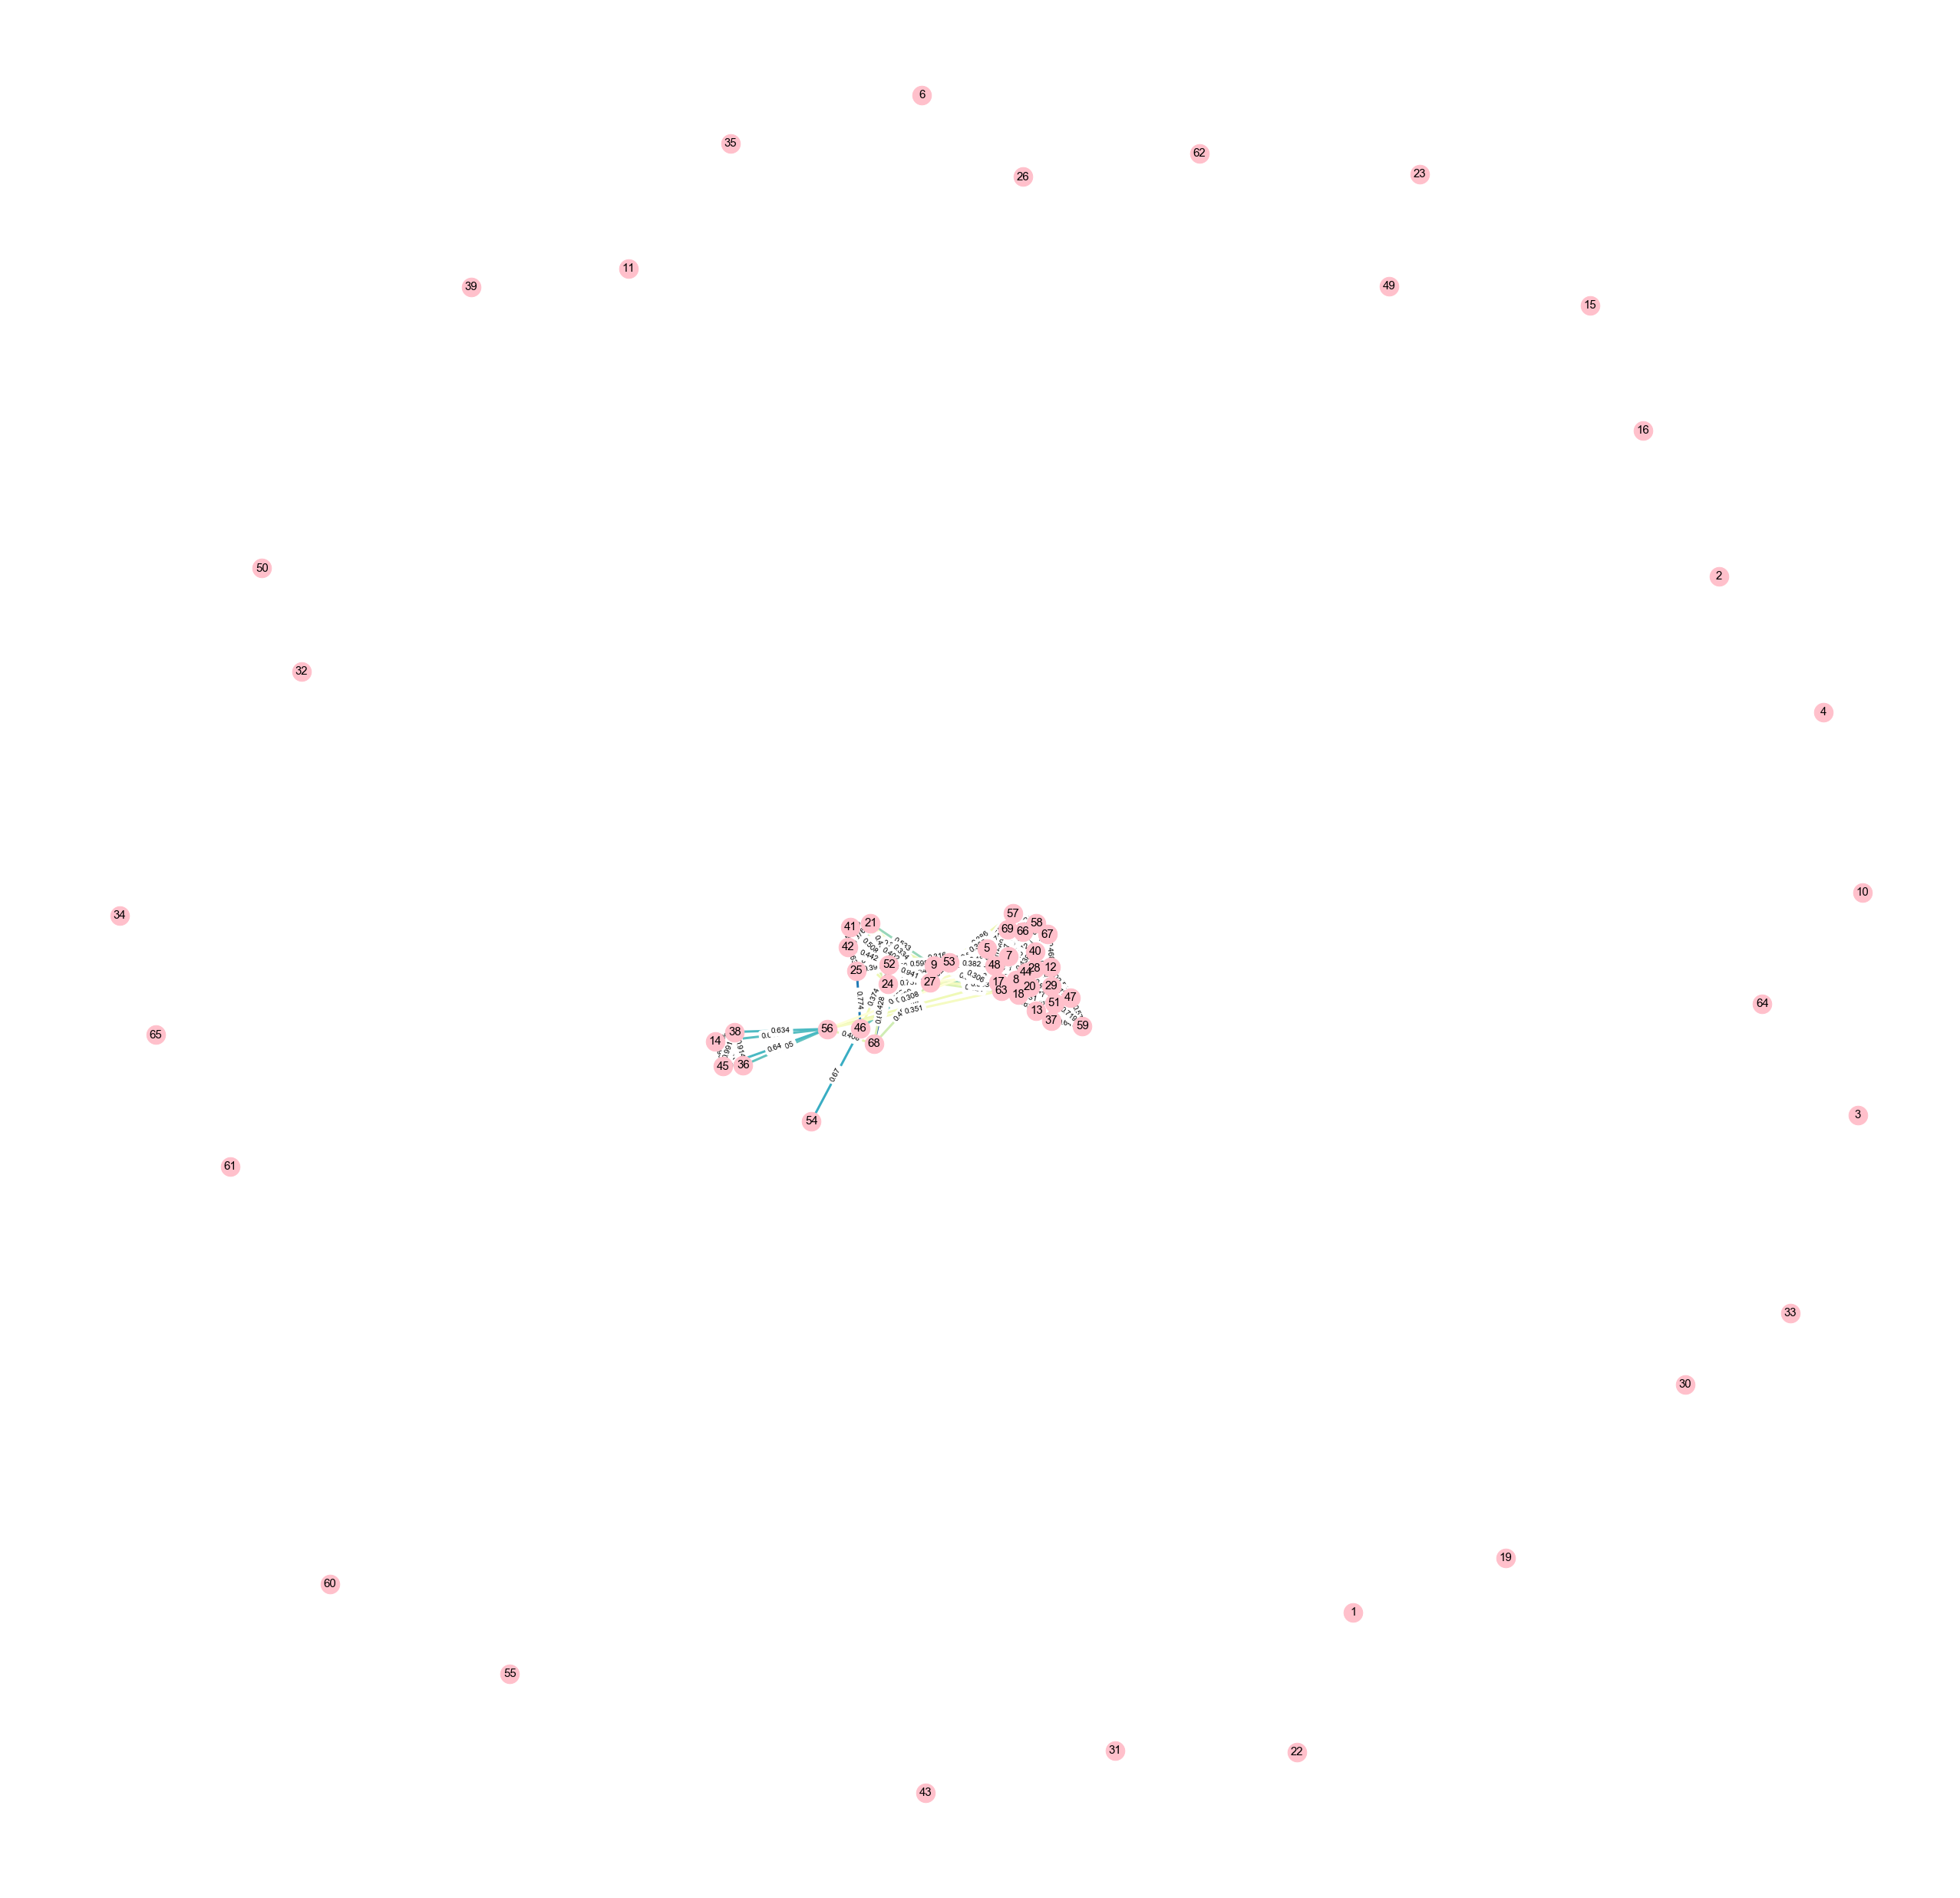

808:882
{5, 9, 16, 17, 18, 20, 23, 25, 27, 40, 46, 47, 48, 53, 57, 58, 60, 63, 64, 66, 67, 69}


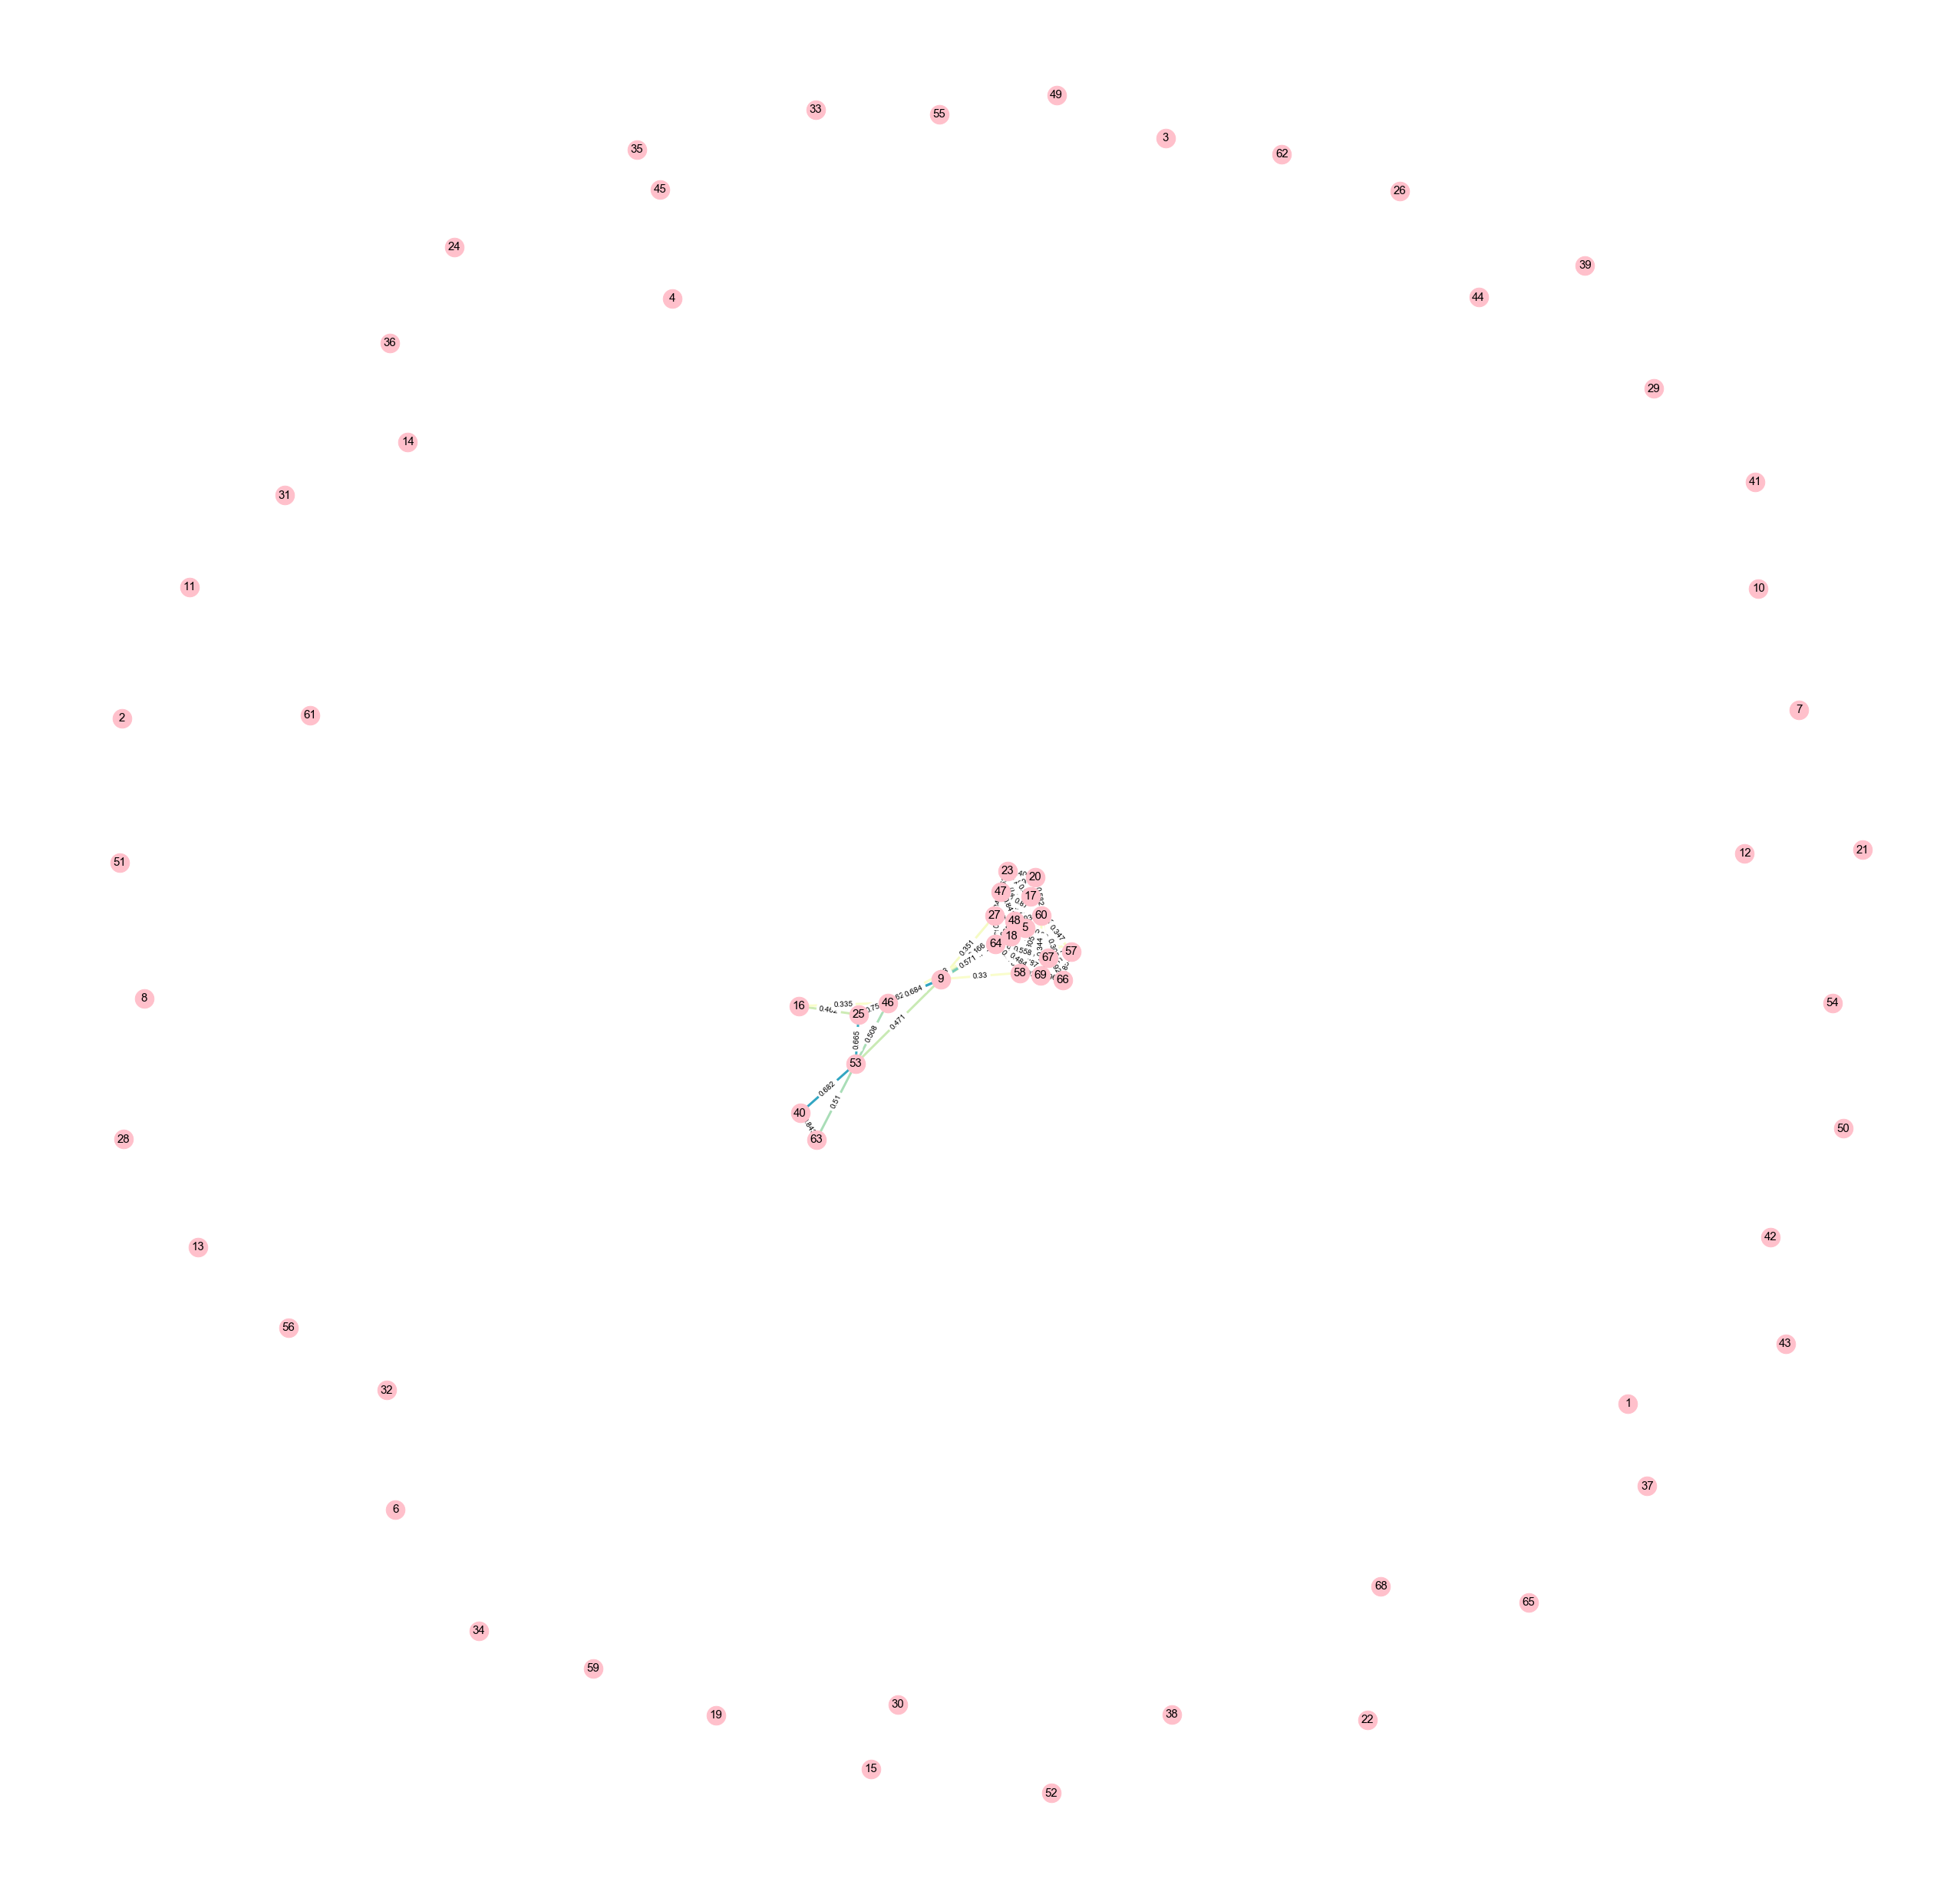

1169:1327
{3, 9, 14, 17, 18, 20, 21, 22, 23, 24, 25, 27, 38, 39, 40, 41, 43, 45, 46, 47, 48, 52, 53, 54, 56, 57, 58, 61, 62, 63, 64, 69}


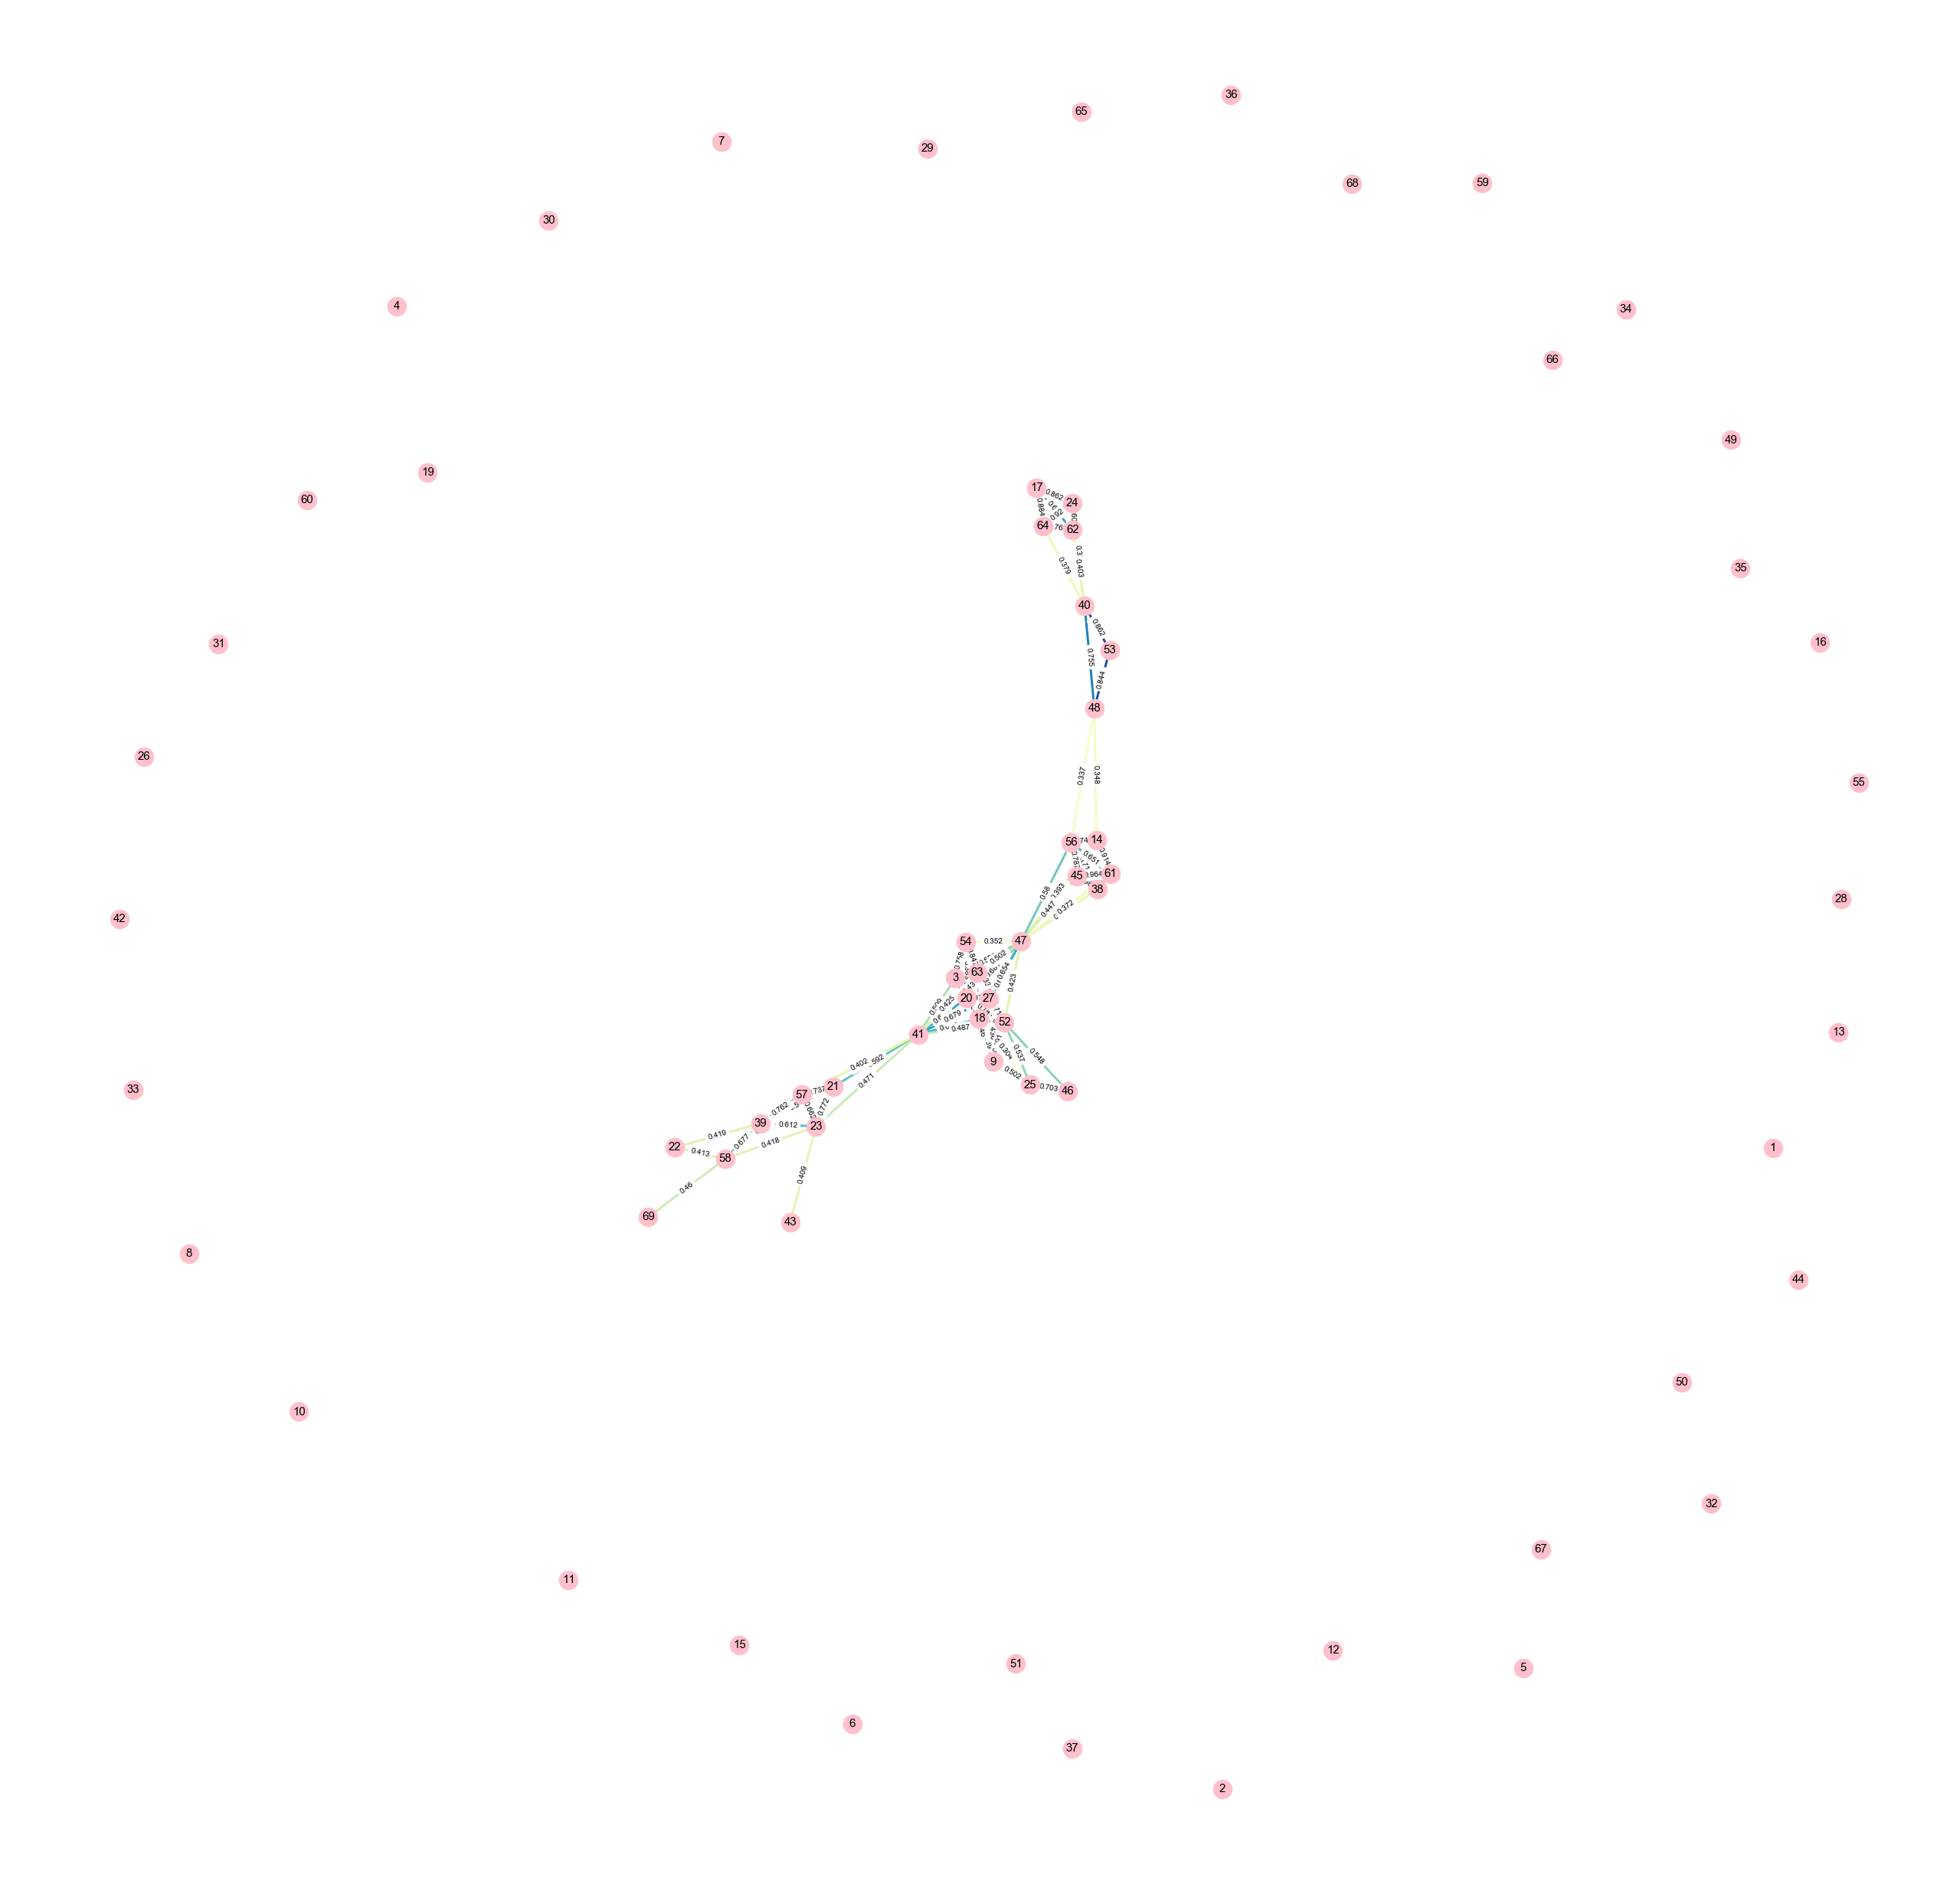

1531:1719
{3, 9, 11, 14, 18, 20, 22, 25, 27, 29, 33, 34, 36, 38, 39, 41, 44, 45, 46, 47, 50, 51, 52, 53, 54, 55, 56, 58, 64, 66}


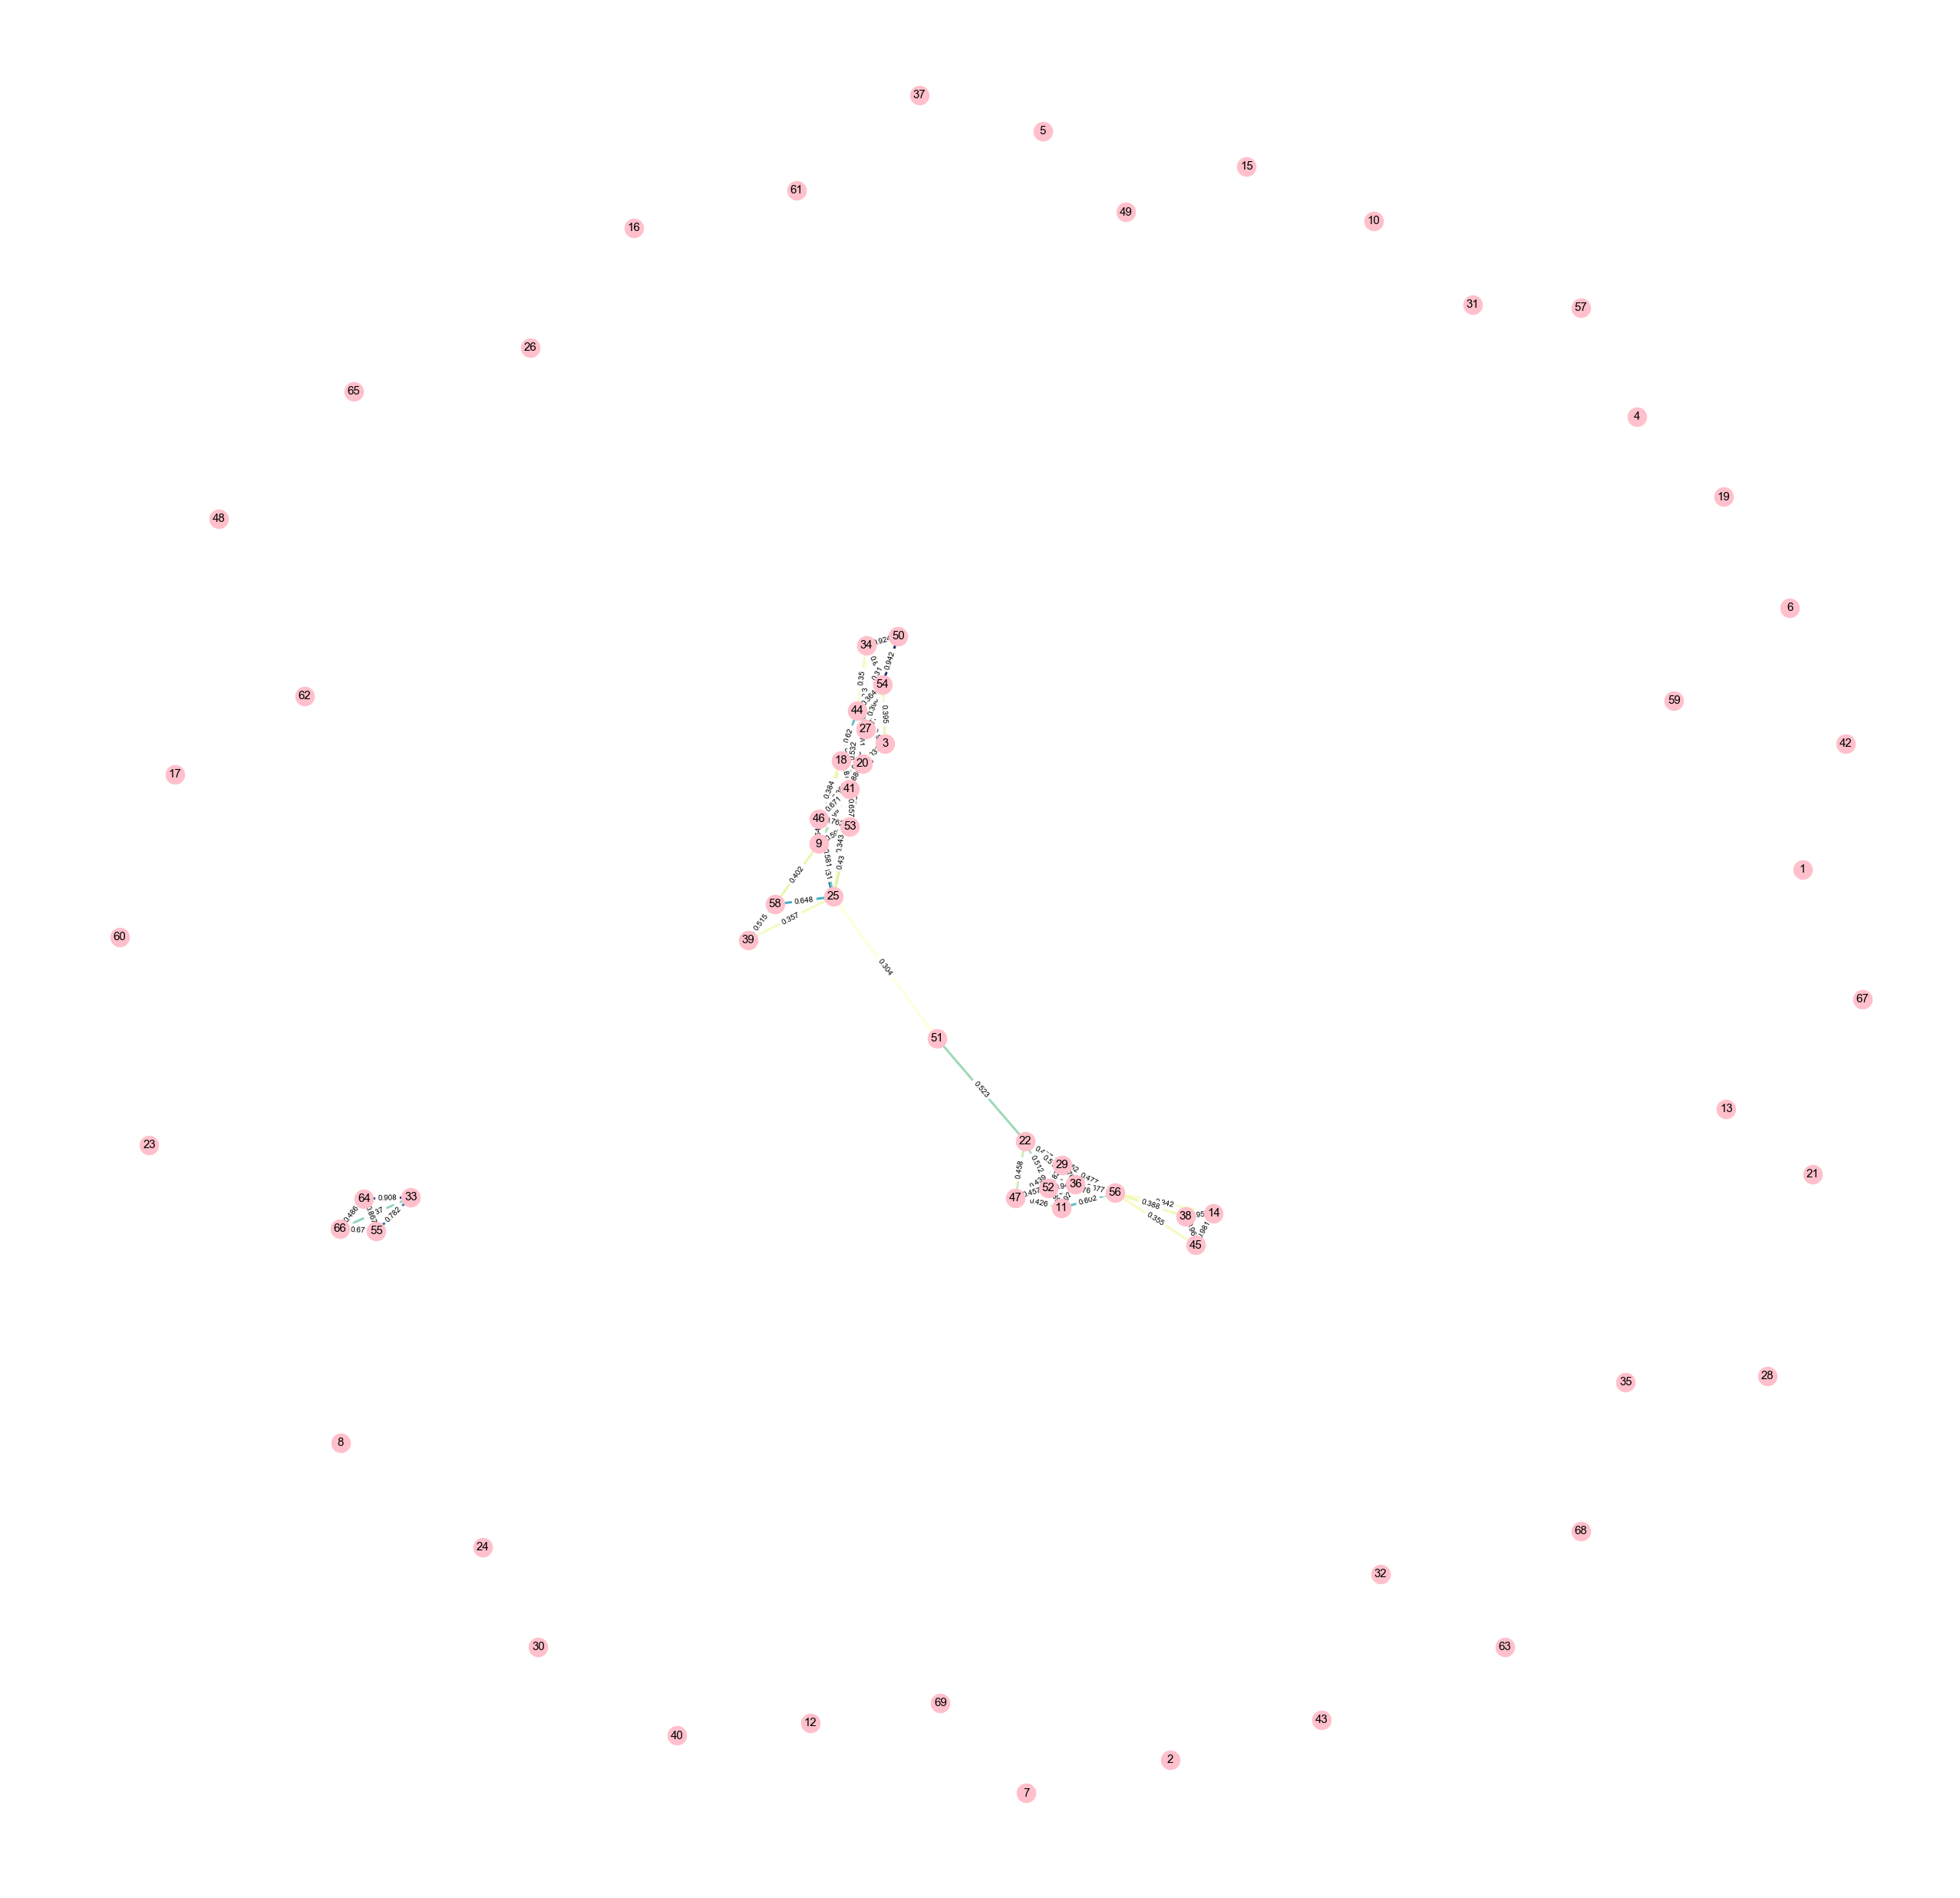

1744:1868
{1, 2, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 22, 24, 25, 29, 30, 32, 33, 34, 36, 39, 40, 41, 43, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 63, 64, 67, 68}


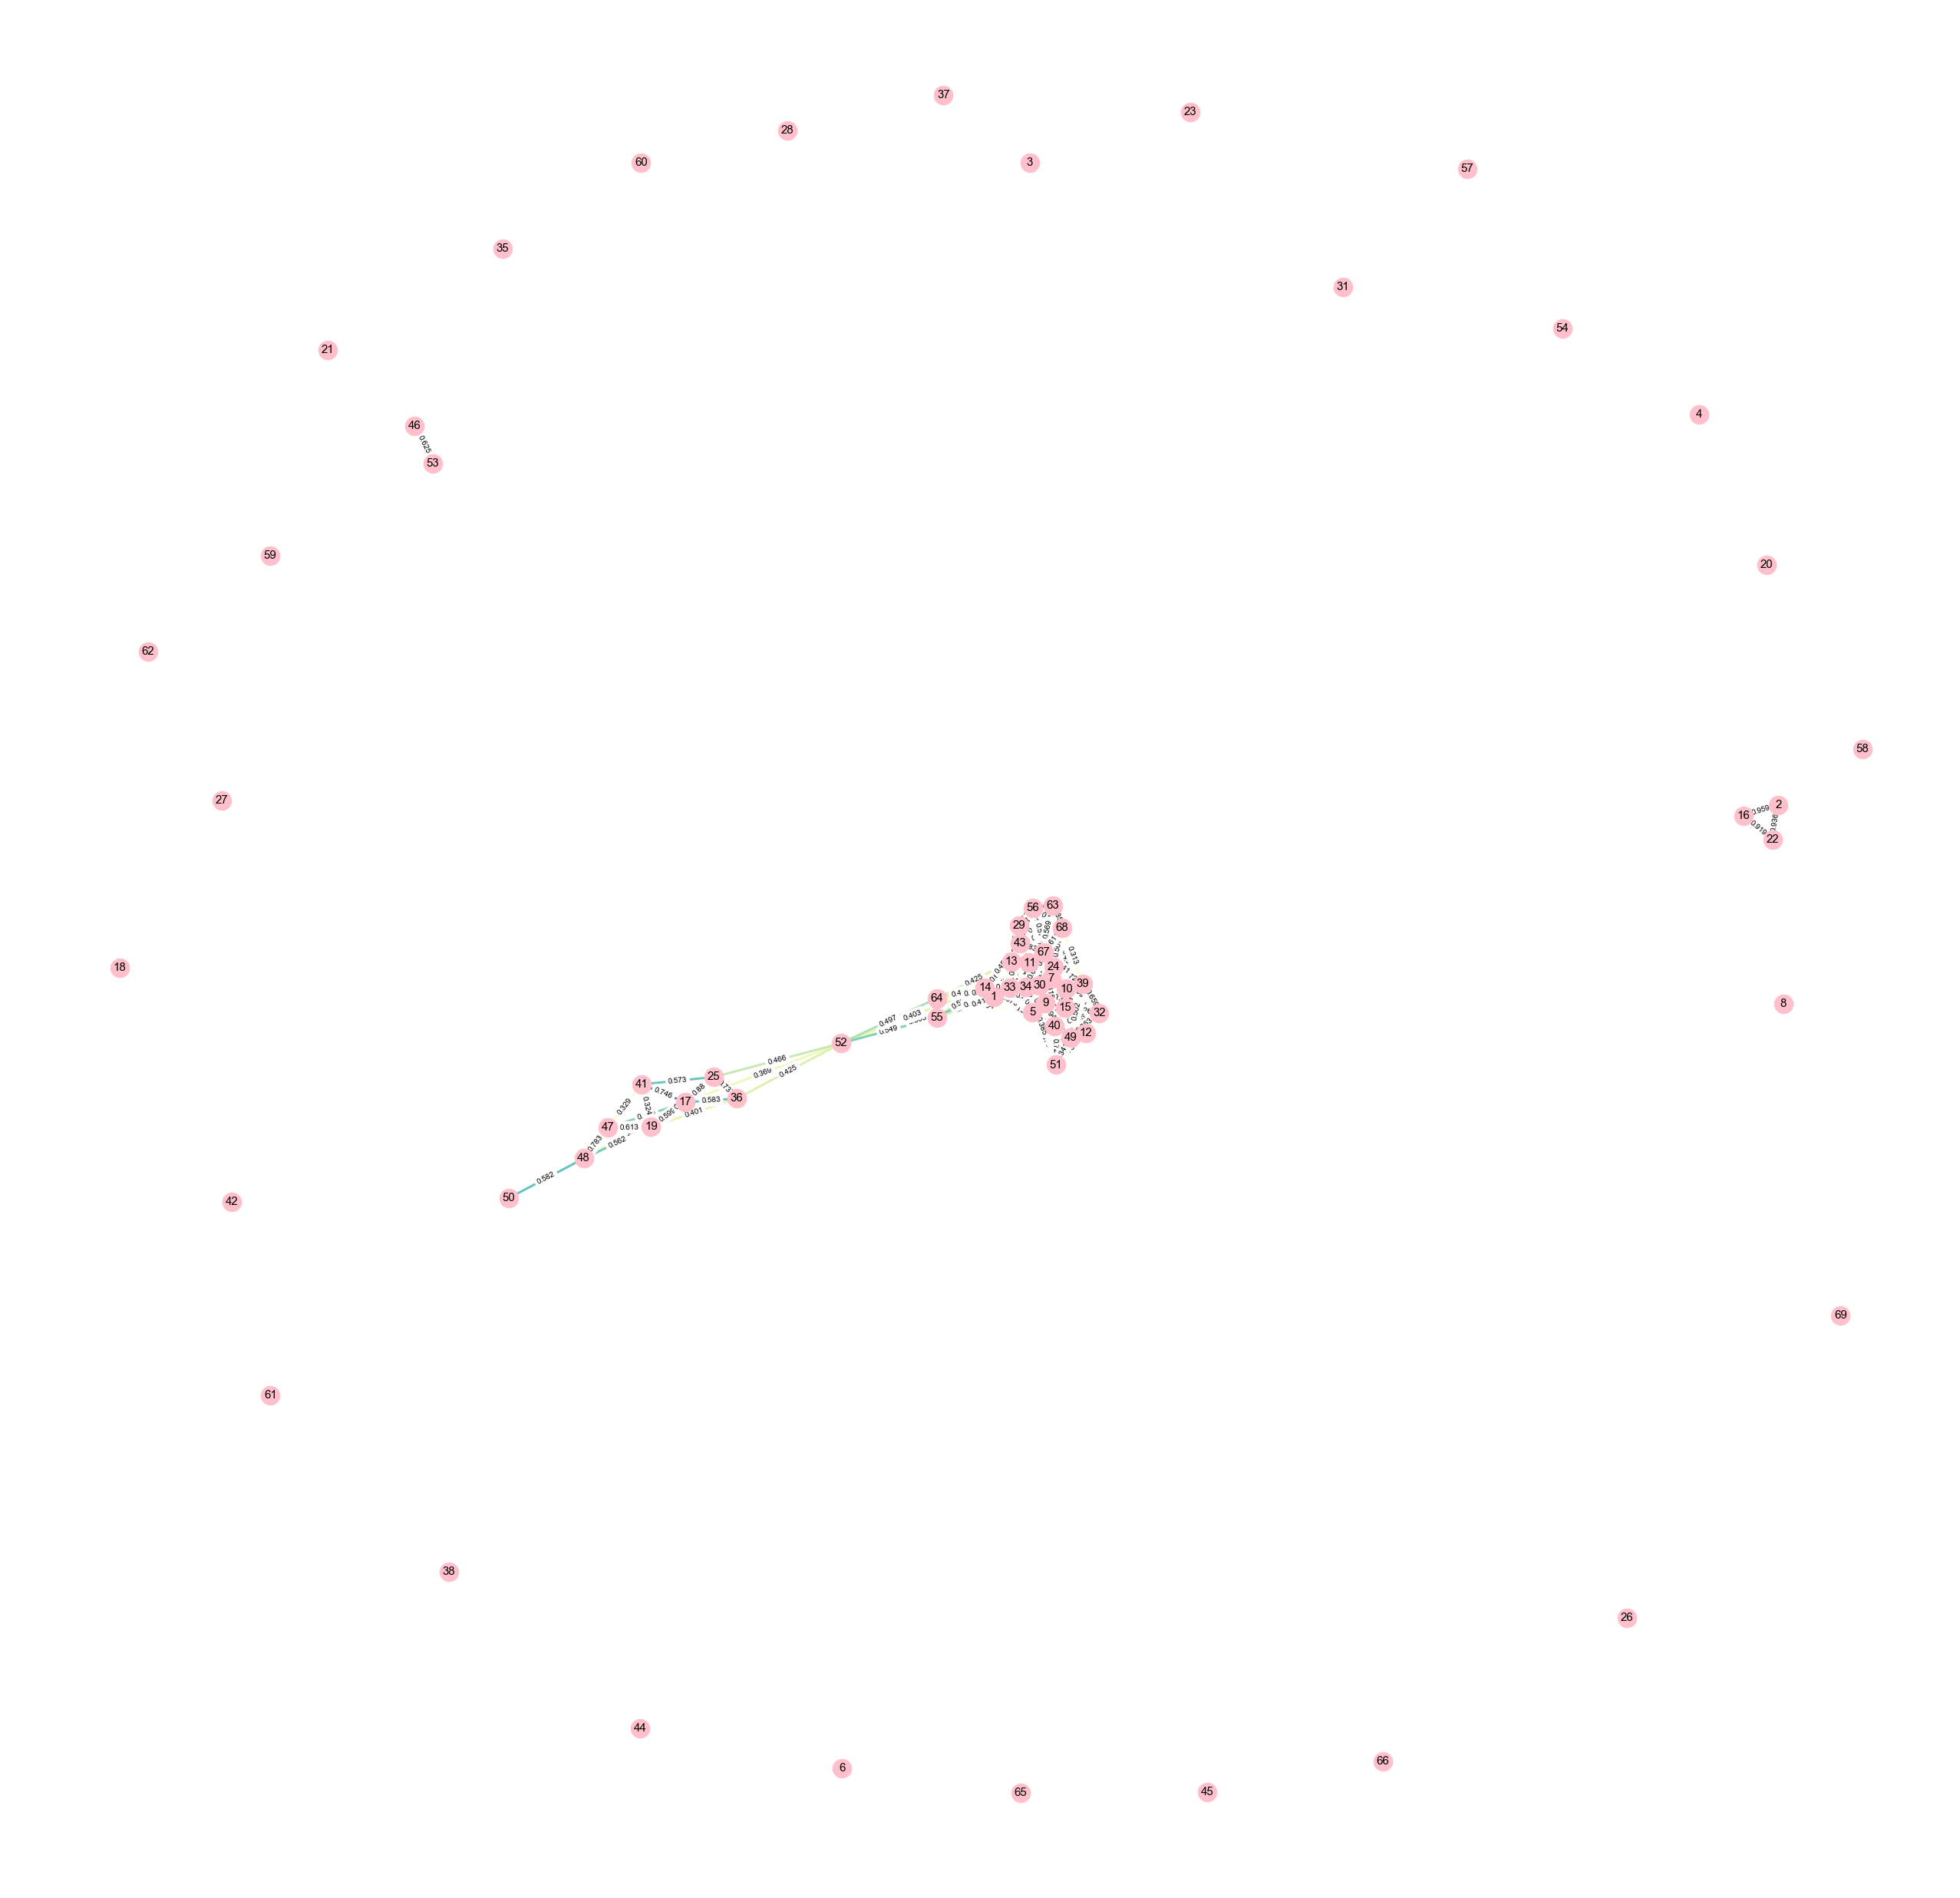

1903:2456
{1, 2, 3, 4, 5, 8, 9, 11, 12, 13, 14, 16, 17, 18, 20, 22, 23, 26, 27, 28, 29, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 61, 63, 64, 65, 66, 67, 68, 69}


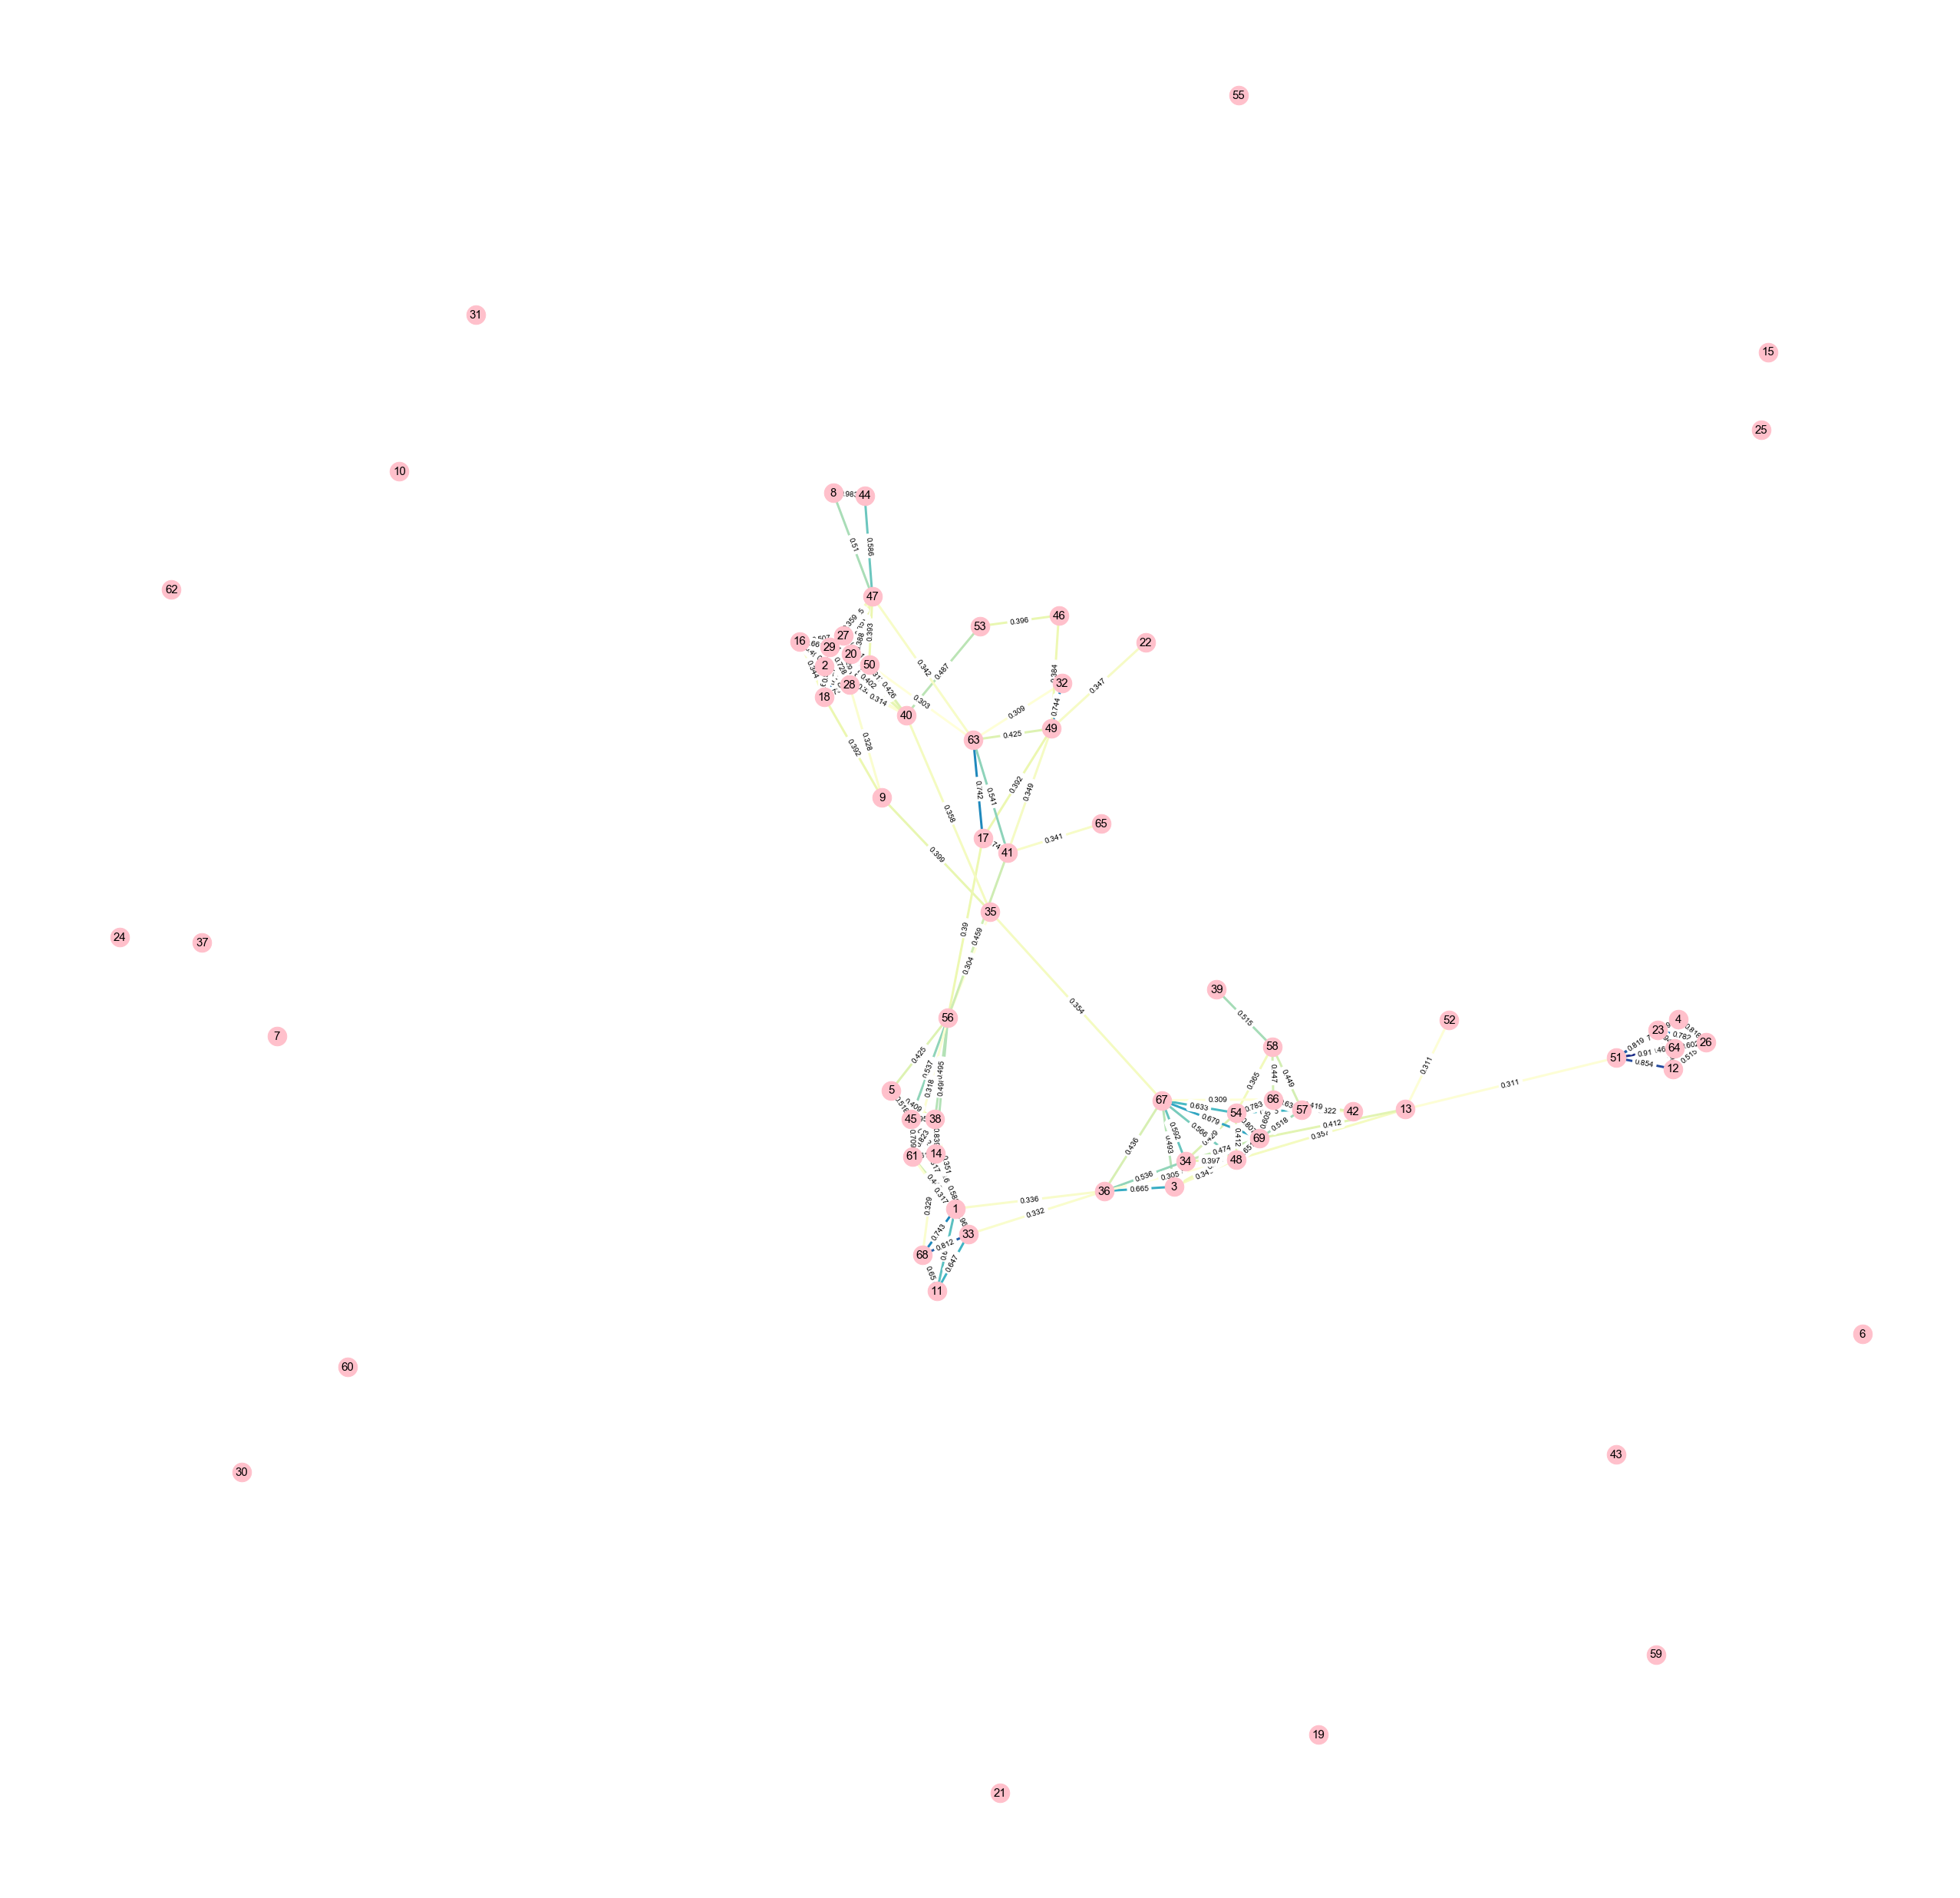

2624:3037
{1, 4, 7, 8, 9, 10, 11, 13, 14, 21, 23, 26, 29, 30, 33, 34, 36, 37, 39, 40, 42, 43, 46, 47, 50, 51, 52, 53, 54, 55, 56, 57, 61, 63, 66, 67, 68}


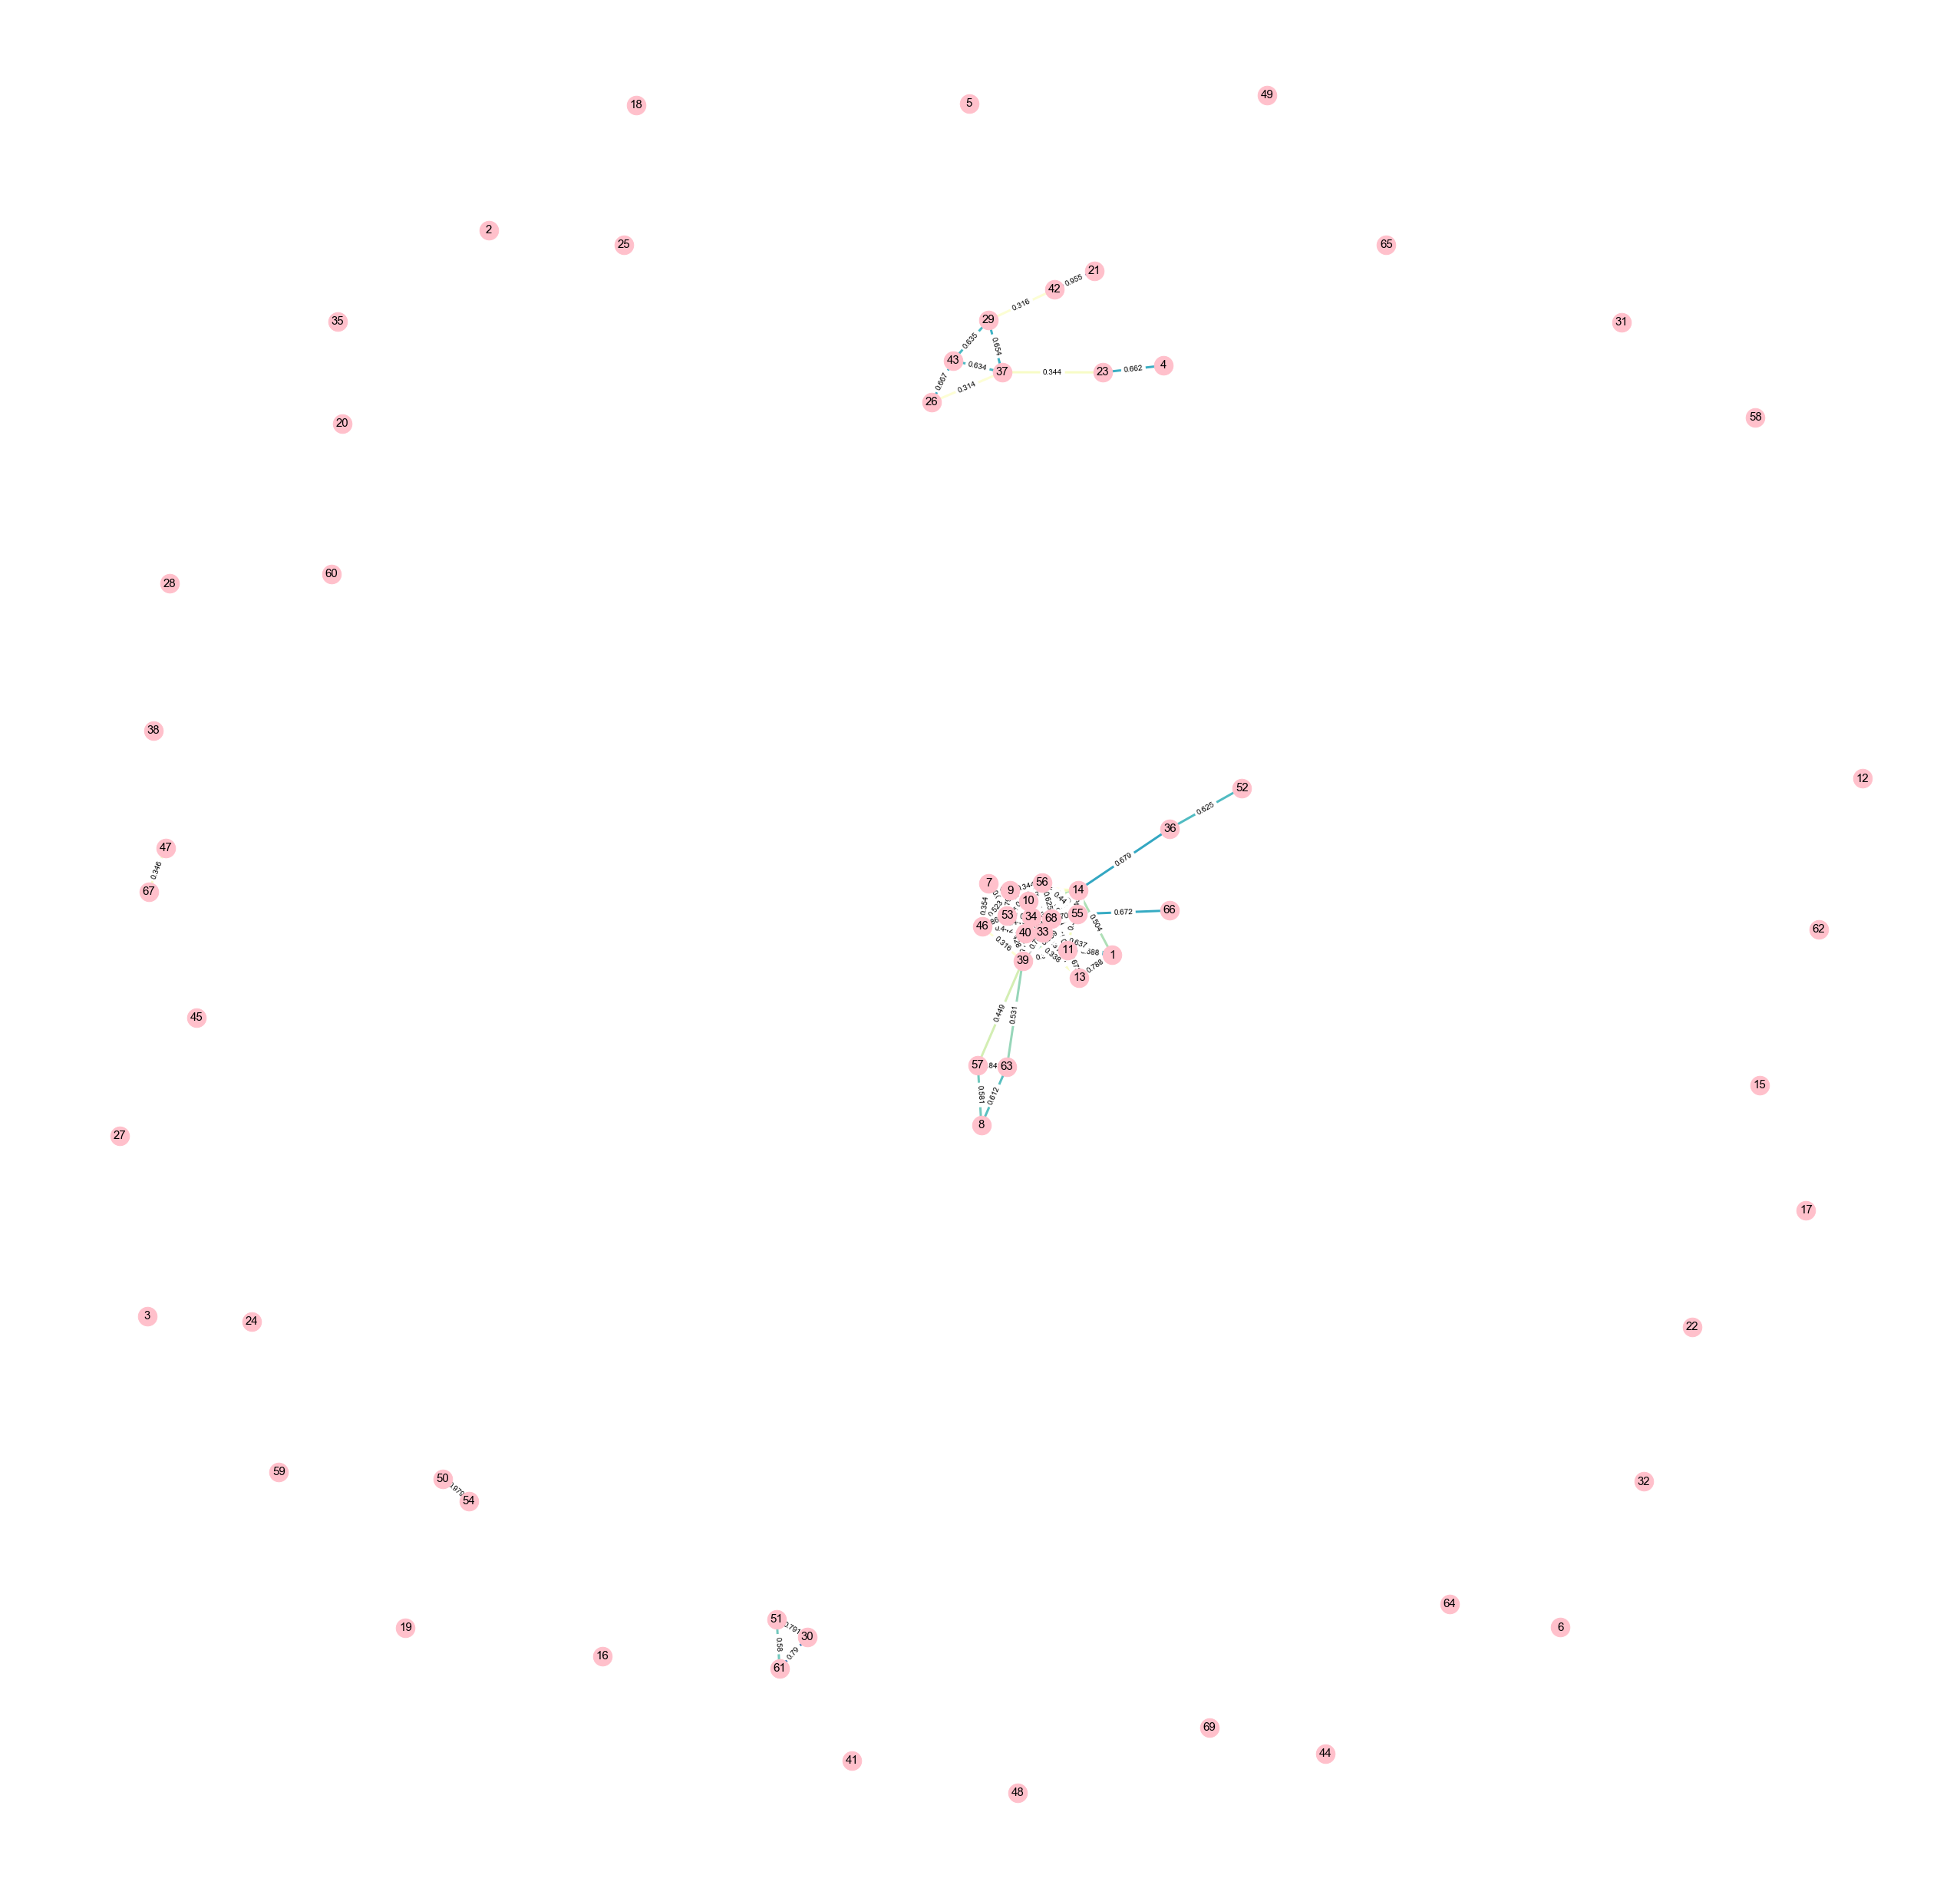

3326:3865
{1, 2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 17, 18, 20, 22, 23, 25, 26, 27, 29, 31, 33, 34, 35, 36, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 61, 63, 64, 66, 67, 68, 69}


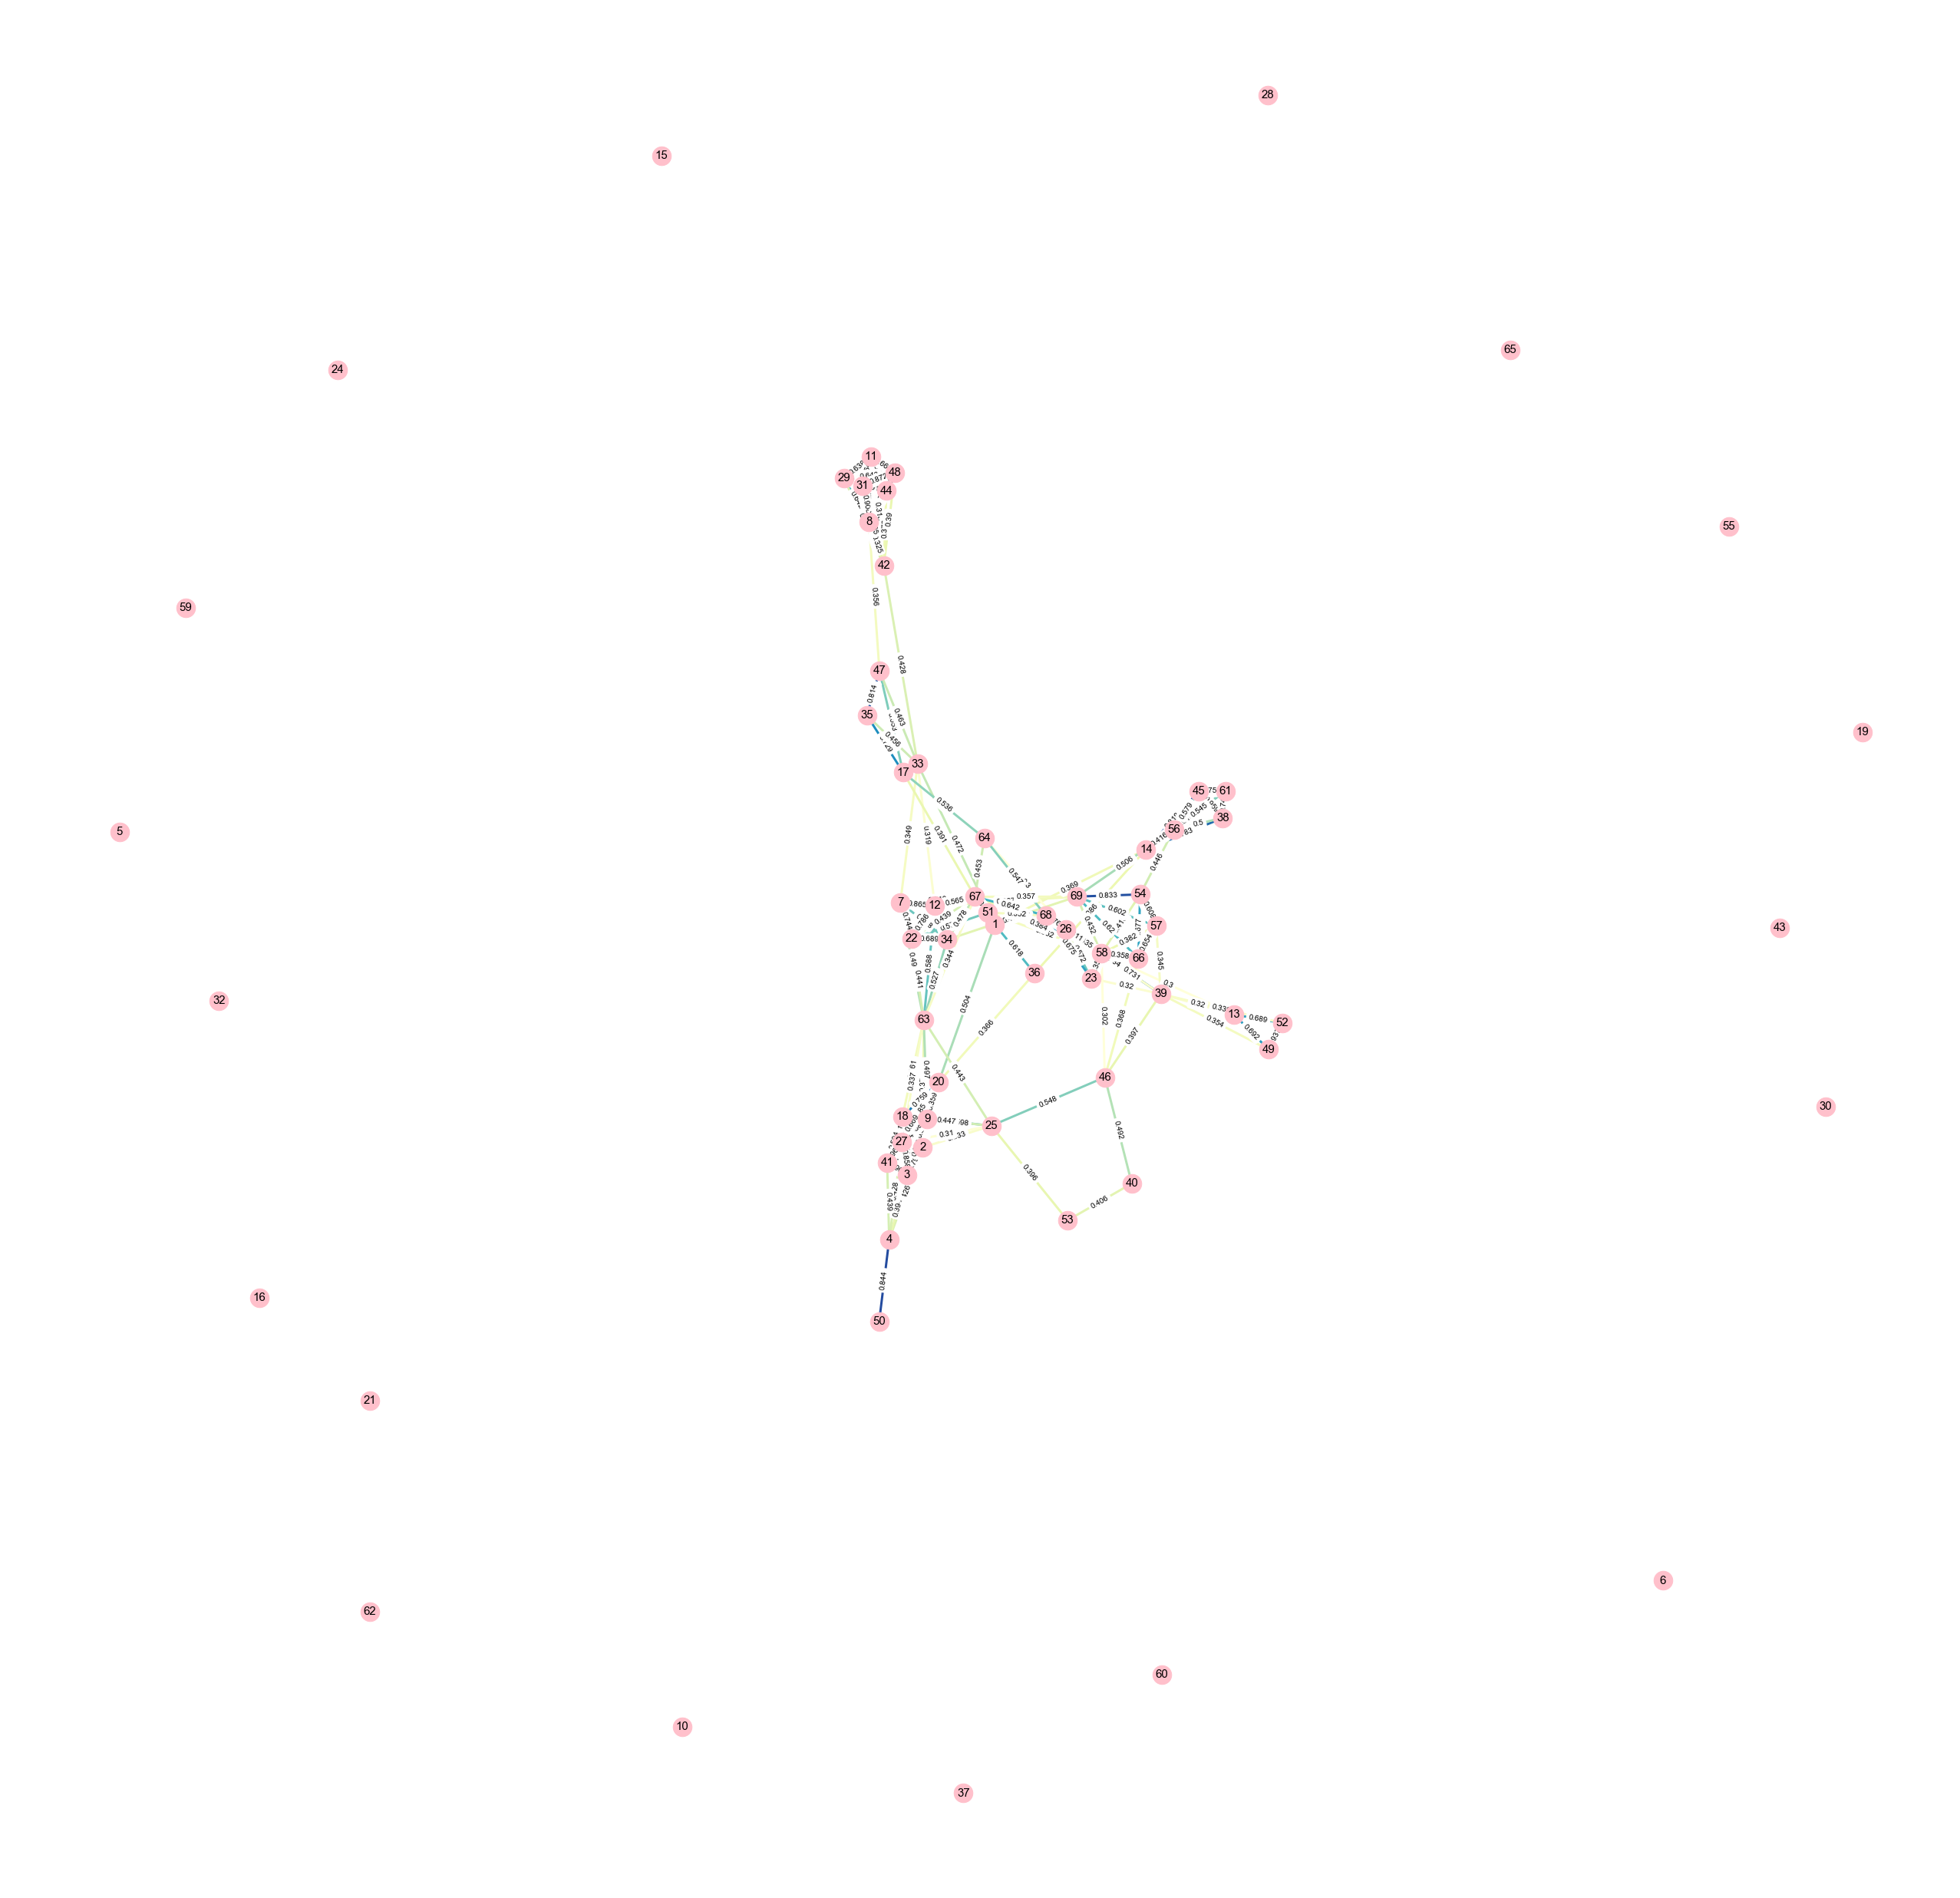

4064:4317
{3, 8, 10, 11, 14, 23, 26, 29, 30, 32, 33, 36, 37, 39, 40, 42, 43, 46, 47, 48, 49, 51, 53, 61, 65, 67}


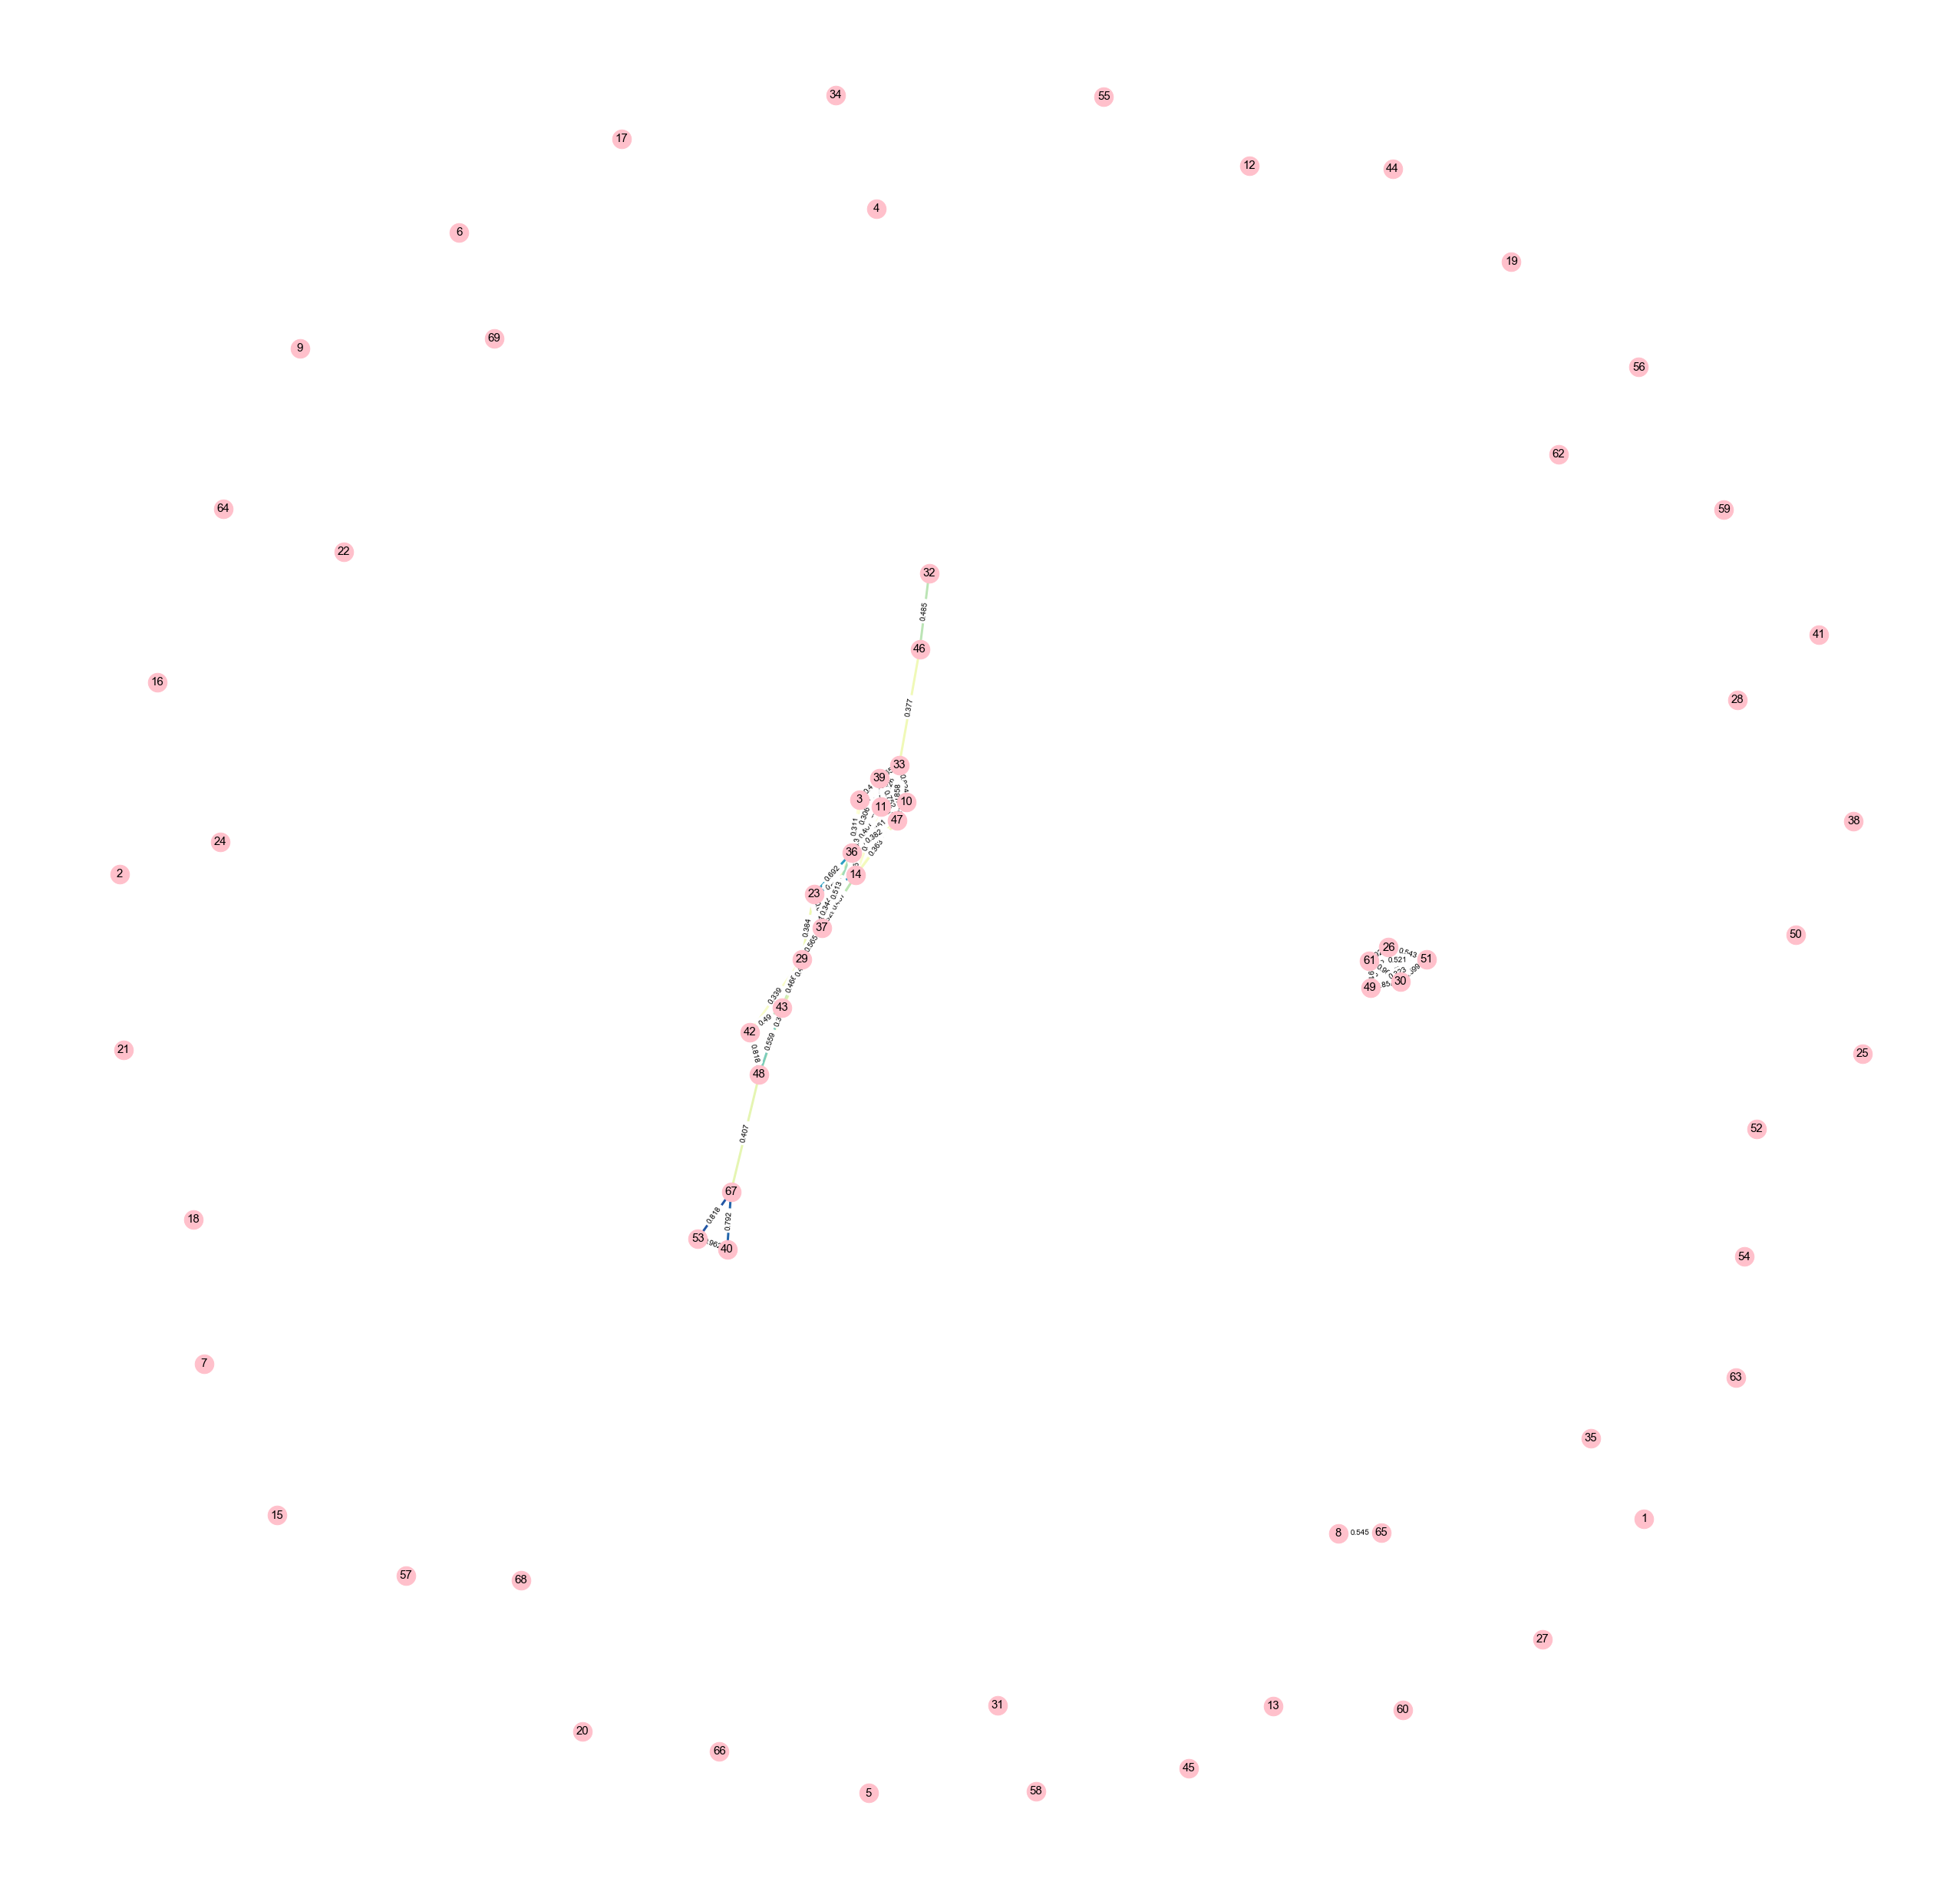

4342:4609
{2, 4, 8, 9, 13, 14, 18, 20, 23, 29, 31, 33, 36, 38, 39, 41, 44, 45, 46, 47, 48, 49, 51, 52, 53, 56, 58, 63, 64, 66, 68}


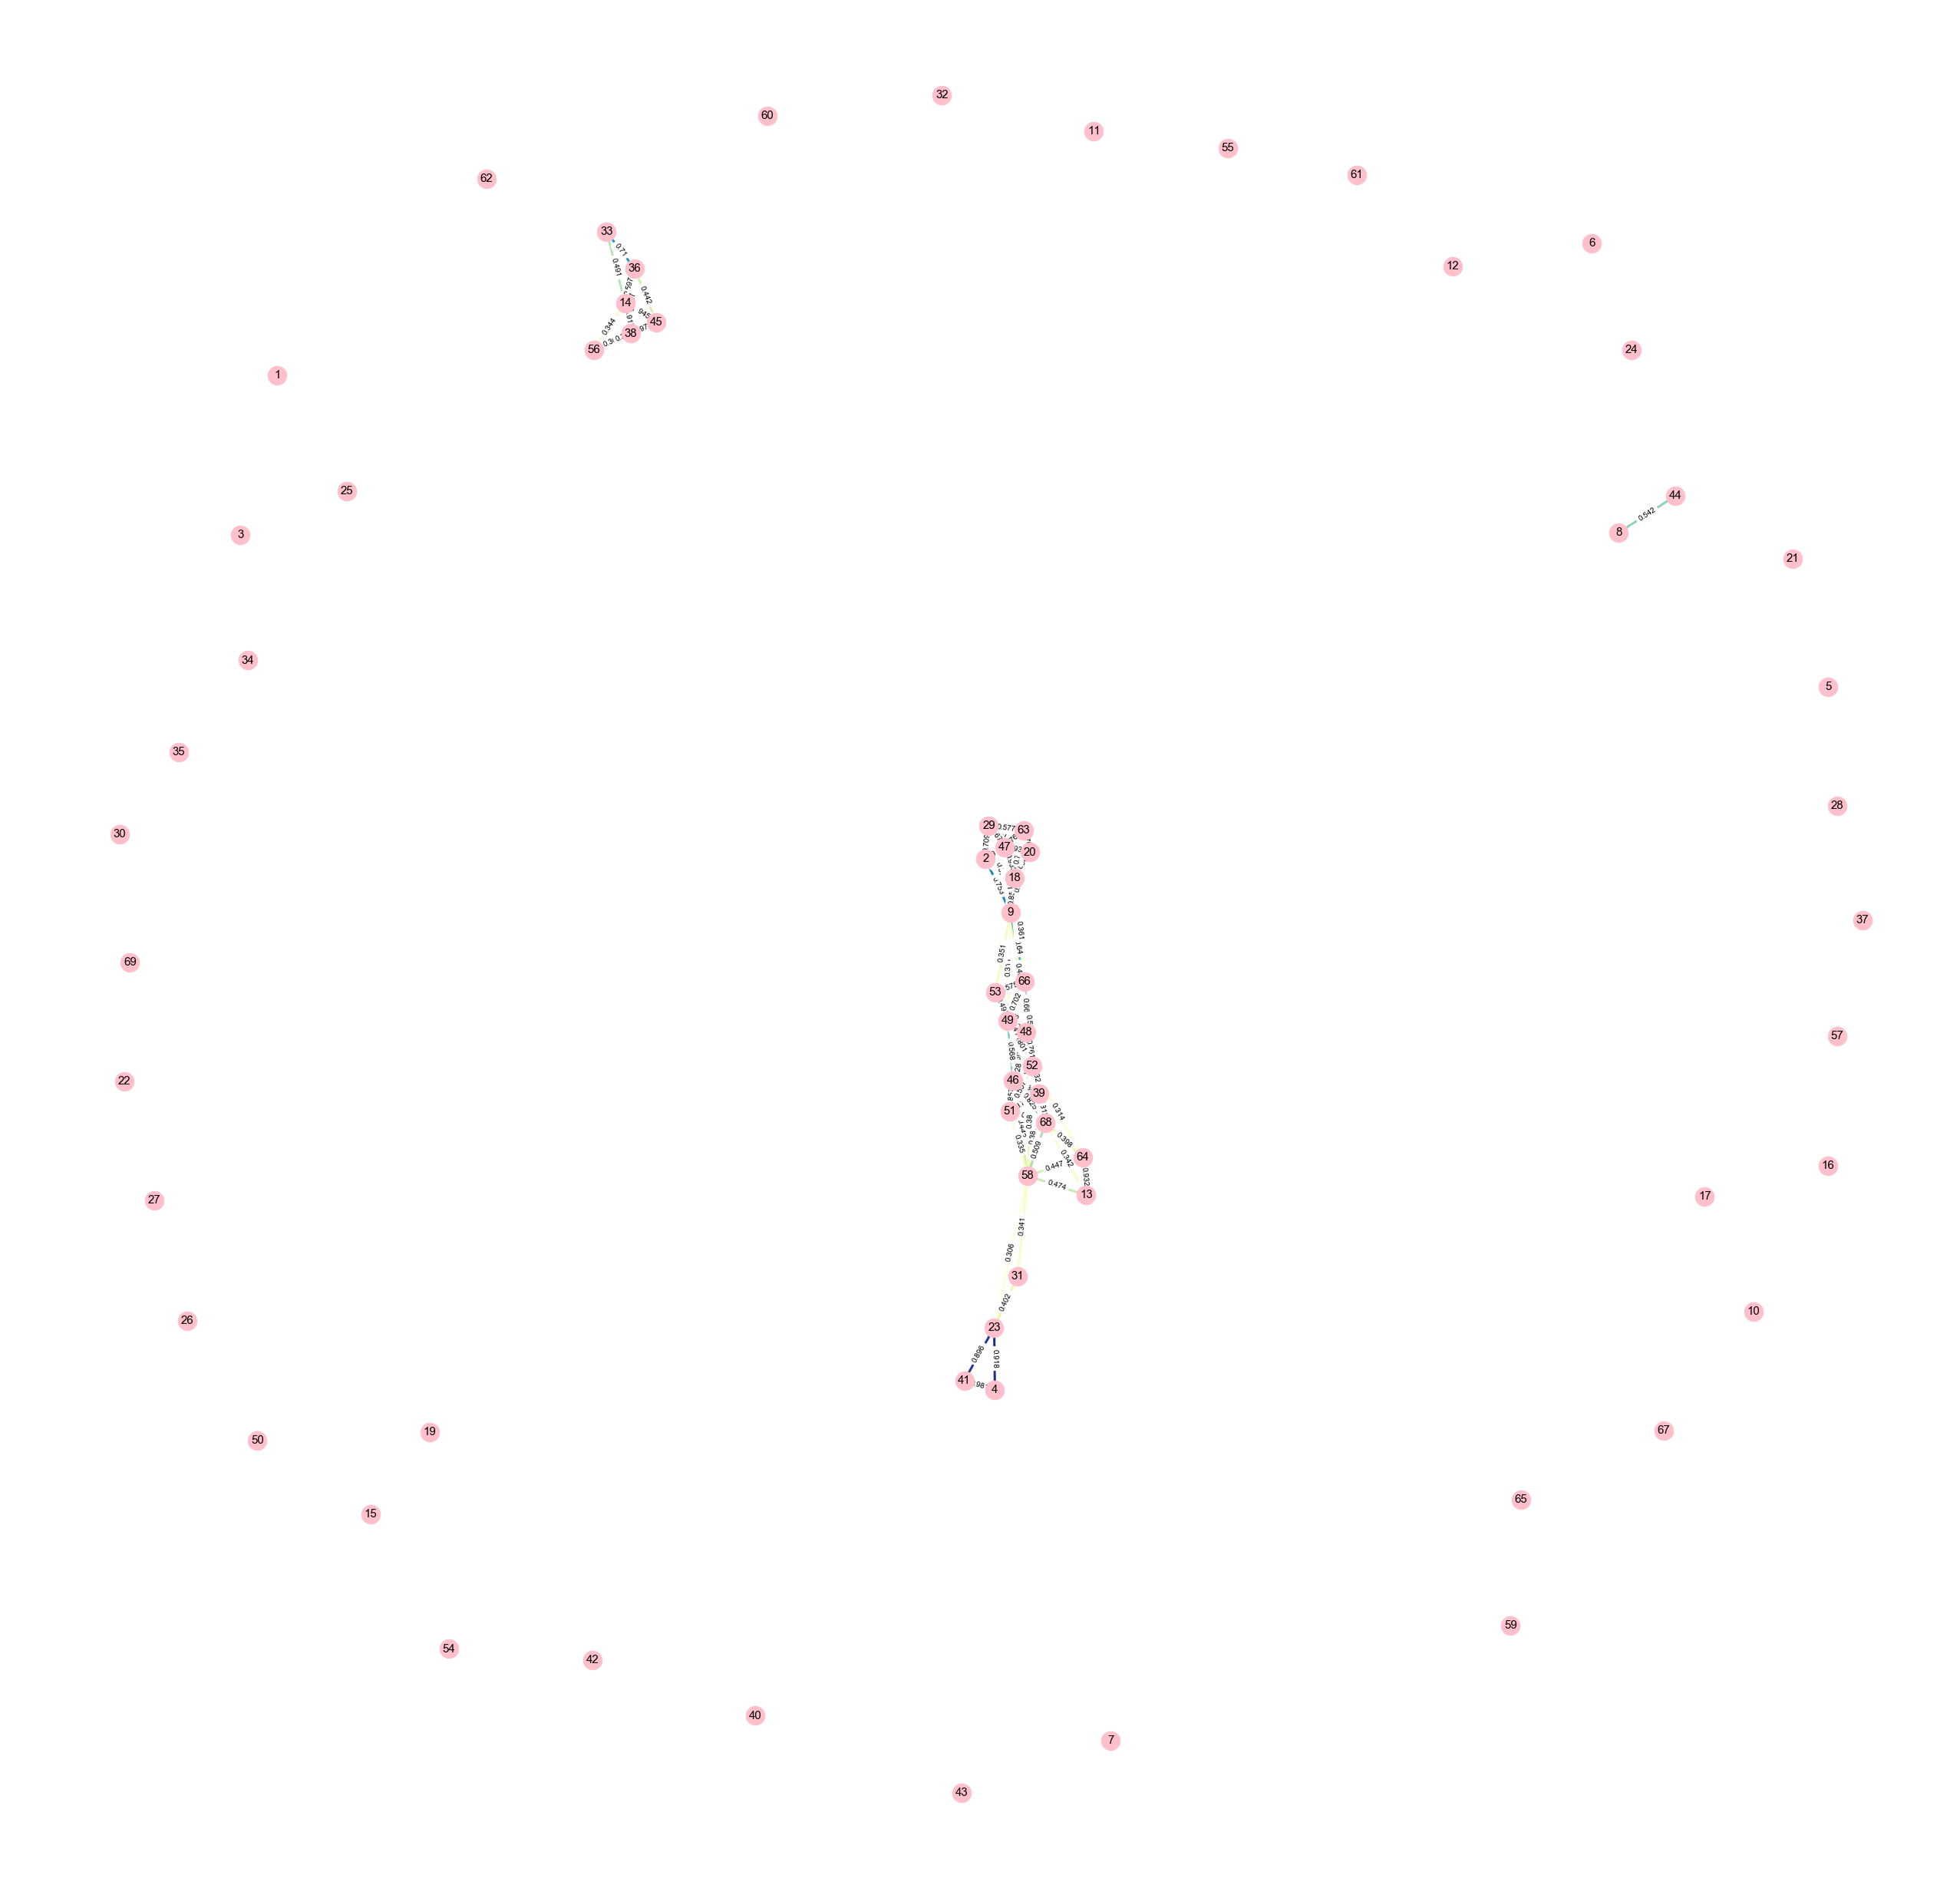

4624:5096
{1, 2, 5, 7, 10, 11, 13, 14, 22, 23, 26, 29, 30, 33, 34, 36, 37, 39, 42, 43, 46, 47, 48, 49, 53, 54, 55, 61, 68}


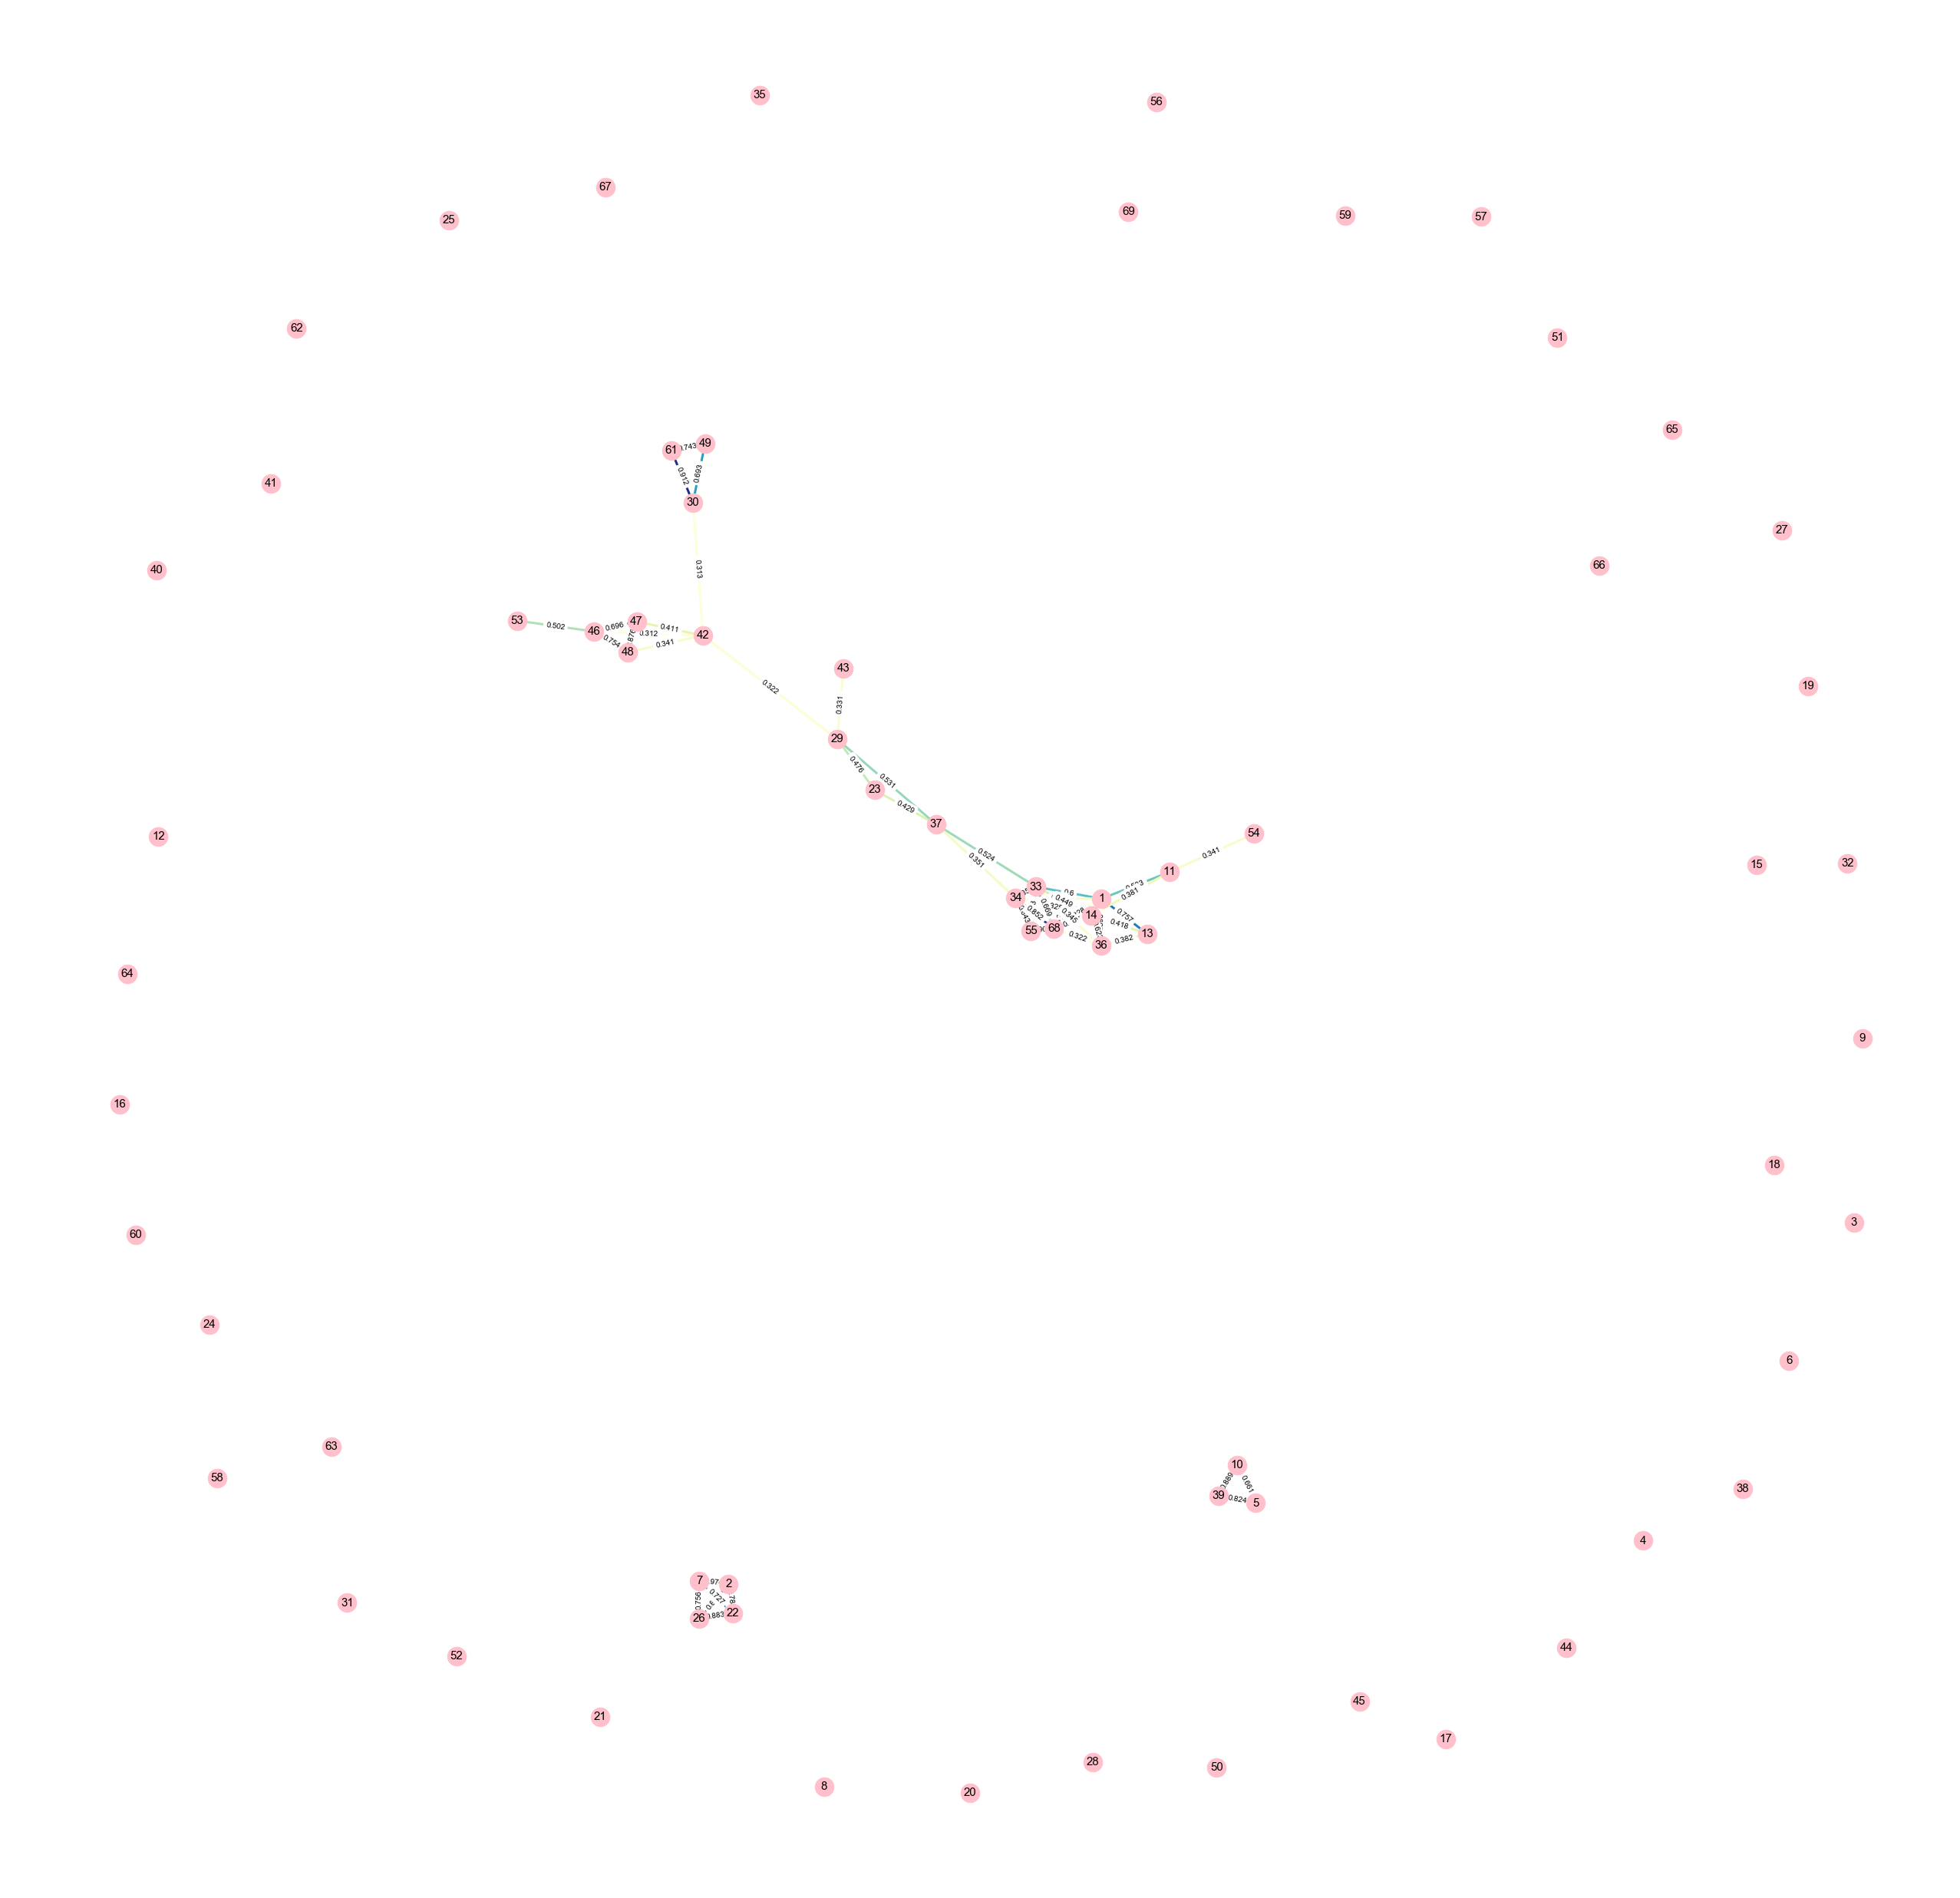

5199:5404
{2, 7, 8, 9, 14, 18, 20, 26, 27, 28, 29, 33, 36, 38, 39, 41, 43, 44, 45, 46, 50, 56, 57, 58, 61, 63}


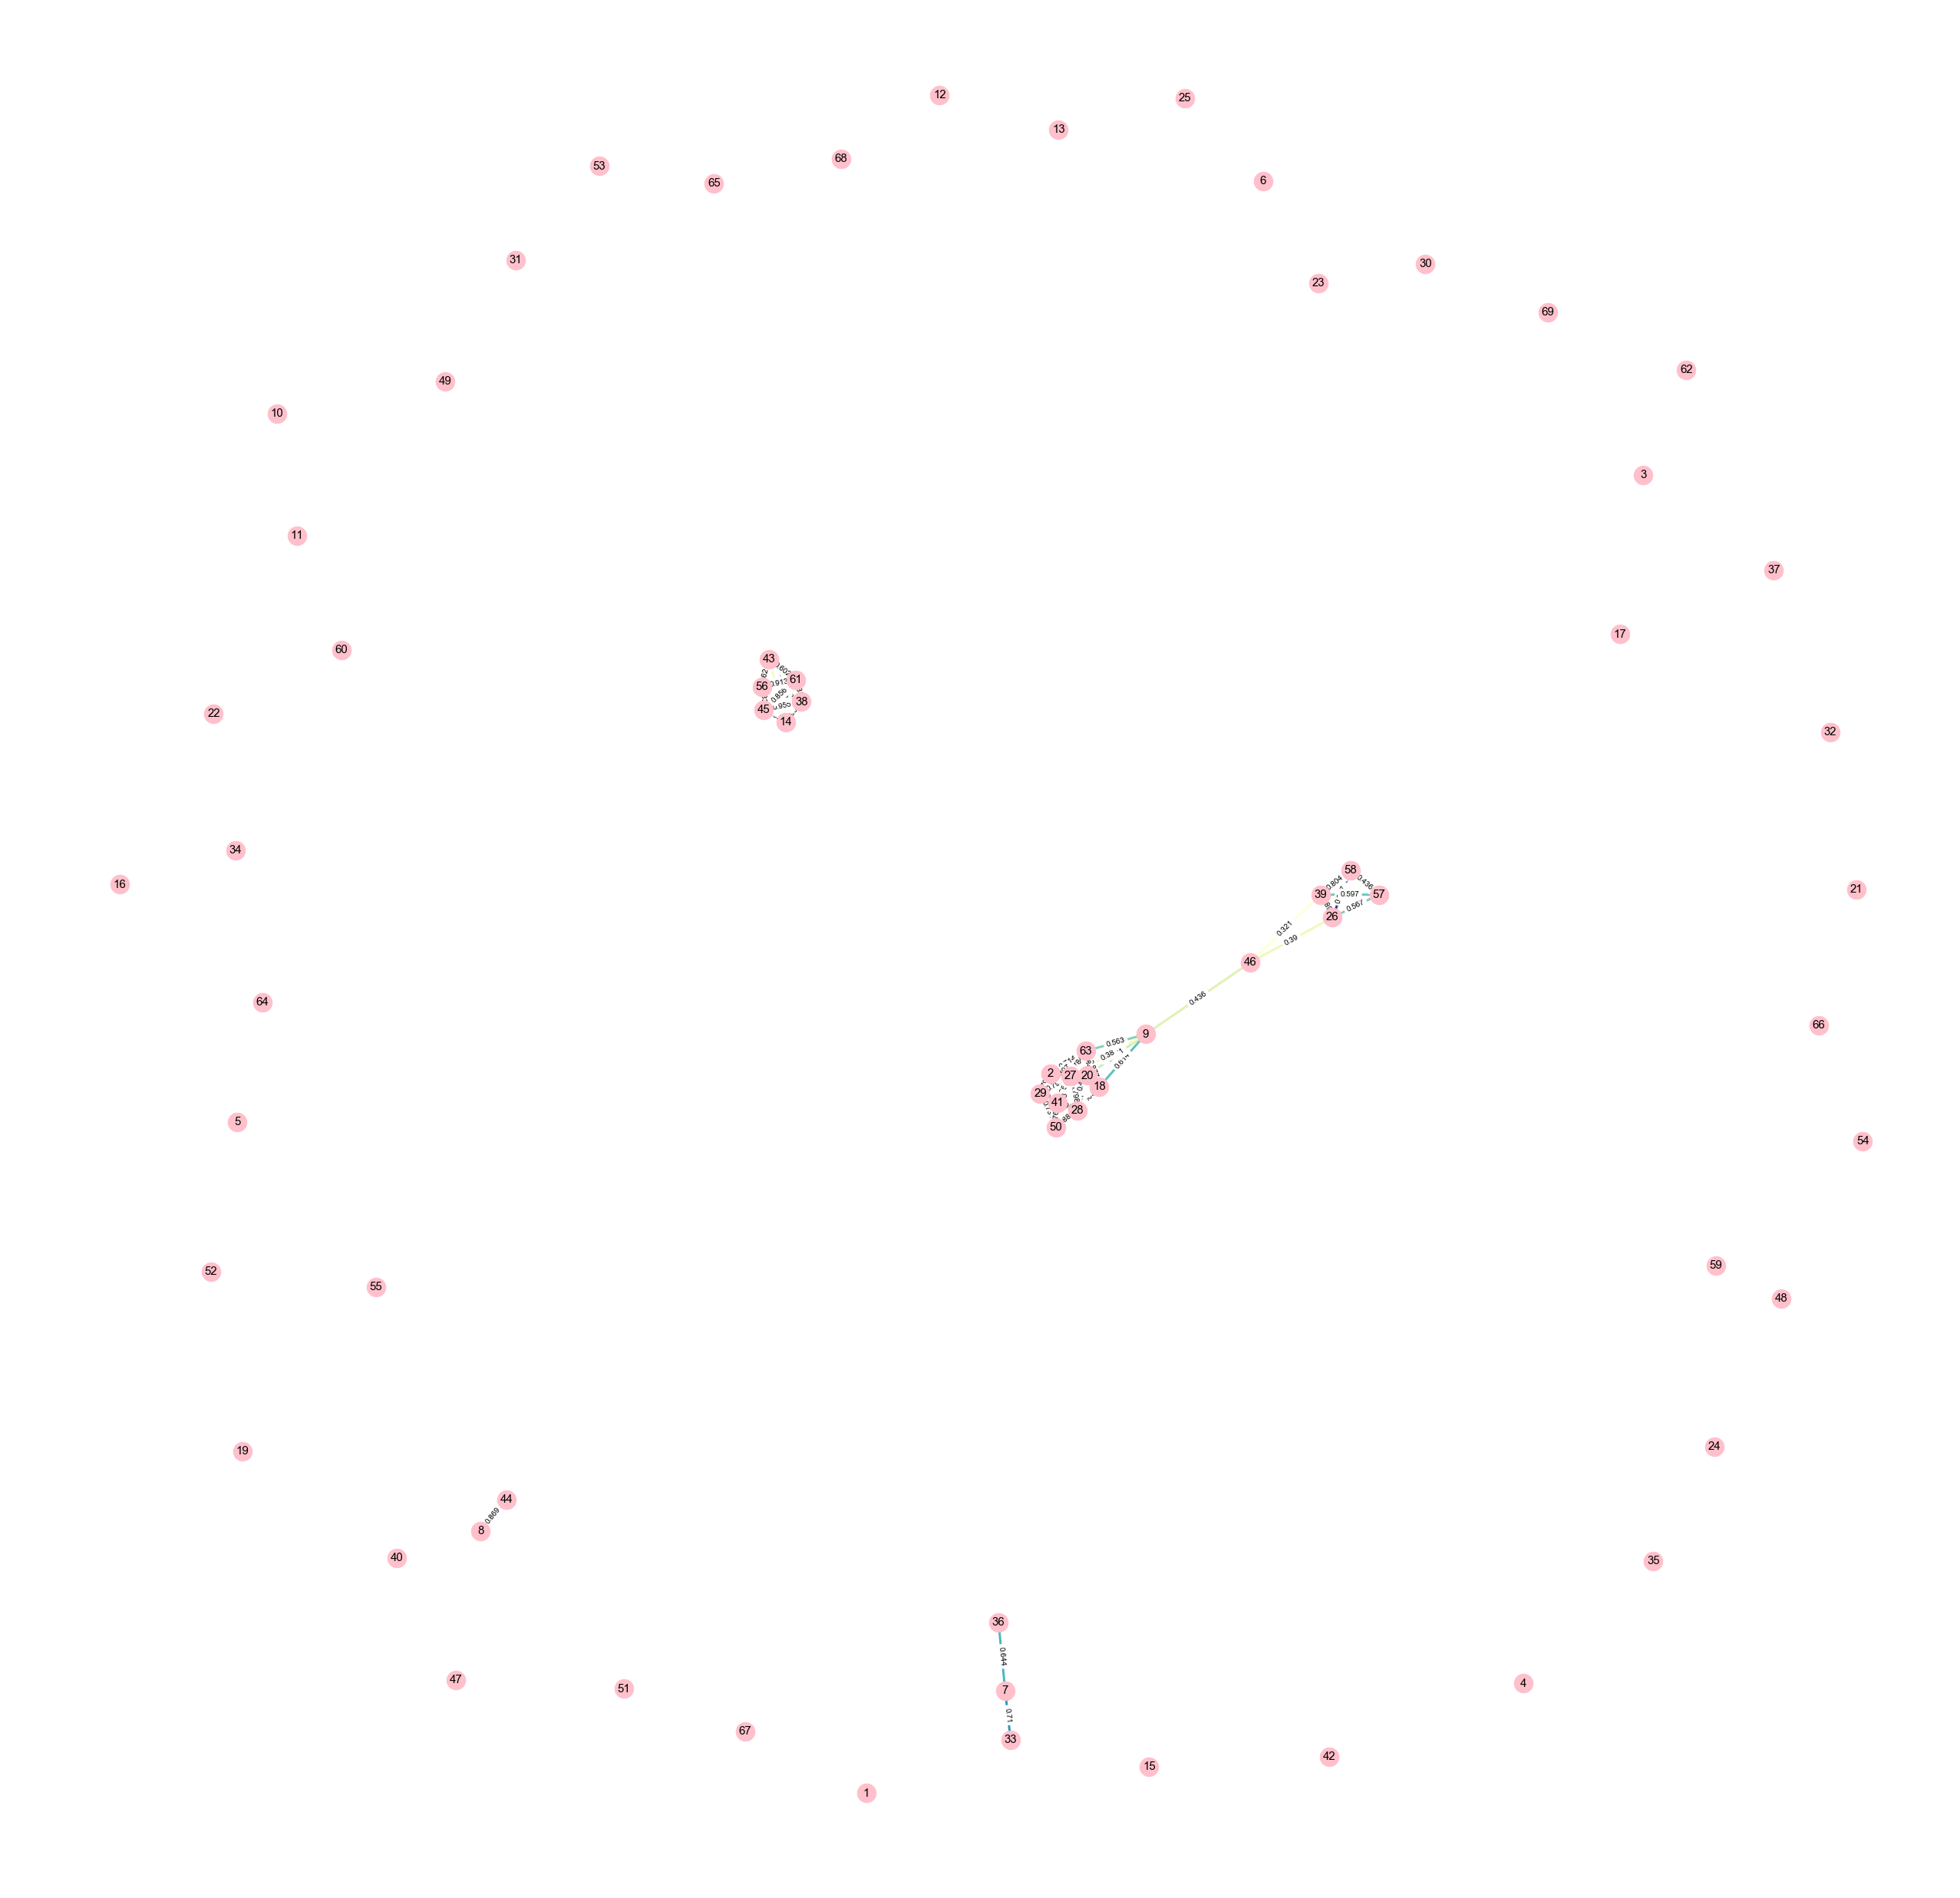

5547:5727
{64, 67, 68, 5, 8, 9, 11, 47, 48, 18, 50, 57, 27}


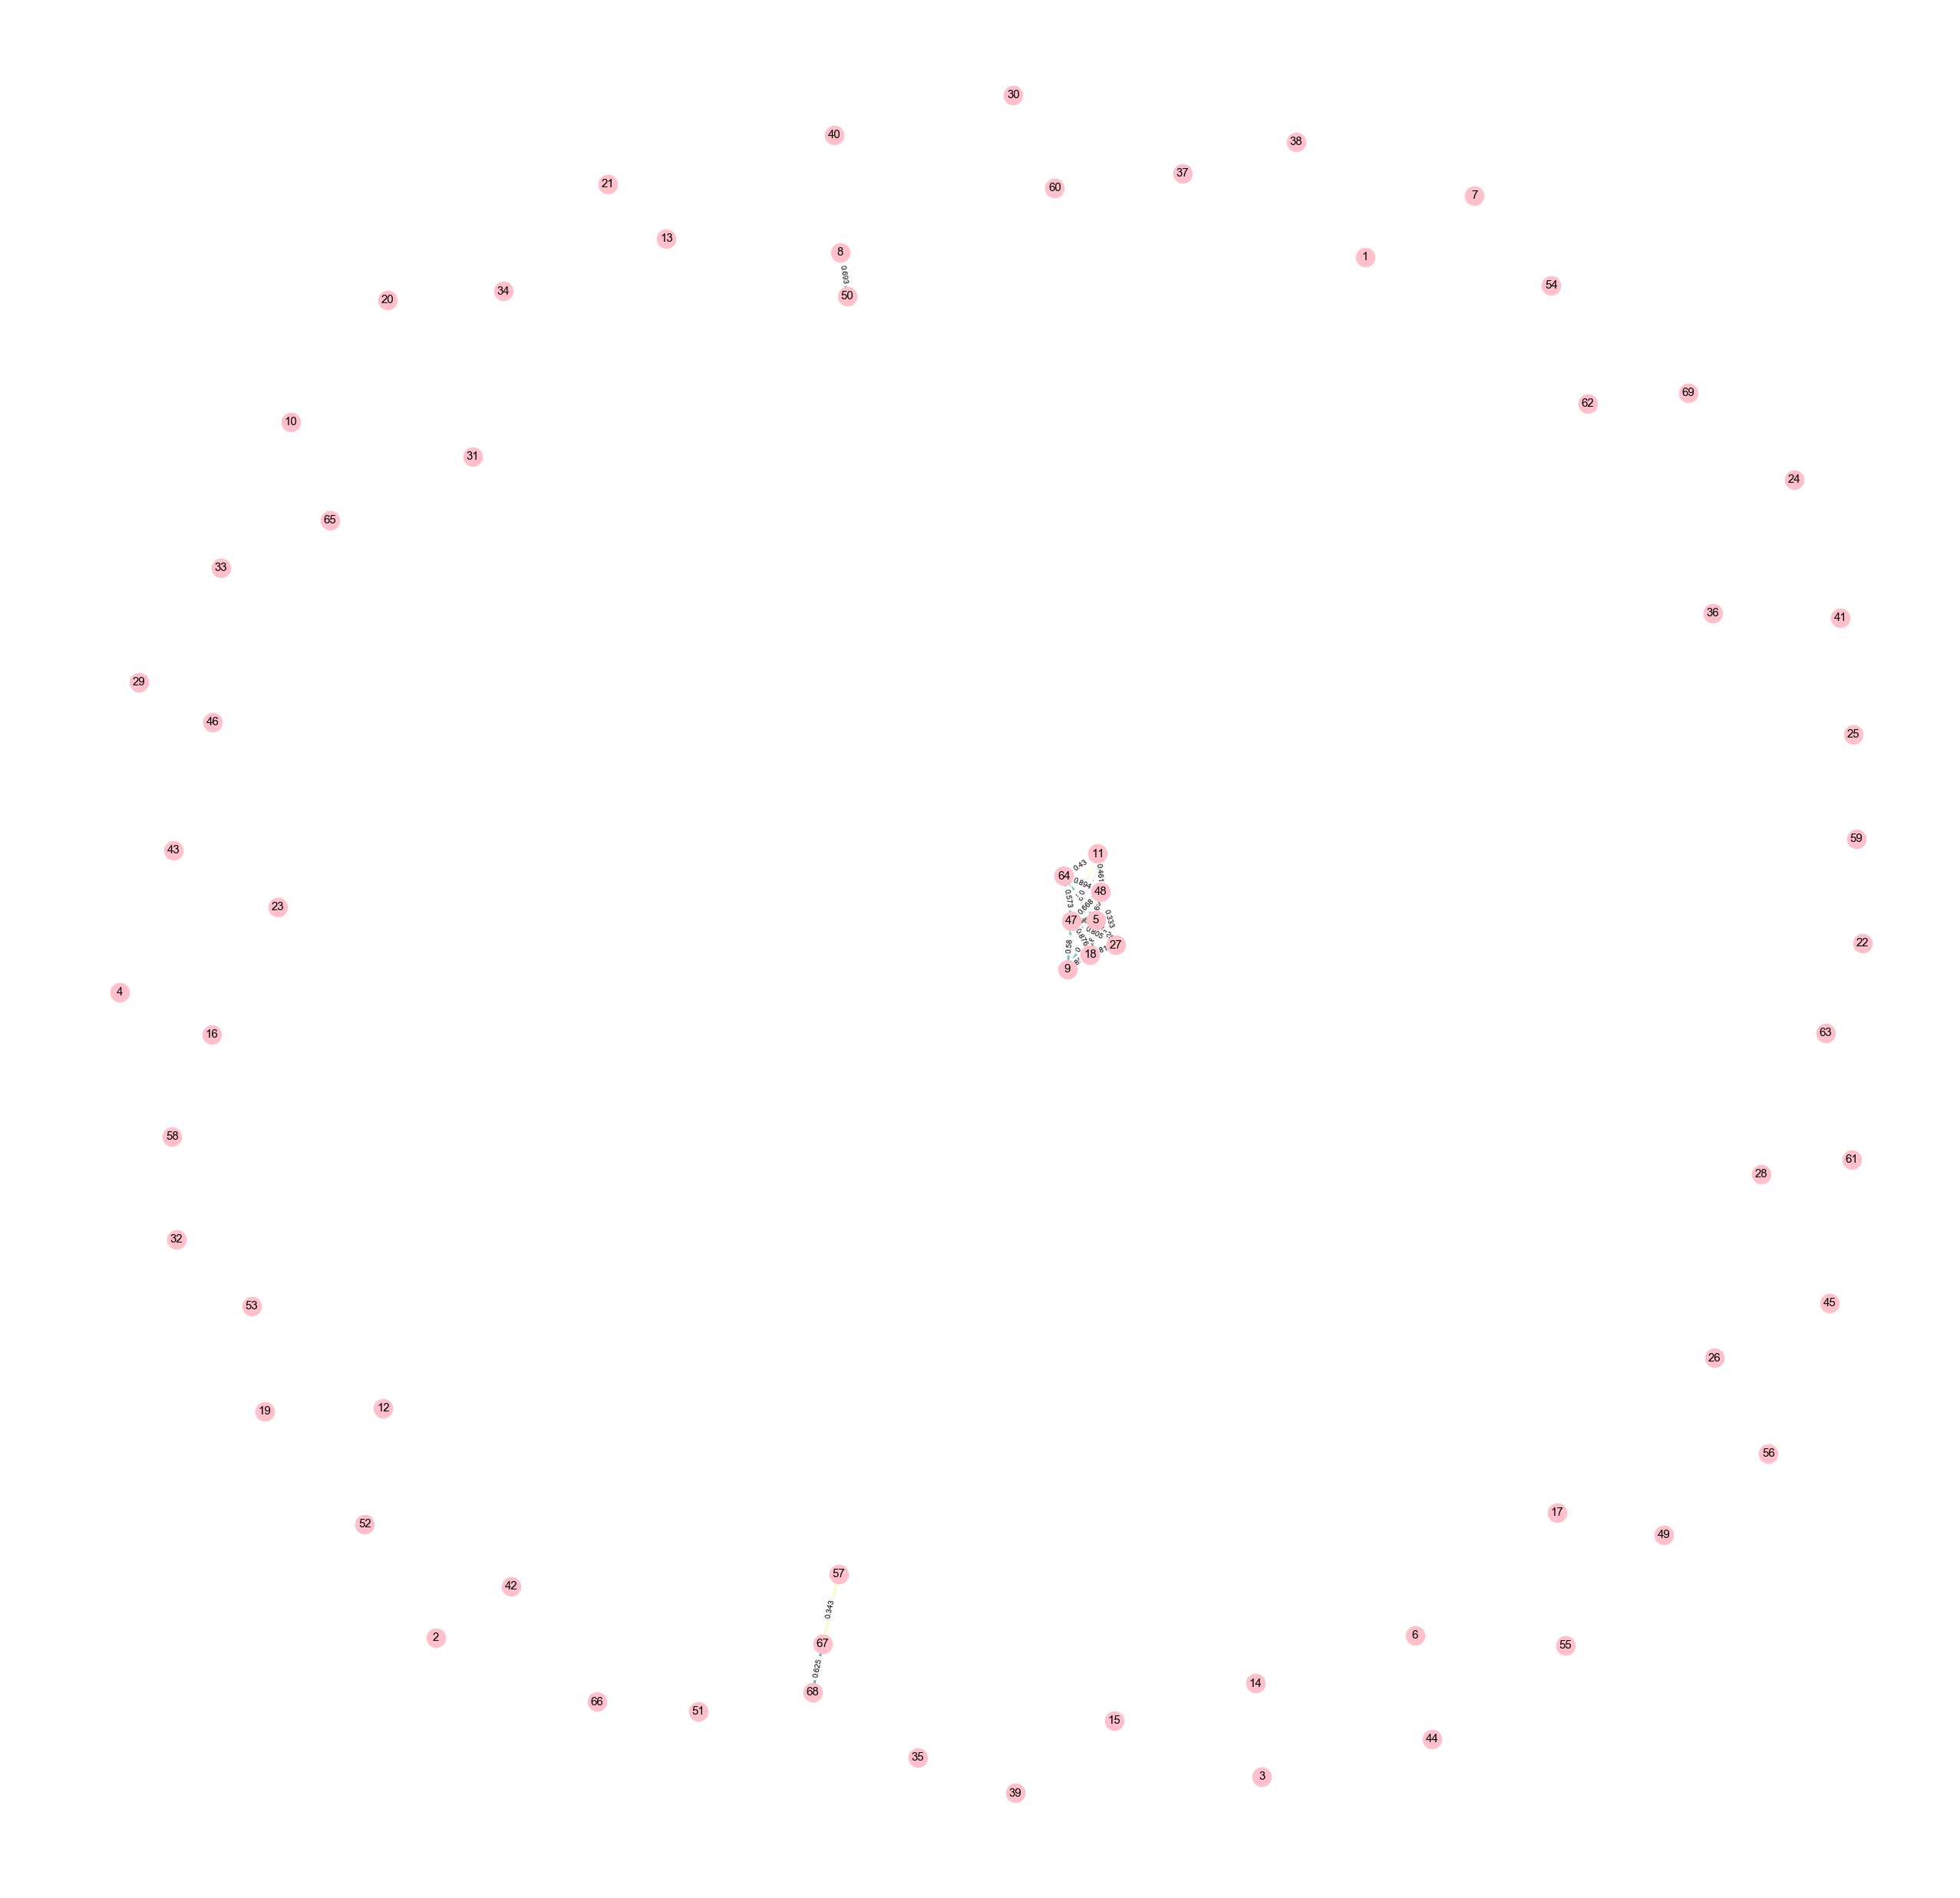

5749:5881
{38, 45, 14, 56, 61}


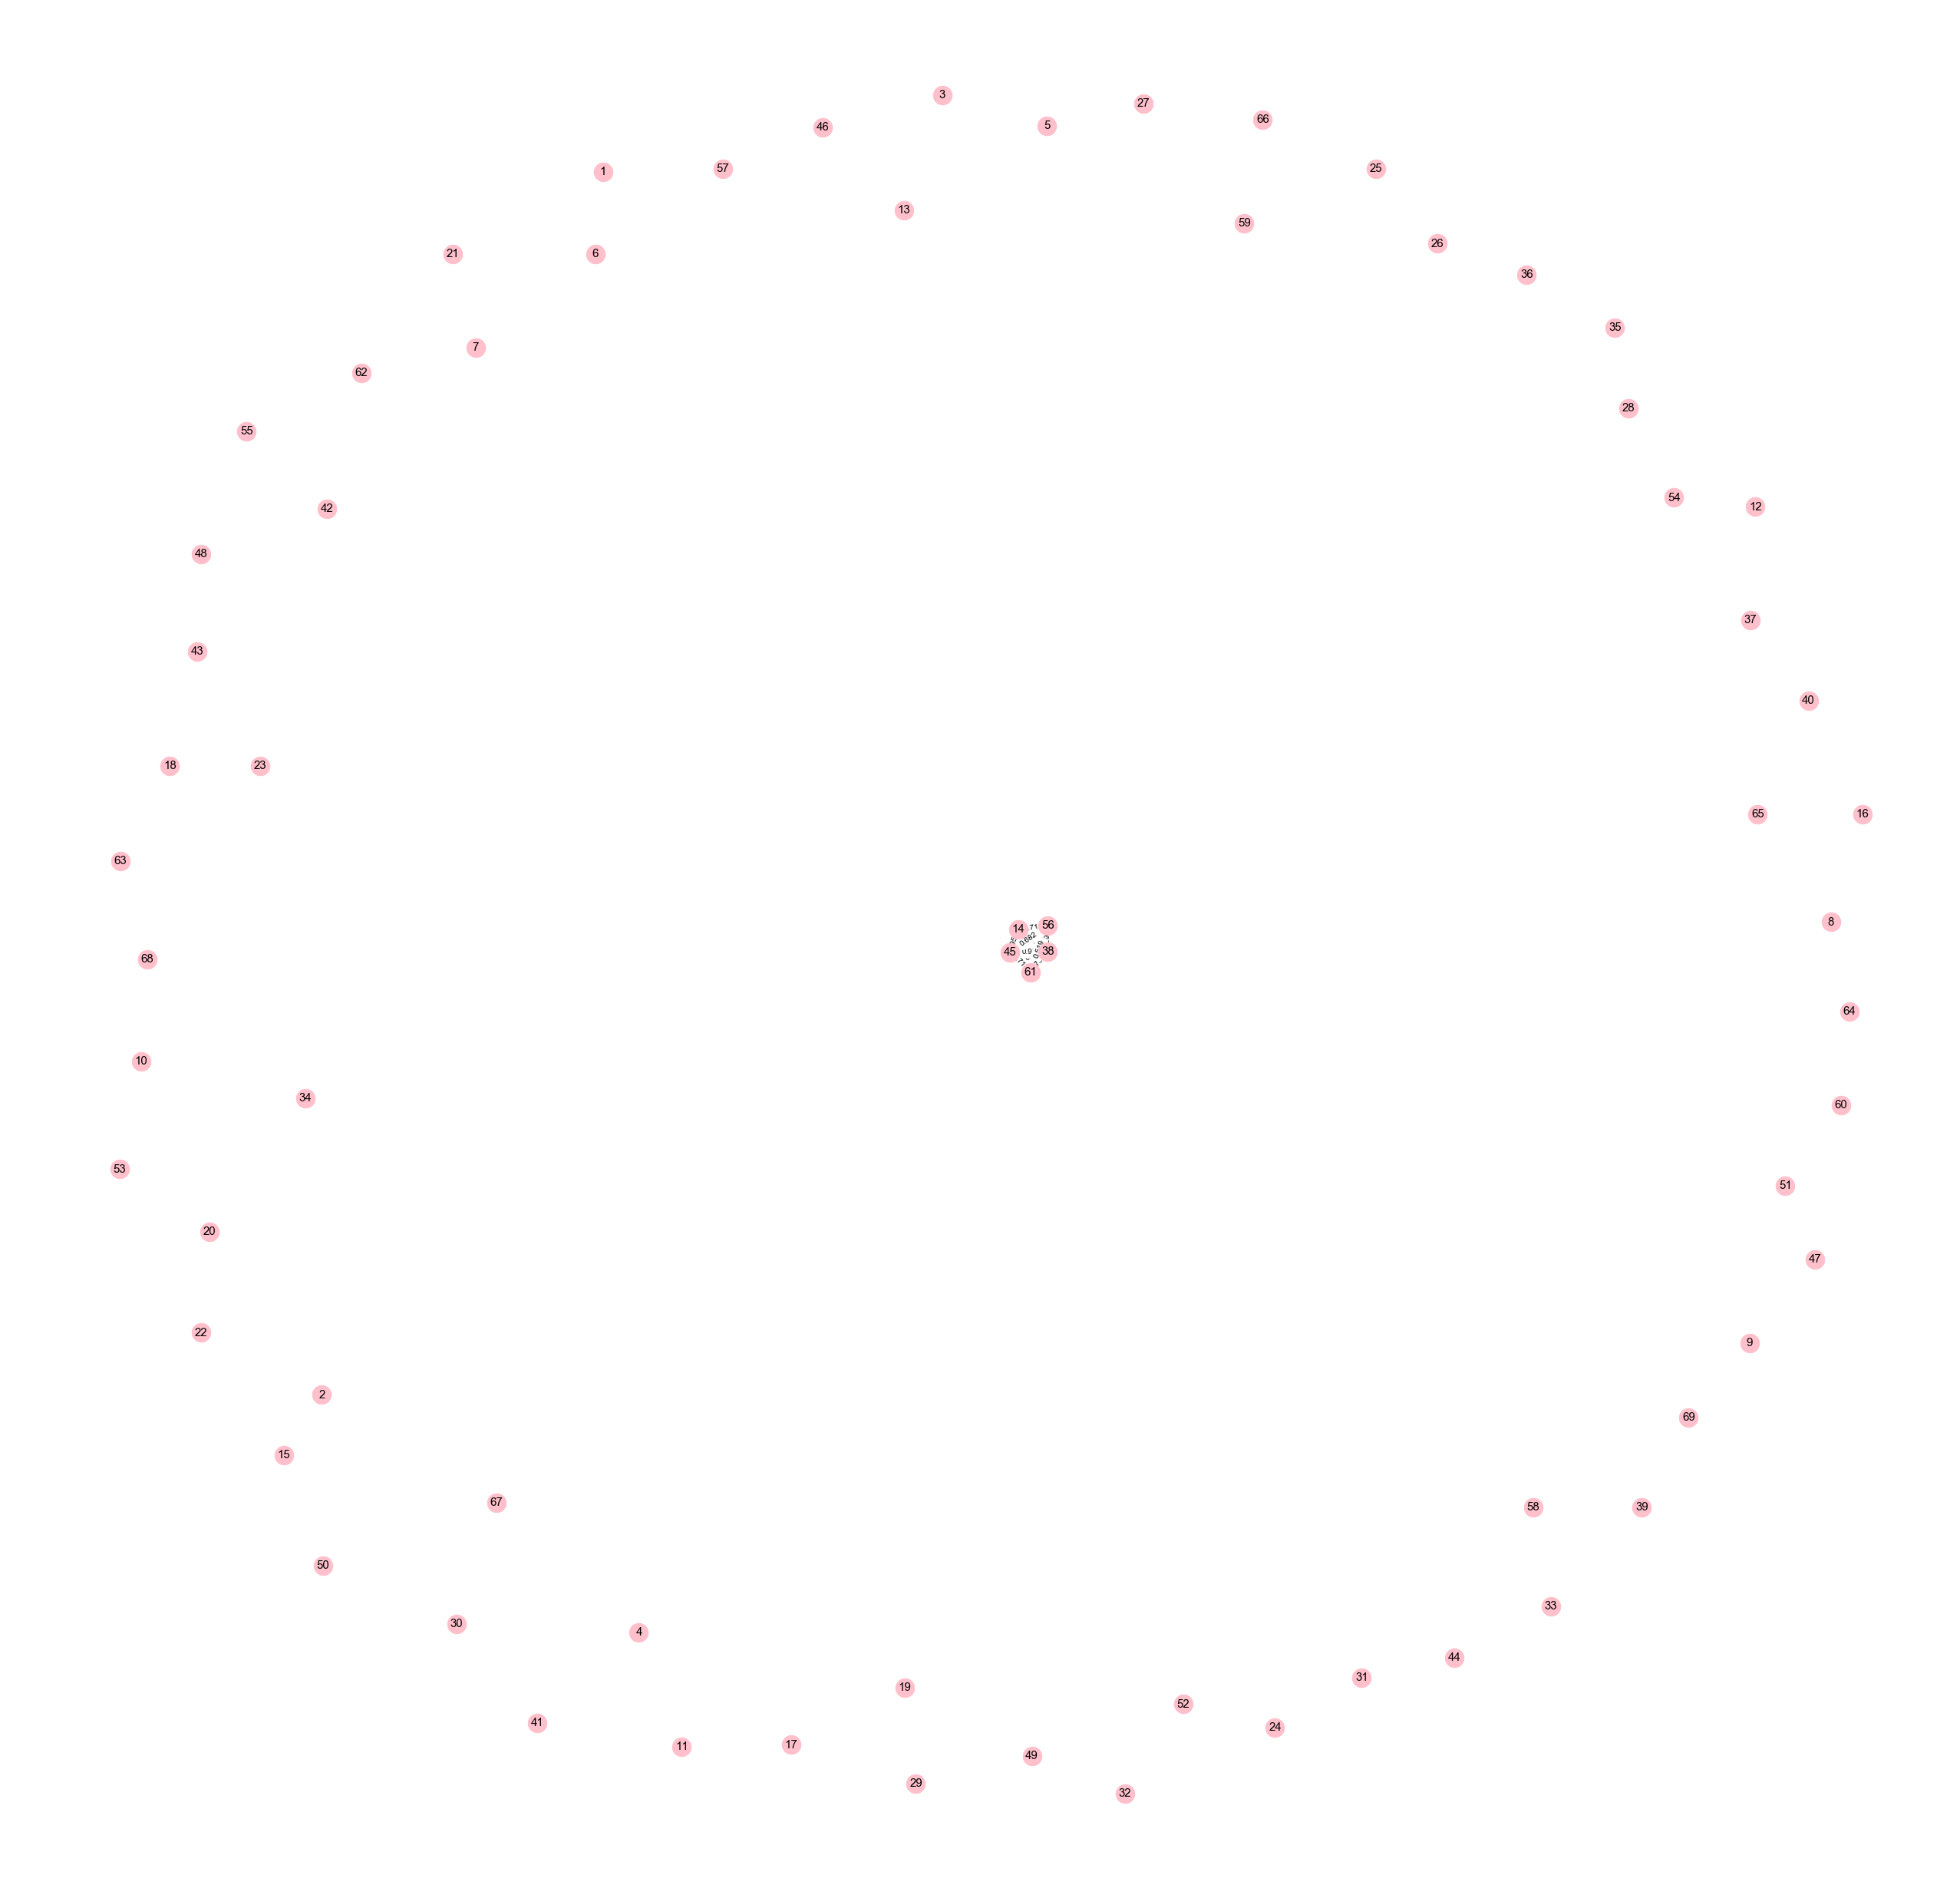

5883:5984
{7, 8, 10, 11, 42, 45, 46, 51, 61, 30, 63}


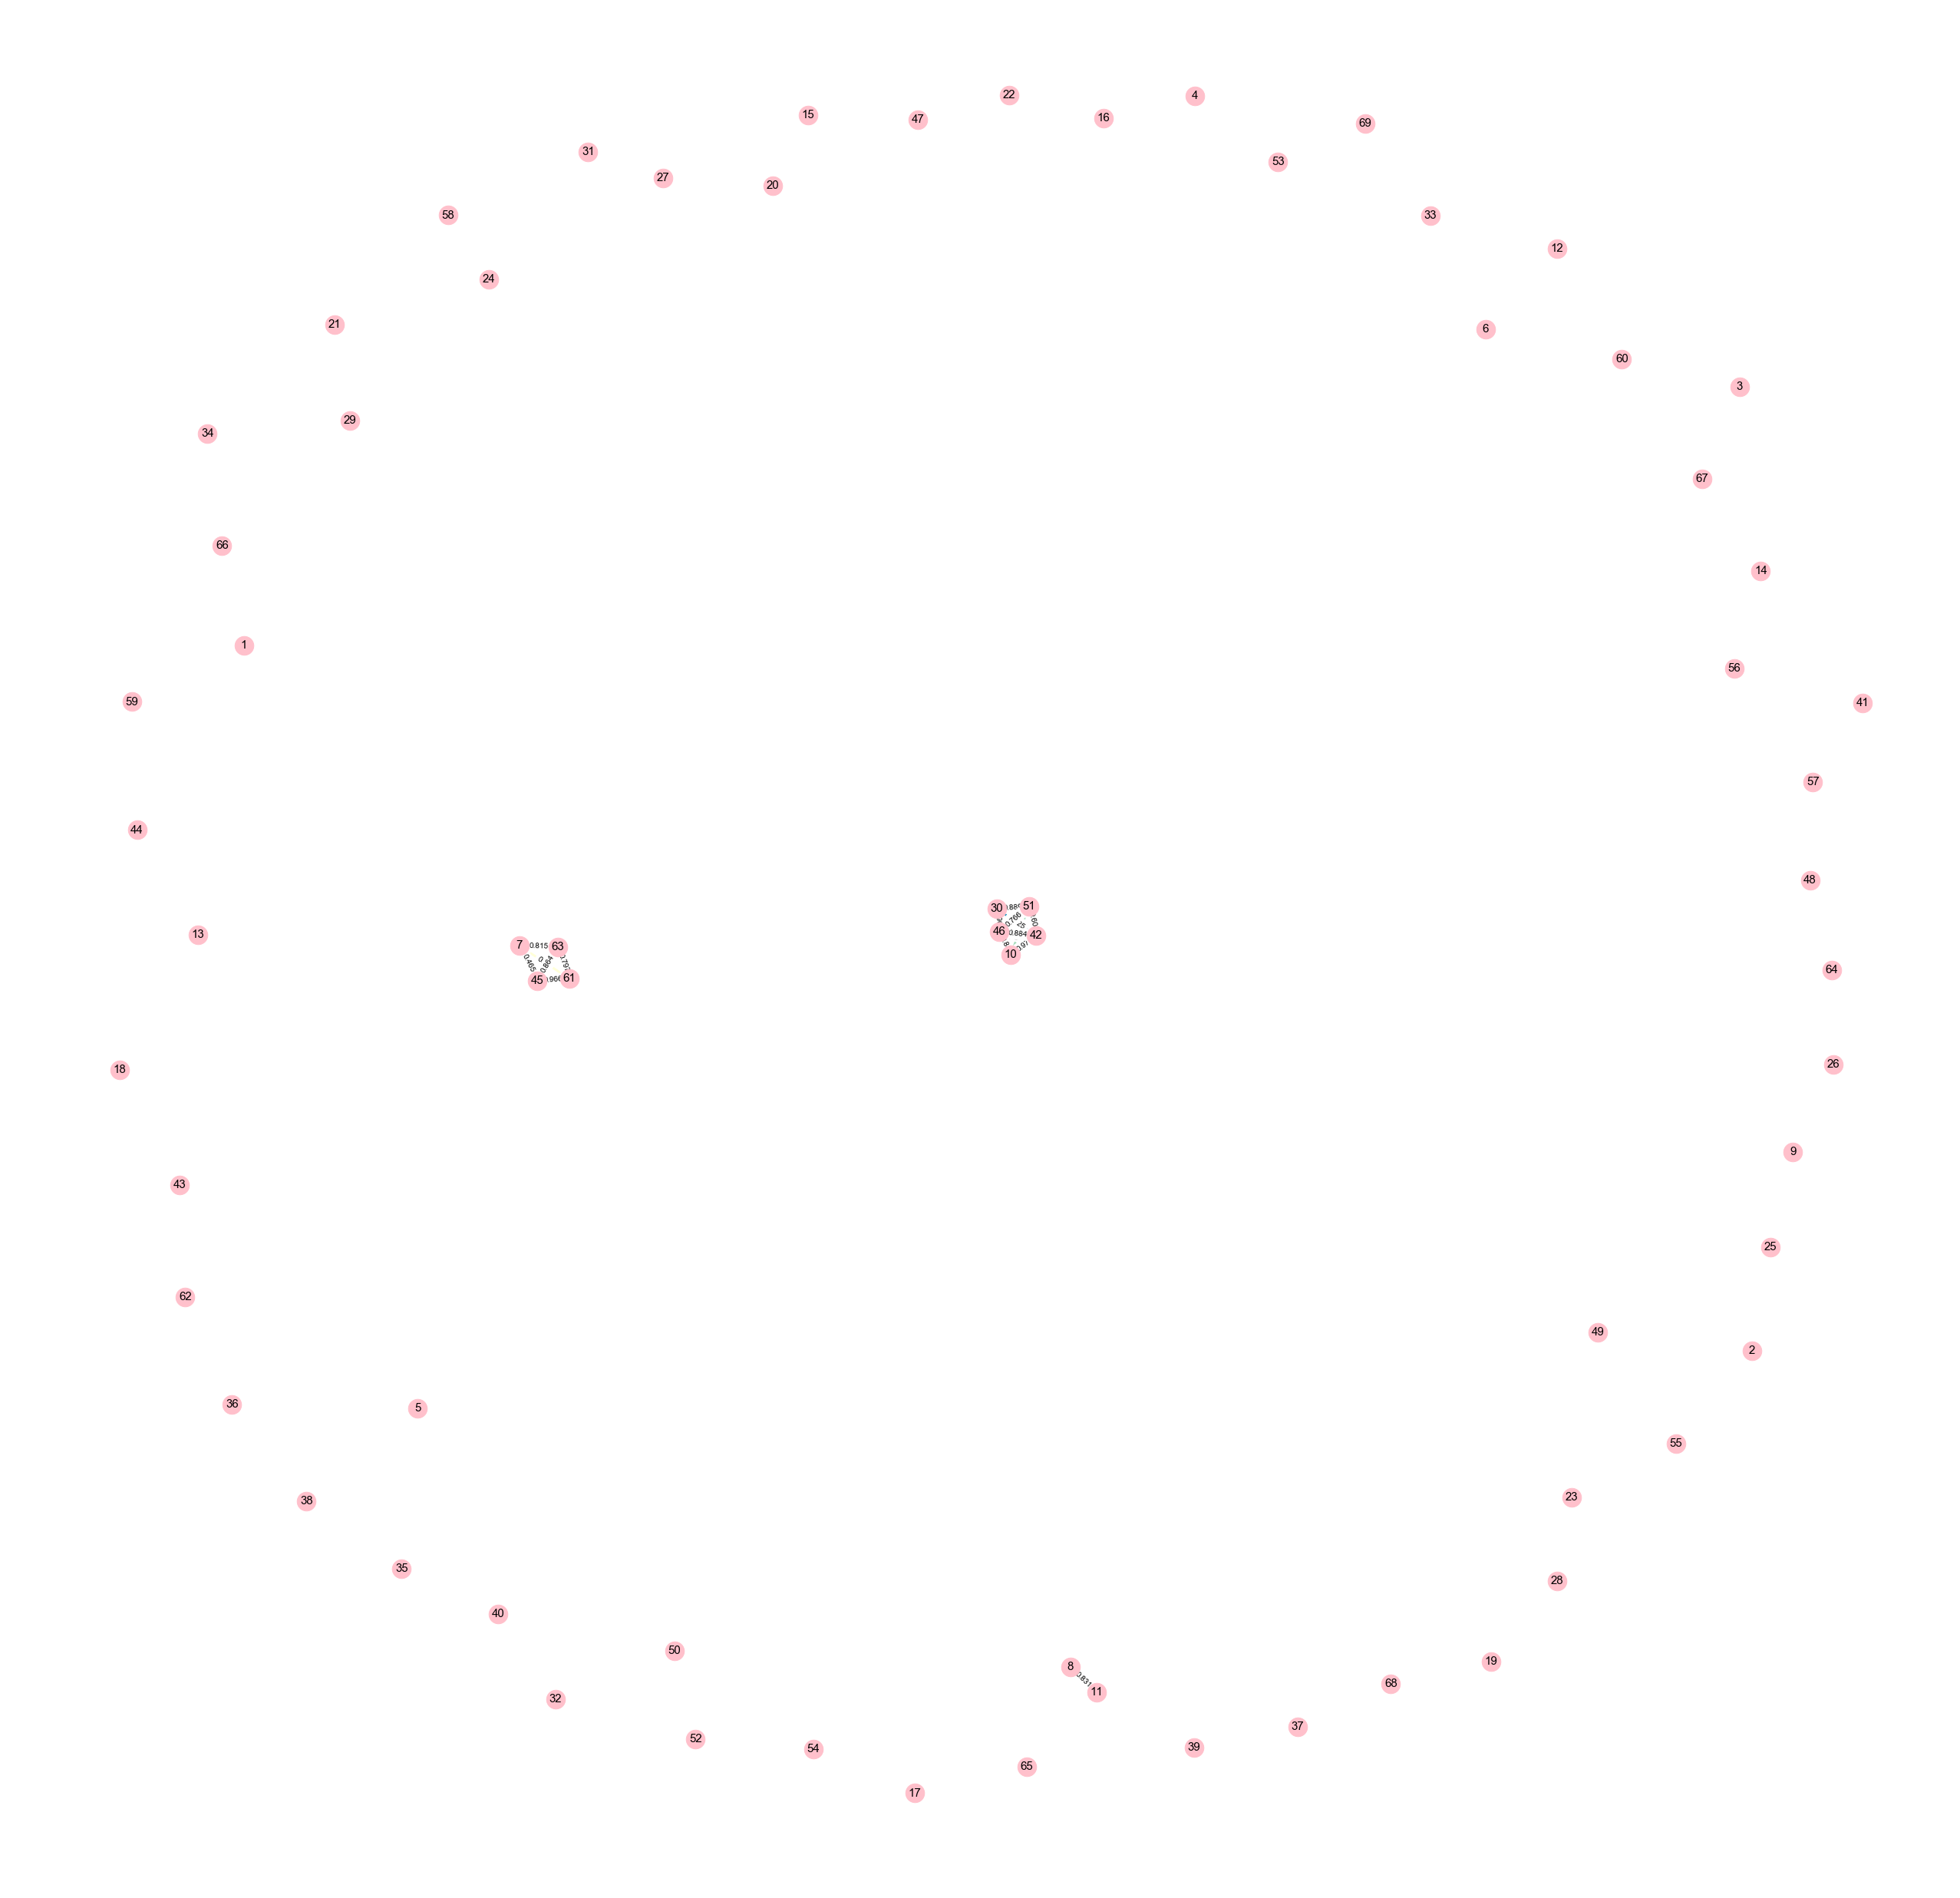

6003:6092
{34, 3, 36, 69, 38, 11, 43, 45, 47, 50, 63}


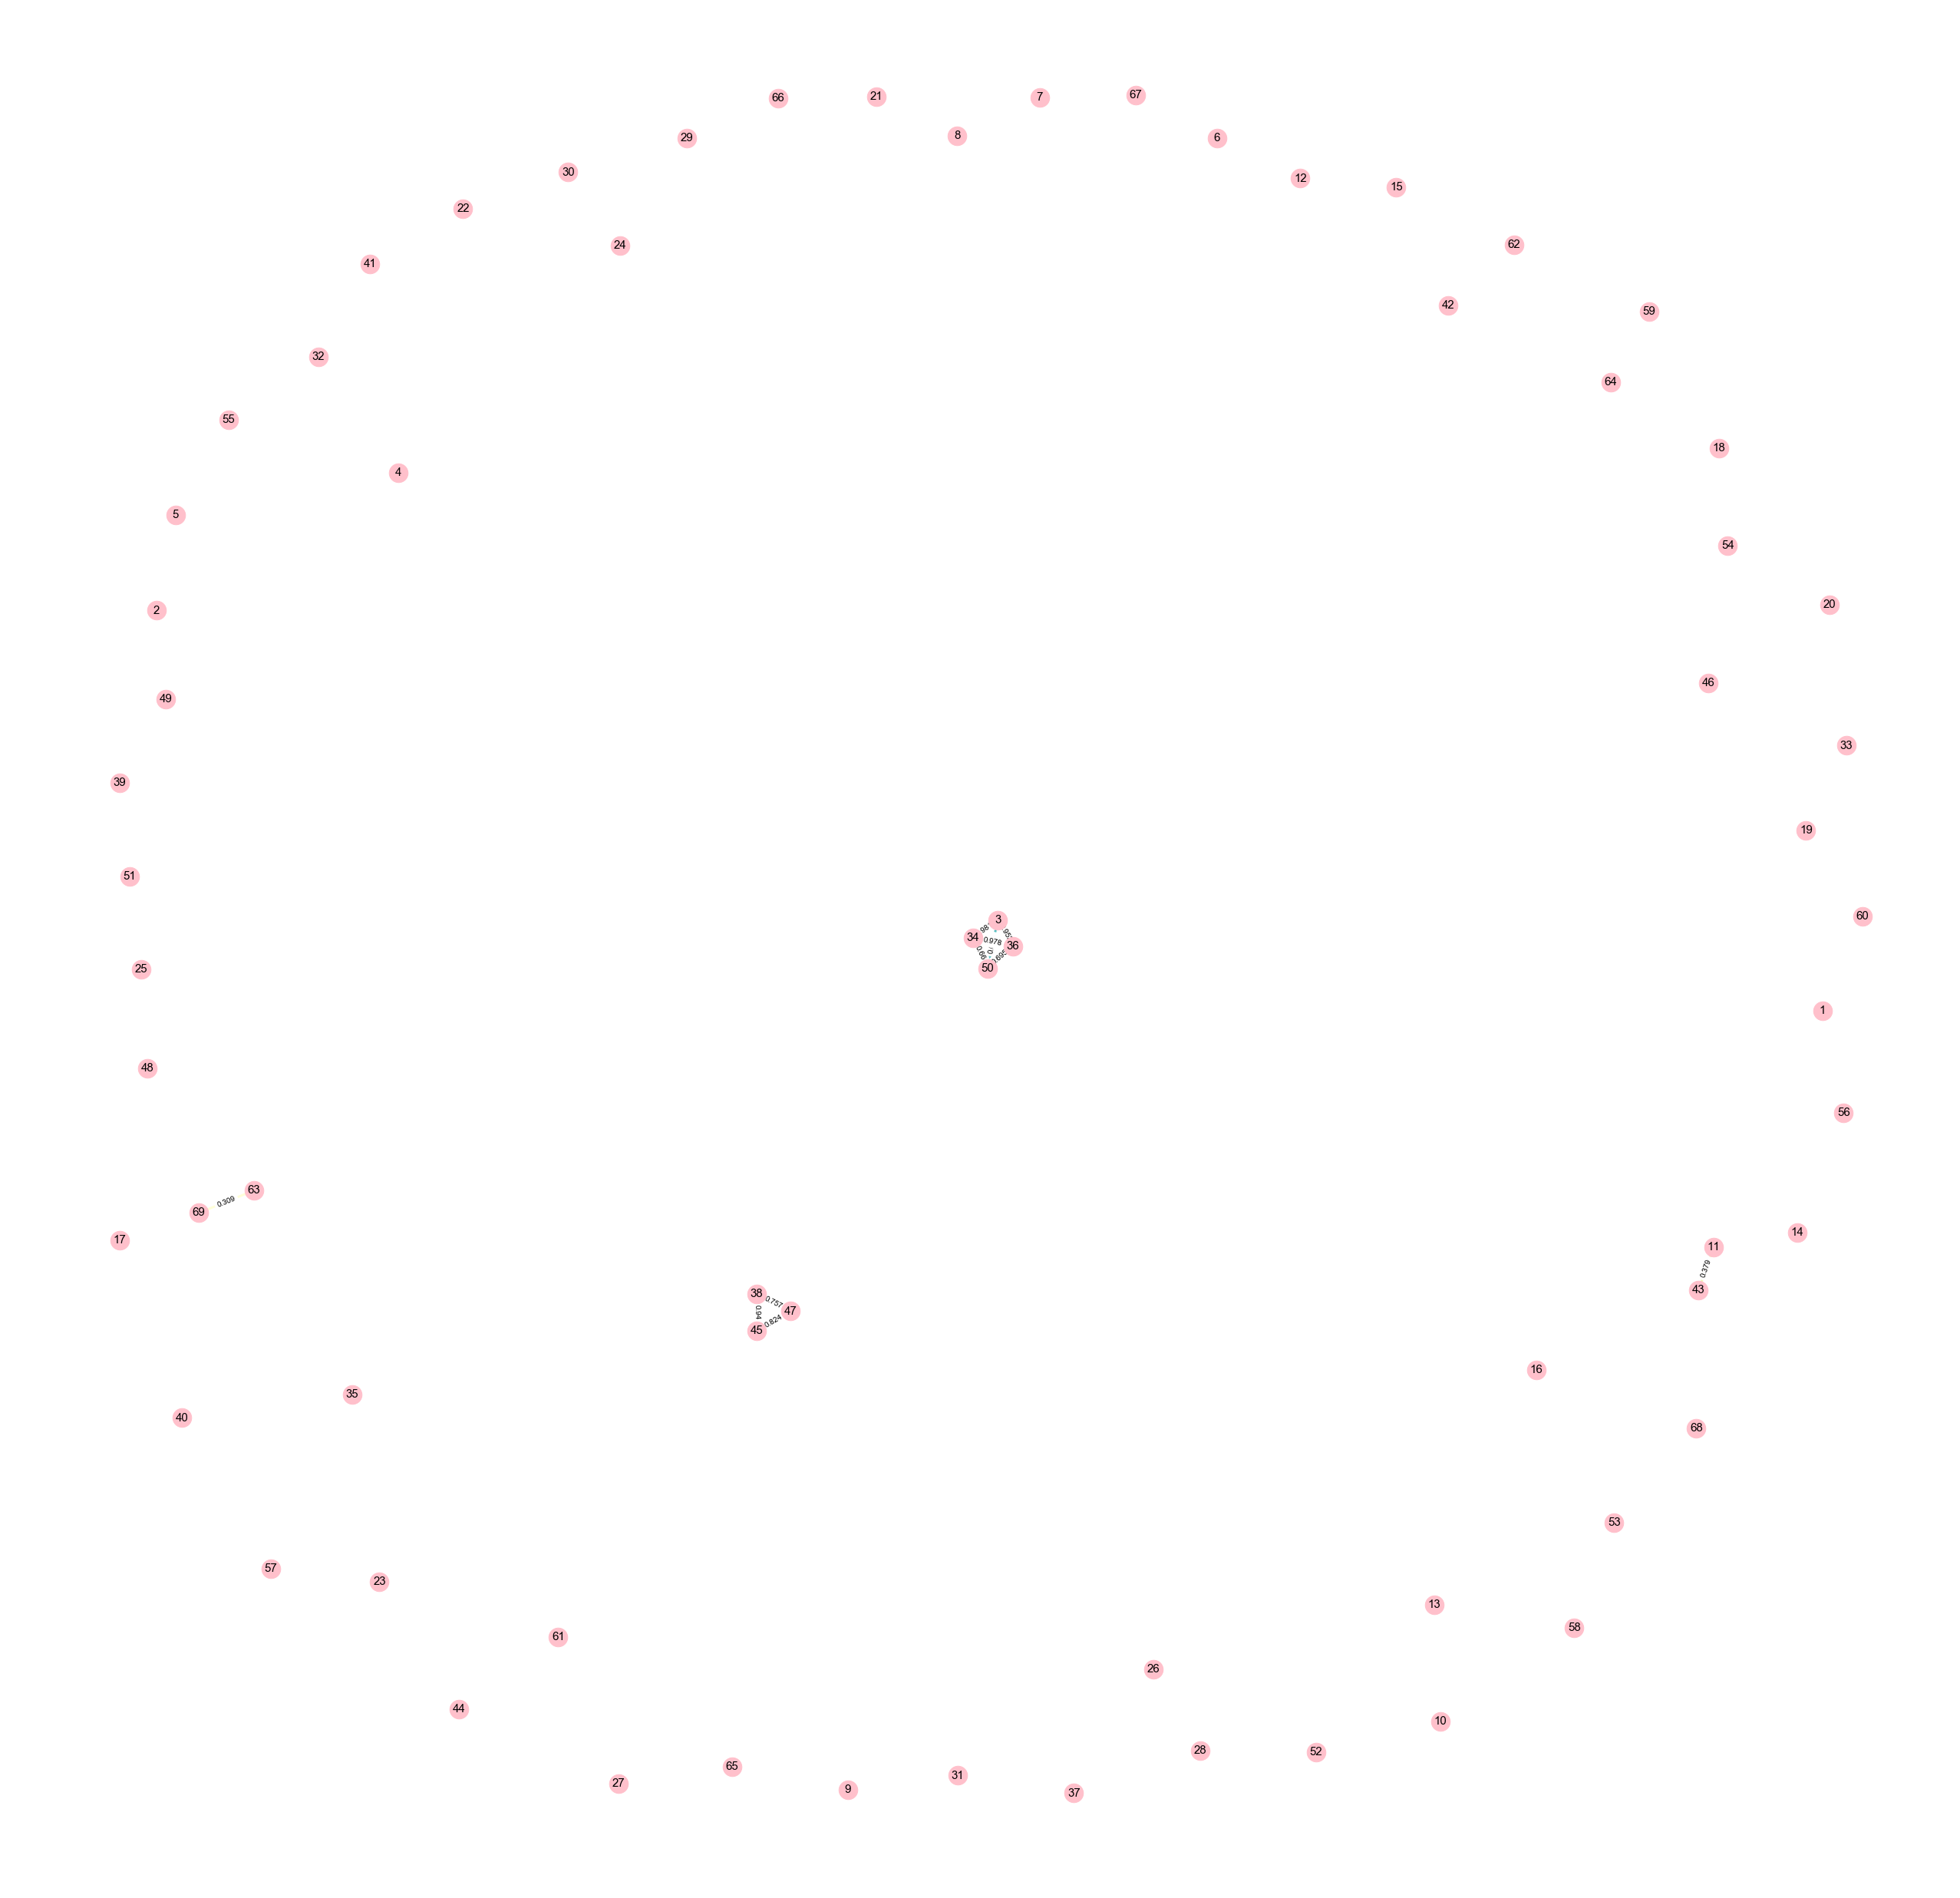

6228:6521
{1, 5, 6, 11, 12, 13, 14, 22, 23, 24, 26, 29, 30, 32, 33, 35, 36, 37, 40, 42, 43, 44, 46, 47, 48, 49, 50, 53, 54, 61, 63, 66, 67, 68, 69}


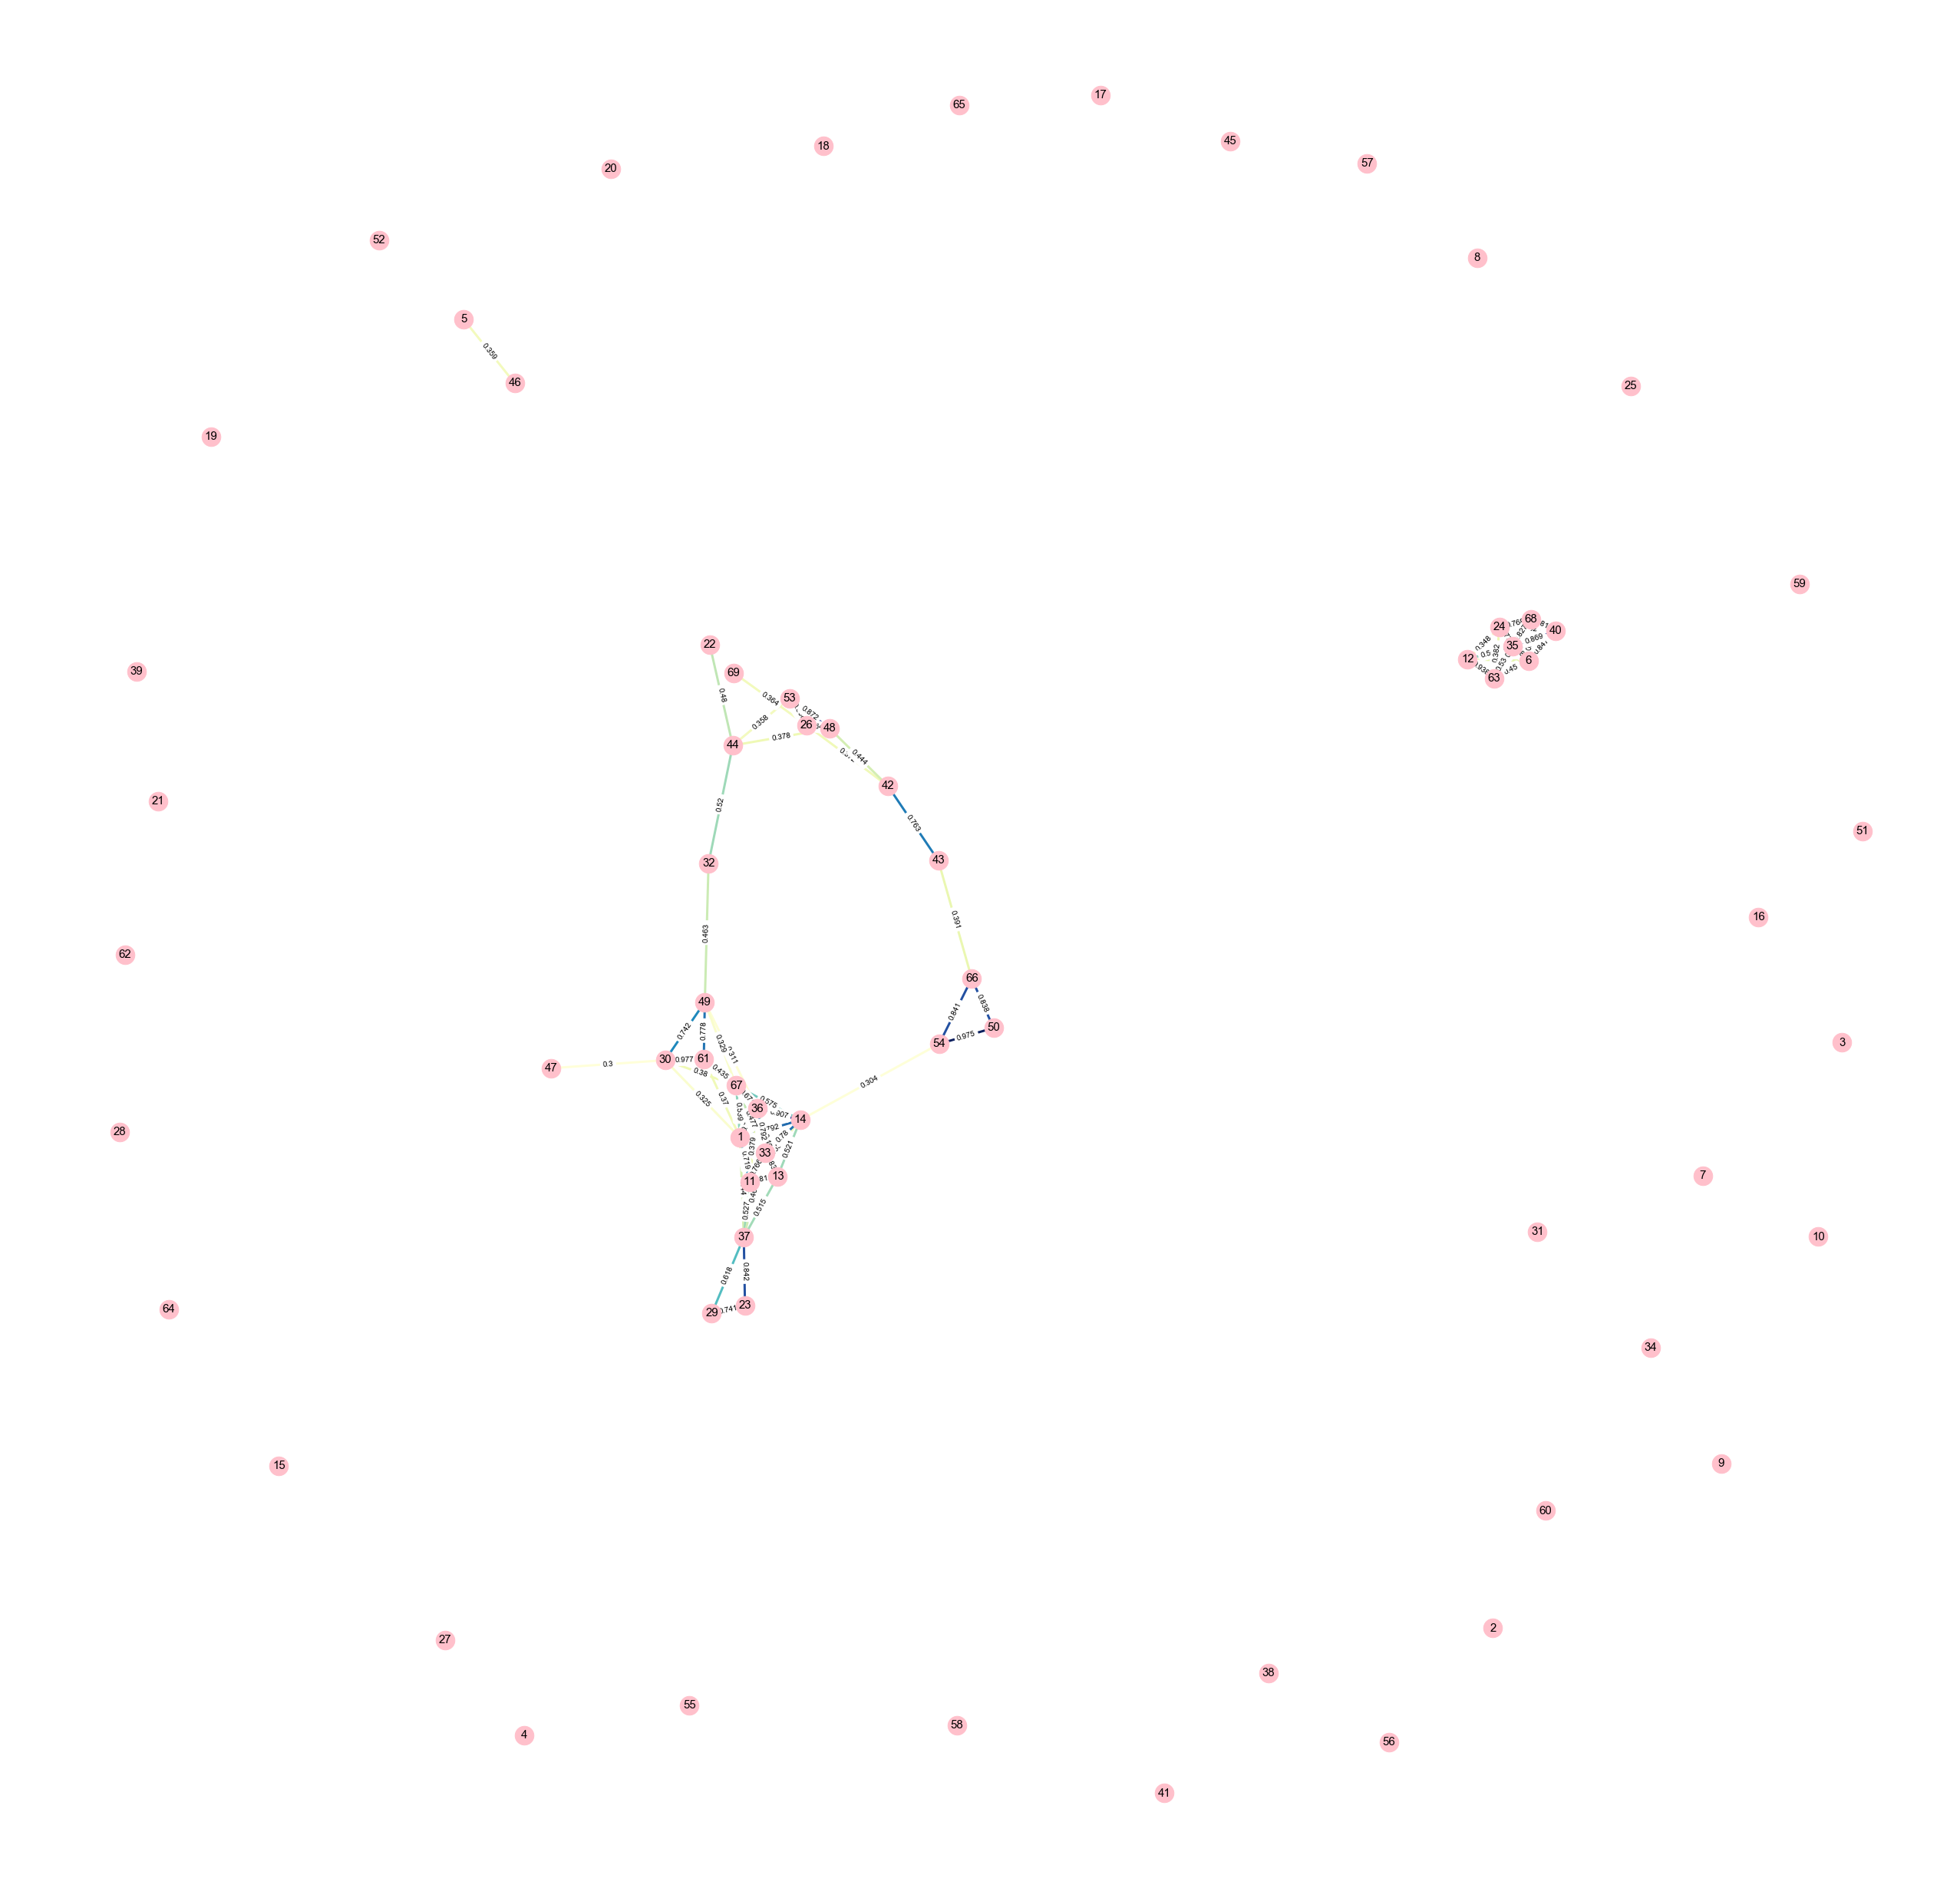

In [81]:
import networkx as nx

num_of_sec = 2
continuous_beh = dict()

node_sets = list()

for row in neuron_concated_behavior.itertuples():
    if row.ClosedArms_centerpoint == 1:
        continuous_beh[row[0]] = 1
    else:
        if len(continuous_beh) >= num_of_sec*10:
            begin = list(continuous_beh.keys())[0]
            end = list(continuous_beh.keys())[len(list(continuous_beh.keys()))-1]
            indices = "{}:{}".format(begin, end)
            print(indices)
            time_binned_dfs = bin_by_time(cell_transients_dataframe.loc[begin:end], freq="1Min")
            for i in range(len(time_binned_dfs)):
                open_graph = gau.create_graph(time_binned_dfs[i].reset_index(drop=True))
                node_sets.append(get_nodes_with_degree(open_graph))
                print(get_nodes_with_degree(open_graph))
                gau.plot_cluster_graph(open_graph, figsize=(45,45), node_color="pink", node_size=600)
            continuous_beh = dict()
        else:
            continuous_beh = dict()

In [70]:
node_sets[0].intersection(node_sets[1], node_sets[2])

{4, 5, 23, 31, 34, 40, 46, 47, 49, 54, 55, 57, 66, 69}